# Long Notebook
Group members: Alice Madama 104807, Arianna Cagali 105103, Oliver Sanchez: 568003

Group Name: PCswappers


We are going to assume that all of the packages listed below are available to the user. In case any were missing we advise installing them through the !pip install command.

In [38]:
import lightgbm as lgb
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import optuna
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import seaborn as sns


<a id="index"></a>
# Index
- [Introduction](#section1)
  - [Domain Knowledge](#subsection1.1)
  - [Reasoning behind our sections](#subsection1.2)
  - [How data is generated](#subsection1.3)
- [General Explorative Data Analysis and Data Manipulation](#section2)
  - [Data Cleaning and Feature Analysis Functions](#subsection2.1)
- [Attempted models and costumised data engineering and model interpretation](#section3)
  - [RNN Predictor with one location and feature engineering ( outliers removal, filtering of most relevant features by pure logic)](#subsection3.1)
  - [RNN predictor (merged locations) and Feature Engineering (same as above, with label encoding of the lcoation and stricter IQR)](#subsection3.2)
  - [First attempt at LightGBM with corresponding Feature Engineering ( Enconding of the location variable, concatenation of the training set, removal of flat stretches, observance of intuitive ideas: seasonal influence on Energy production, feature importance, removal of NaN and outliers)](#subsection3.3)
  - [Short notebook 2: LightGBM predictor with dedicated Feature Engineering (elimination of feature that do not logically appear useful, adding of resampling for the hour, date feature adding, observation of correlation pairs to individuate autocorrelation, hyperparameters from hypertuning)](#subsection3.4)
  - [Catboost Predictor for each location and dedicated Feature Engineering ( observation of scatter over days and hours, location feature definition, eliminating NaN)](#subsection3.5)
  - [Linear regression and some basic Feature Engineering ( observation of 'direct_rad:W', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'direct_rad_1h:J', 'sun_elevation:d' as linear features and cleaning of NaNs)](#subsection3.6)
  - [Random forest but with RFE feature selection, removal of NaNs](#subsection3.7)
  - [Short notebook 1: best result, catboost+extra features to better represent energy potential +flaml best model choice, flattened ](#subsection3.8)




<a id="section1"></a>

# Introduction

<a id="subsection1.1"></a>

## Domain Knowledge
When we're dealing with predictions related to solar panel energy output, the time of day, day of the week, and time of year all make a big difference. To build a model that can accurately forecast hourly energy production, we need to feed it with details that capture these variations.

Solar panel energy production is strongly related to environmental conditions, with the availability and intensity of sunlight being the most important feature. Solar panels are most productive during peak sunlight hours. Another critical factor is the angle at which sunlight strikes the panels, known as the "angle of incidence", which is typically optimized according to geographic location to maximize energy absorption. Interestingly, cooler temperatures can enhance solar panel efficiency, making them less effective during heat waves (Younes Ledmaoui et al.).

Naturally weather plays a significant role in the variability of solar energy output. Moreover, seasonal changes further affect solar production due to variations in daylight hours and the sun's trajectory. Contrary to common beliefs, while rain might temporarily decrease production, it can also benefit panels by cleaning their surfaces, thus removing efficiency-impeding dirt or debris. On the contrary, snow poses a dual-sided effect: accumulation can block panels from capturing sunlight, yet the associated increased sunlight reflection can potentially boost production if the panels are clear (Doddy Clarke and Sweeney). 

Beyond direct sunlight, other weather-related phenomena impact solar energy production. Winds, particularly cooler breezes, might improve panel efficiency by lowering their temperature, although extreme winds can cause damage. Atmospheric particles and pollution can scatter or absorb sunlight, thereby reducing the solar radiation reaching the panels.

In the realm of data-driven solar energy forecasting, drawning upon historical weather patterns and solar output data is crucial. Advanced machine learning methods, including AutoML tools, can discern complex relationships between weather variables and solar production. Understanding these interdependencies is vital for the design, installation, and predictive modeling of solar energy systems, intersecting the domains of renewable energy technology, meteorology, and data science. (Kraemer et al.)

### References

Younes Ledmaoui, et al. “Forecasting Solar Energy Production: A Comparative Study of Machine Learning Algorithms.” Energy Reports, vol. 10, 1 Nov. 2023, pp. 1004–1012, https://doi.org/10.1016/j.egyr.2023.07.042. Accessed 13 Aug. 2023.
Doddy Clarke, Eadaoin, and Conor Sweeney. “Solar Energy and Weather.” Weather, vol. 77, no. 3, 27 Nov. 2021, pp. 90–91, https://doi.org/10.1002/wea.4124.
Kraemer, Frank Alexander, et al. “Solar Energy Prediction for Constrained IoT Nodes Based on Public Weather Forecasts.” Proceedings of the Seventh International Conference on the Internet of Things  - IoT ’17, 2017, https://doi.org/10.1145/3131542.3131544. Accessed 19 Oct. 2020.

<a id="subsection1.2"></a>

## Reasoning behind our sections

The following code contains a generic version of our first investigation within the data, thus some graphs and easy data analysis and feature engineering. However, most of our attempts consist of case-specific model interpretation and feature engineering, thus we decided to preserve such characteristic even in this notebook. Following more generic approaches have been collected, however we will note in each subsection what notable feature engineering or feature selection has been carried out and why.

<a id="subsection1.3"></a>

## How data is generated

The target, pv_measurament, is generated through both observation and and estimation of the data. This is due to the necessity to estimate some of the testing data as weather forecast must be roughly defined in order to have a proper testing set for the future. The pv_measurament is likely produced by sensors within the panel itself which measure the electrical energy produced each time. Weather data instead has likely been collected from nearby weather stations in location A, B and C, however some data like cloudiness could also come from satellite information.





<a id="section2"></a>
# General explorative Data Analysis and Data Manipulation

In this function designed for enhancing our dataset for the CatBoost model, we're attempting to deal with a more subtle technique for encoding cyclical time features by using sine transformations. This method is especially useful for capturing the cyclic nature of time in a way that numbers alone cannot.

Here's what the function is doing:

- **Sine of Hour**: By calculating the sine of the hour, scaled by the total number of hours in a day, we're providing a smooth periodic feature that captures the daily cycle. This is crucial for a solar energy prediction model because it reflects the rise and fall of solar radiation throughout the day in a continuous, cyclical manner.

- **Sine of Month**: Similarly, the sine of the month, scaled by the total number of months in a year, gives us a smooth representation of the annual cycle. This feature can help the model pick up on the seasonal variations in solar energy production, which are driven by changes in the sun's position over the course of the year.

These sine features help the model to recognize and leverage the periodic nature of time without assuming a linear relationship, which can be an advantage when using tree-based models like CatBoost that can struggle with cyclical patterns otherwise.

In [40]:
def add_time_features_cat(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
 
    return df



<a id="subsection2.1"></a>

## Data Cleaning and Feature Analysis Functions

The below described functions are outlined in order to define outliers in our dataset, define the variance significance, in order to define variables that could potentially be eliminated and observed the scatterplot which confronts X_train values and the training targets by location to investigate for linear and non- linear realtionships.

- `clean_outliers_zscore(df, columns, z_threshold)`: This function removes outliers. Outliers can significantly skew the results of an analysis, leading to inaccurate models. By using the Z-score method, this function identifies and removes outliers based on a specified threshold, set to 3 to capture points that lie beyond three standard deviations from the mean.

- `check_variance_significance(df, threshold)`: Low variance do not contribute much information useful for a predictive model, as they do not change much across different instances. This function uses a threshold value to eliminate features with variance lower than the threshold. The VarianceThreshold method from scikit-learn is employed to perform this task, effectively reducing the dimensionality of the dataset.


In [ ]:


def scatter_over_hours(location_data, title):
    location_data['time'] = pd.to_datetime(location_data['time'])
    location_data['hour'] = location_data['time'].dt.hour
    hourly_avg = location_data.groupby('hour')['pv_measurement'].mean()

    plt.figure(figsize=(8, 4))
    plt.scatter(location_data['hour'], location_data['pv_measurement'], label='pv_measurement', alpha=0.5)
    plt.plot(hourly_avg.index, hourly_avg, color='red', label='Average pv_measurement', linewidth=2)
    plt.title(f'Hourly pv_measurement Over a Day ({title})')
    plt.xlabel('Hour of the Day')
    plt.ylabel('pv_measurement')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def scatter_over_days(location_data, title):
    location_data['day_of_year'] = location_data['time'].dt.dayofyear
    daily_avg = location_data.groupby('day_of_year')['pv_measurement'].mean()

    plt.figure(figsize=(8, 4))
    plt.scatter(location_data['day_of_year'], location_data['pv_measurement'], label='pv_measurement', alpha=0.5)
    plt.plot(daily_avg.index, daily_avg, color='red', label='Average pv_measurement', linewidth=2)
    plt.title(f'Daily pv_measurement Over the Year ({title})')
    plt.xlabel('Day of the Year')
    plt.ylabel('pv_measurement')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_targets(targets, start_date, end_date):
    # Create a scatter plot of targets over their count
    plt.figure(figsize=(15, 6))
    plt.scatter(range(len(targets['pv_measurement'])), targets['pv_measurement'], label='Targets', color='blue')
    plt.xlabel('PV Measurement')
    plt.ylabel('Index')
    plt.title('Scatter Plot of Targets')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
     
def find_strong_correlation_pairs(data, threshold=0.95):
        # Calculate the correlation matrix
        correlation_matrix = data.corr()

        # Find pairs with strong correlation
        strong_correlation_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i + 1, len(correlation_matrix.columns)):
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    strong_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

        # Print pairs with strong correlation
        if strong_correlation_pairs:
            print("Pairs with strong correlation:")
            for pair in strong_correlation_pairs:
                print(f"{pair[0]} and {pair[1]} have a correlation of {correlation_matrix[pair[0]][pair[1]]}")
        else:
            print("No strong correlation pairs found.")

        print("\n")
        return strong_correlation_pairs

def clean_outliers_zscore(df, columns, z_threshold=3):
    cleaned_df = df.copy()
    
    for col in columns:
        z_scores = np.abs((cleaned_df[col] - cleaned_df[col].mean()) / cleaned_df[col].std())
        outliers = z_scores > z_threshold
        cleaned_df.loc[outliers, col] = np.nan  # Set outliers to NaN
    
    cleaned_df = cleaned_df.dropna()  # Remove rows with NaN values
    
    return cleaned_df      

def visualize_low_variance_features(df, threshold):
    # Exclude non-numeric columns for variance threshold calculation
    df_numeric = df.select_dtypes(include=[np.number])

    # Apply VarianceThreshold
    vt = VarianceThreshold(threshold=threshold)
    vt.fit(df_numeric)

    # Create a dataframe for variance
    variance_df = pd.DataFrame({
        'variance': vt.variances_,
        'select_feature': vt.get_support()
    }, index=df_numeric.columns)

    # Filter out features that are selected (above the threshold)
    low_variance_df = variance_df[variance_df['select_feature'] == False]

    # Plotting
    plt.figure(figsize=(10, 6))
    low_variance_df['variance'].plot(kind='bar')
    plt.title('Features with Variance Below the Threshold')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.xticks(rotation=45)
    plt.show()

    return low_variance_df



We then simply ensures to have all the available data at hand in the notebook. Moreover, taking into consideration the presence of different locations, it adds a new categorical feature, which assigns 0 to location A, 1 to location B and 2 to location C. The datasets are then concatenated to return one unique data source.

In [39]:
# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 0
X_train_estimated_A['location'] = 0
X_train_observed_A['location'] = 0

X_test_estimated_B['location'] = 1
X_train_estimated_B['location'] = 1
X_train_observed_B['location'] = 1

X_test_estimated_C['location'] = 2
X_train_estimated_C['location'] = 2
X_train_observed_C['location'] = 2

# Concatenate the datasets
X_test_estimated_total = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated_total = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed_total = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])

train_targets_total = pd.concat([train_targets_A, train_targets_B, train_targets_C])


In [ ]:
plot_targets(train_targets_total, '2017-07-01' , '2024-08-30')
#I attach an image of the data results just in case something goes wrong with the visualization

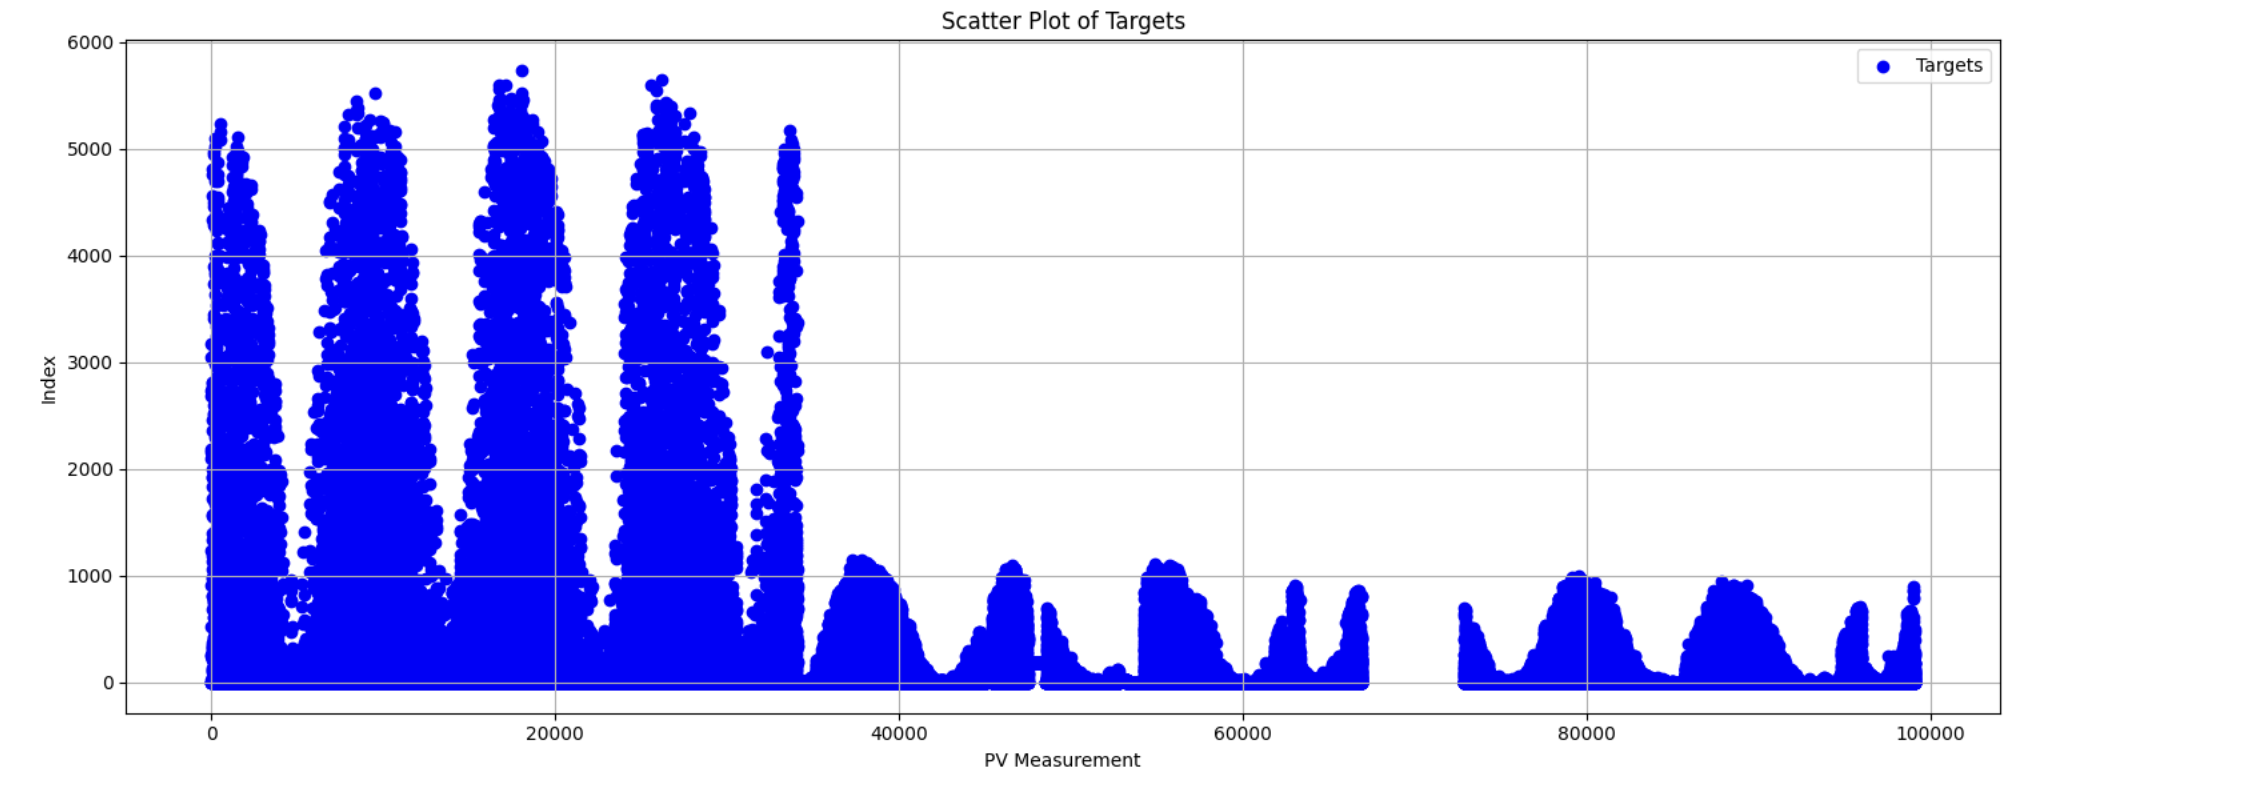

The first thing notable is a big gap in the data itself. Such gap will be kept in mind and we will use this knowledge to our advantage in order to better performance and avoid sections which are lacking proper data for predictions ( we will eliminate stretches of lacking data)

In [ ]:
find_strong_correlation_pairs(X_train_estimated_total)
find_strong_correlation_pairs(X_train_estimated_total)

Notably it does appear there is some autocorrelation in the training features.

In [ ]:
visualize_low_variance_features(X_train_observed_total, threshold = 0.01 )
visualize_low_variance_features(X_train_estimated_total, threshold = 0.01 )
#attaching images again in case of non runnable cell

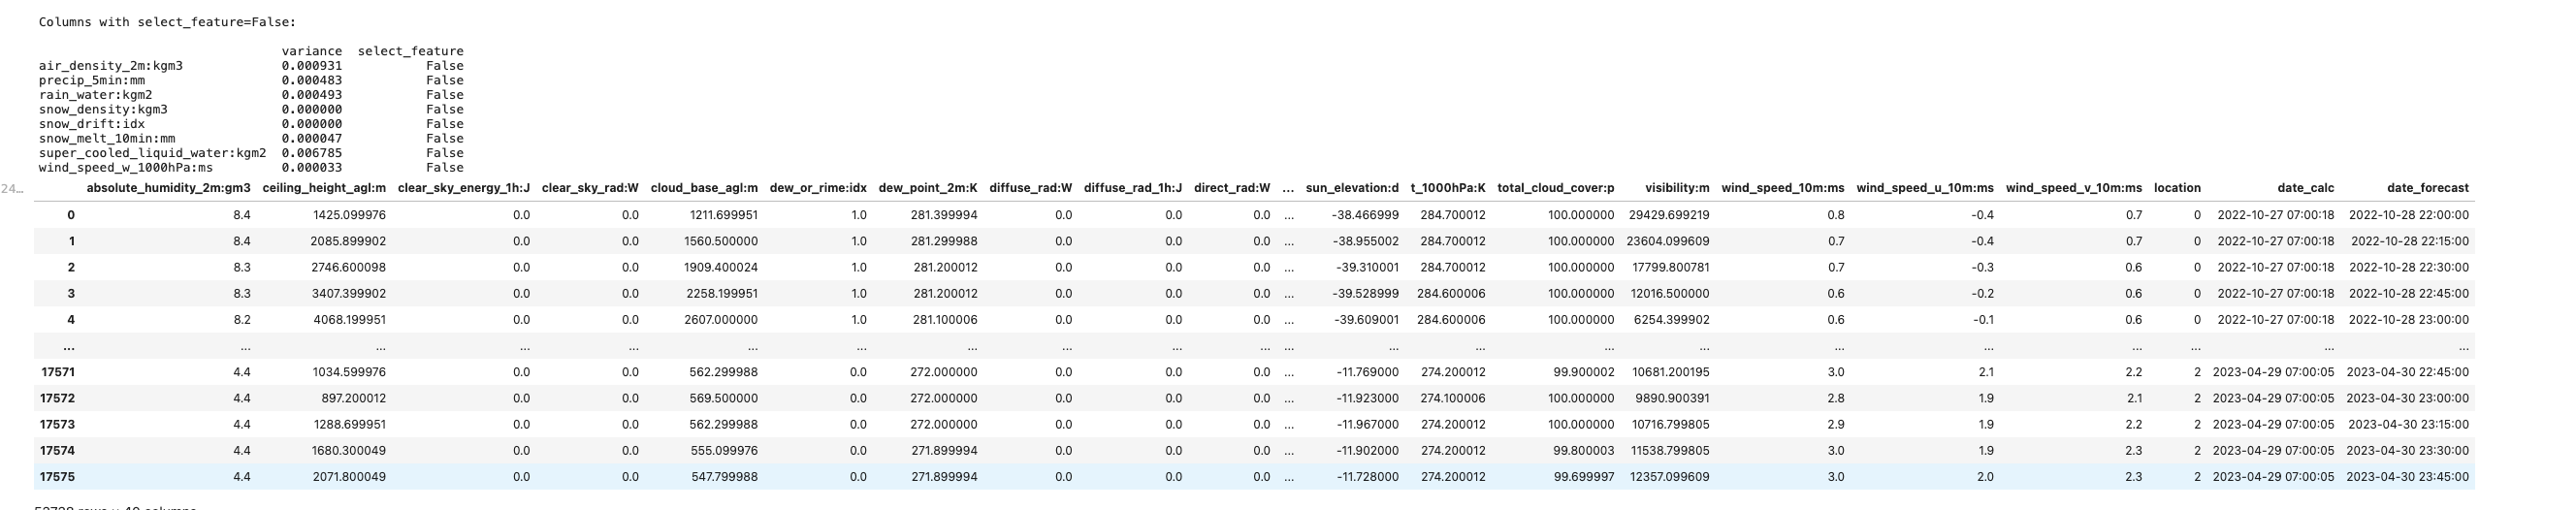

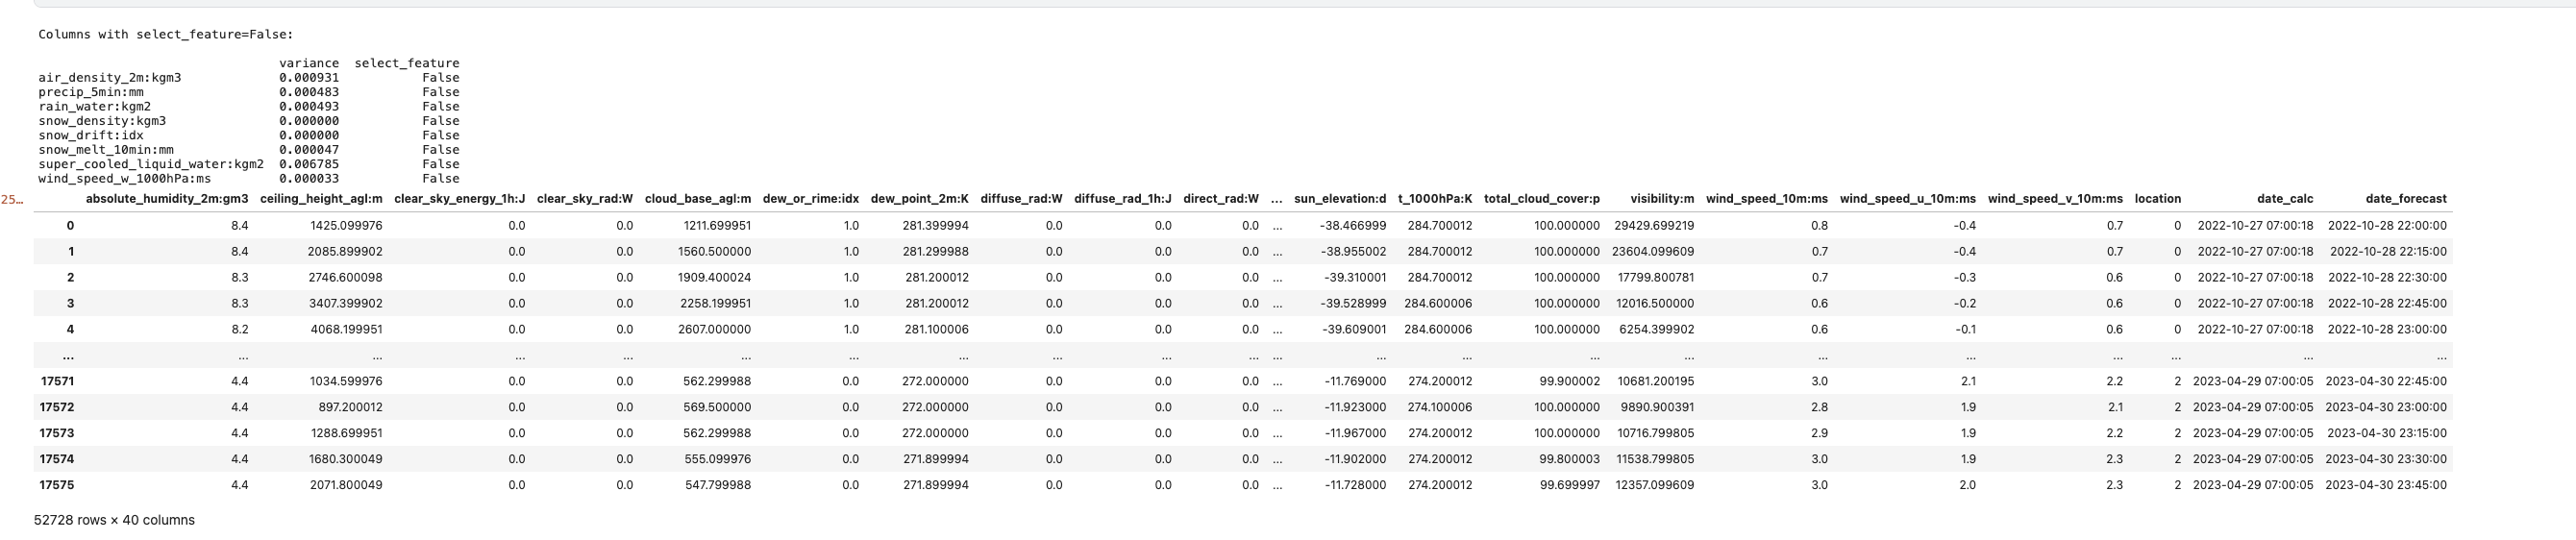

Notably there are quite a few features, specifically regarding snow_drif, melting, density of air and wind speed that do no seem to have any importance.

In [ ]:
def plot_pv_measurement(location):
    try:
        train = pd.read_parquet(f"data/{loc}/train_targets.parquet")

        if train.empty:
            print(f"No data available for Location {location}")
            return

        plt.figure(figsize=(12, 7))
        plt.plot(train['time'], train['pv_measurement'], label=f'PV Measurement at Location {location}', linestyle='-', marker='o', markersize=4)
        plt.xlabel('Time')
        plt.ylabel('PV Measurement')
        plt.title(f'Solar Power Measurement Trends - Location {location}')
        plt.grid(True)
        plt.legend()
        plt.show()
    except FileNotFoundError:
        print(f"Data file not found for Location {location}")

locations = ['A', 'B', 'C']
for loc in locations:
    plot_pv_measurement(loc)


# I am once again pasting an image of what it is supposed to look like in case this ends up not running at all

`plot_pv_measurement(location)`: a visual representation of the relationship between each feature and the target variable. This function creates a series of scatter plot subplots for each feature against the target variable, facilitating the identification of relationships, trends, and data clusters. 

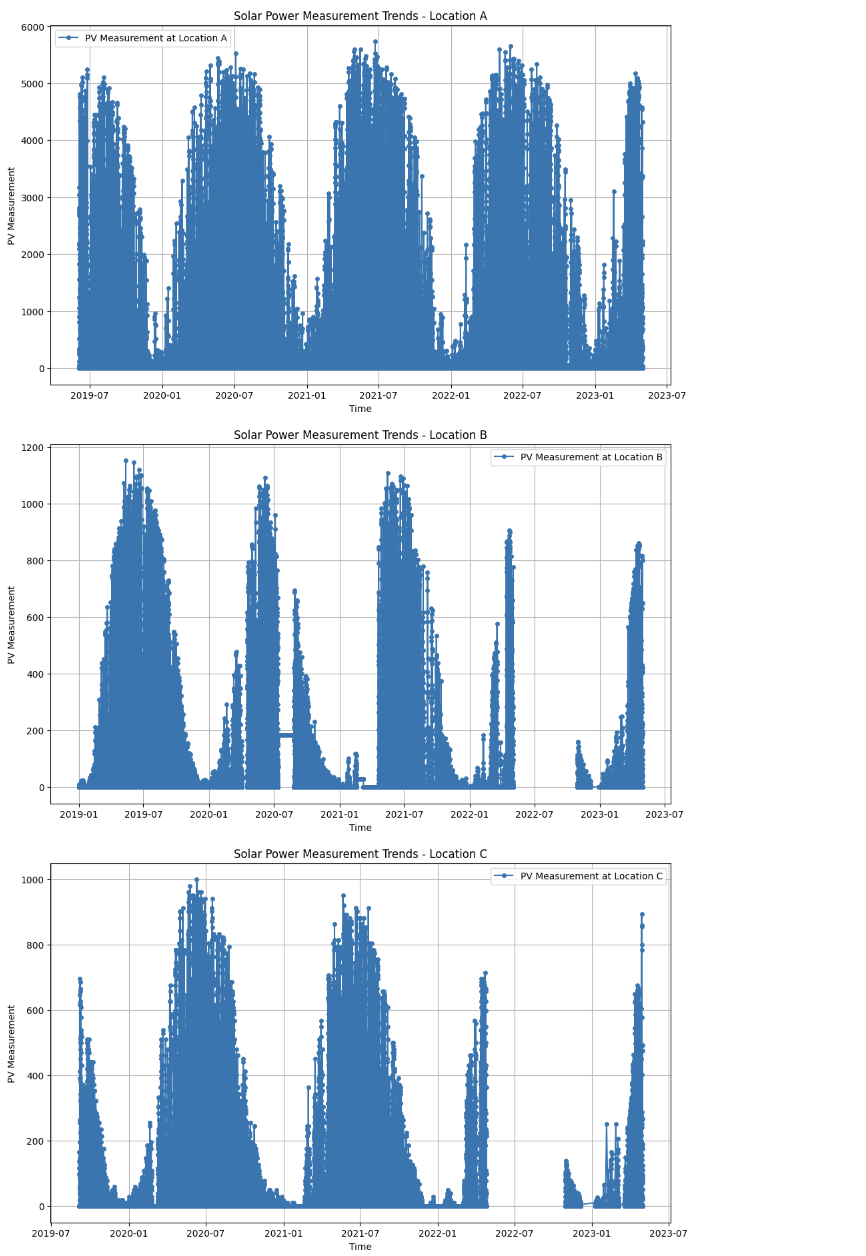

We once again encountered quite a few stretches of missing data, we are also able to observed picques in the target variable. Moreover, we noted a kind of sine-cosine variability within the data, this intuitio will also come in handy later on for some of our best models.

### More investigation

We then concluded that a better overview of the entire data was necessary in order to define the upcoming steps. The function capture_df_info(df) extracts vital summary information from a DataFrame using the df.info() method, which includes the number of non-null entries for each column and the datatype of each column. This step is crucial for identifying data completeness, presence of missing values, and the potential need for data type conversion, which are all critical factors affecting subsequent data analysis.

This comparison helps ensure consistency across training sets and targets, which is necessary for the proper functioning of machine learning models. For instance, if the number of rows in a features set does not match its corresponding targets set, it can lead to errors during model training or when evaluating model performance.

In [ ]:

from IPython.display import HTML
import io

# Function to capture a DataFrame's info output as a string
def capture_df_info(df):
    buffer = io.StringIO()
    df.info(buf=buffer)
    info_str = buffer.getvalue().split('\n')
    info_html = '<br>'.join(info_str)  # Use line breaks for HTML formatting
    return info_html

# Capture info for all DataFrames
info_A = capture_df_info(X_train_observed_A)
info_targets_A = capture_df_info(train_targets_A)
info_B = capture_df_info(X_train_observed_B)
info_targets_B = capture_df_info(train_targets_B)
info_C = capture_df_info(X_train_observed_C)
info_targets_C = capture_df_info(train_targets_C)

# Create an HTML table to display them side by side with inline CSS for better styling
html_output = f"""
<div style="display: flex; width: 100%; flex-wrap: wrap; align-items: flex-start;">
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Features Set A</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_A}</div>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Targets Set A</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_targets_A}</div>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Features Set B</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_B}</div>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Targets Set B</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_targets_B}</div>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Features Set C</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_C}</div>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3 style="text-align:center;">Training Targets Set C</h3>
        <div style="background-color: #f9f9f9; padding: 10px;">{info_targets_C}</div>
    </div>
</div>
"""

# Display the HTML output
display(HTML(html_output))


Scatter plots are a fundamental tool in exploratory data analysis offering a clear visual representation of the relationship between two variables. In this context, we intend to create scatter plots for different locations (A, B, and C) over different time frames (hours and days). 

For train_targets_A, train_targets_B, and train_targets_C, the function scatter_over_hours would generate scatter plots illustrating the distribution and variability of the data across different hours of the day. This can help detect patterns or cyclical behaviors which occur within a single day, such as diurnal patterns which are common in environmental data like temperature or light levels.

Similarly, scatter_over_days would create scatter plots that spread the data over days, which can unveil longer-term trends or weekly cycles, such as increased activity during weekdays versus weekends or pay cycles in economic data.

In [ ]:
def scatter_over_hours(location_data, title):
    location_data['time'] = pd.to_datetime(location_data['time'])
    location_data['hour'] = location_data['time'].dt.hour
    hourly_avg = location_data.groupby('hour')['pv_measurement'].mean()

    plt.figure(figsize=(8, 4))
    plt.scatter(location_data['hour'], location_data['pv_measurement'], label='pv_measurement', alpha=0.5)
    plt.plot(hourly_avg.index, hourly_avg, color='red', label='Average pv_measurement', linewidth=2)
    plt.title(f'Hourly pv_measurement Over a Day ({title})')
    plt.xlabel('Hour of the Day')
    plt.ylabel('pv_measurement')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def scatter_over_days(location_data, title):
    location_data['day_of_year'] = location_data['time'].dt.dayofyear
    daily_avg = location_data.groupby('day_of_year')['pv_measurement'].mean()

    plt.figure(figsize=(8, 4))
    plt.scatter(location_data['day_of_year'], location_data['pv_measurement'], label='pv_measurement', alpha=0.5)
    plt.plot(daily_avg.index, daily_avg, color='red', label='Average pv_measurement', linewidth=2)
    plt.title(f'Daily pv_measurement Over the Year ({title})')
    plt.xlabel('Day of the Year')
    plt.ylabel('pv_measurement')
    plt.legend()
    plt.grid(True)

In [ ]:

# Scatterplots over hours and day for each location
scatter_over_hours(train_targets_A, 'Location A')
scatter_over_days(train_targets_A, 'Location A')
# attaching an image just in case

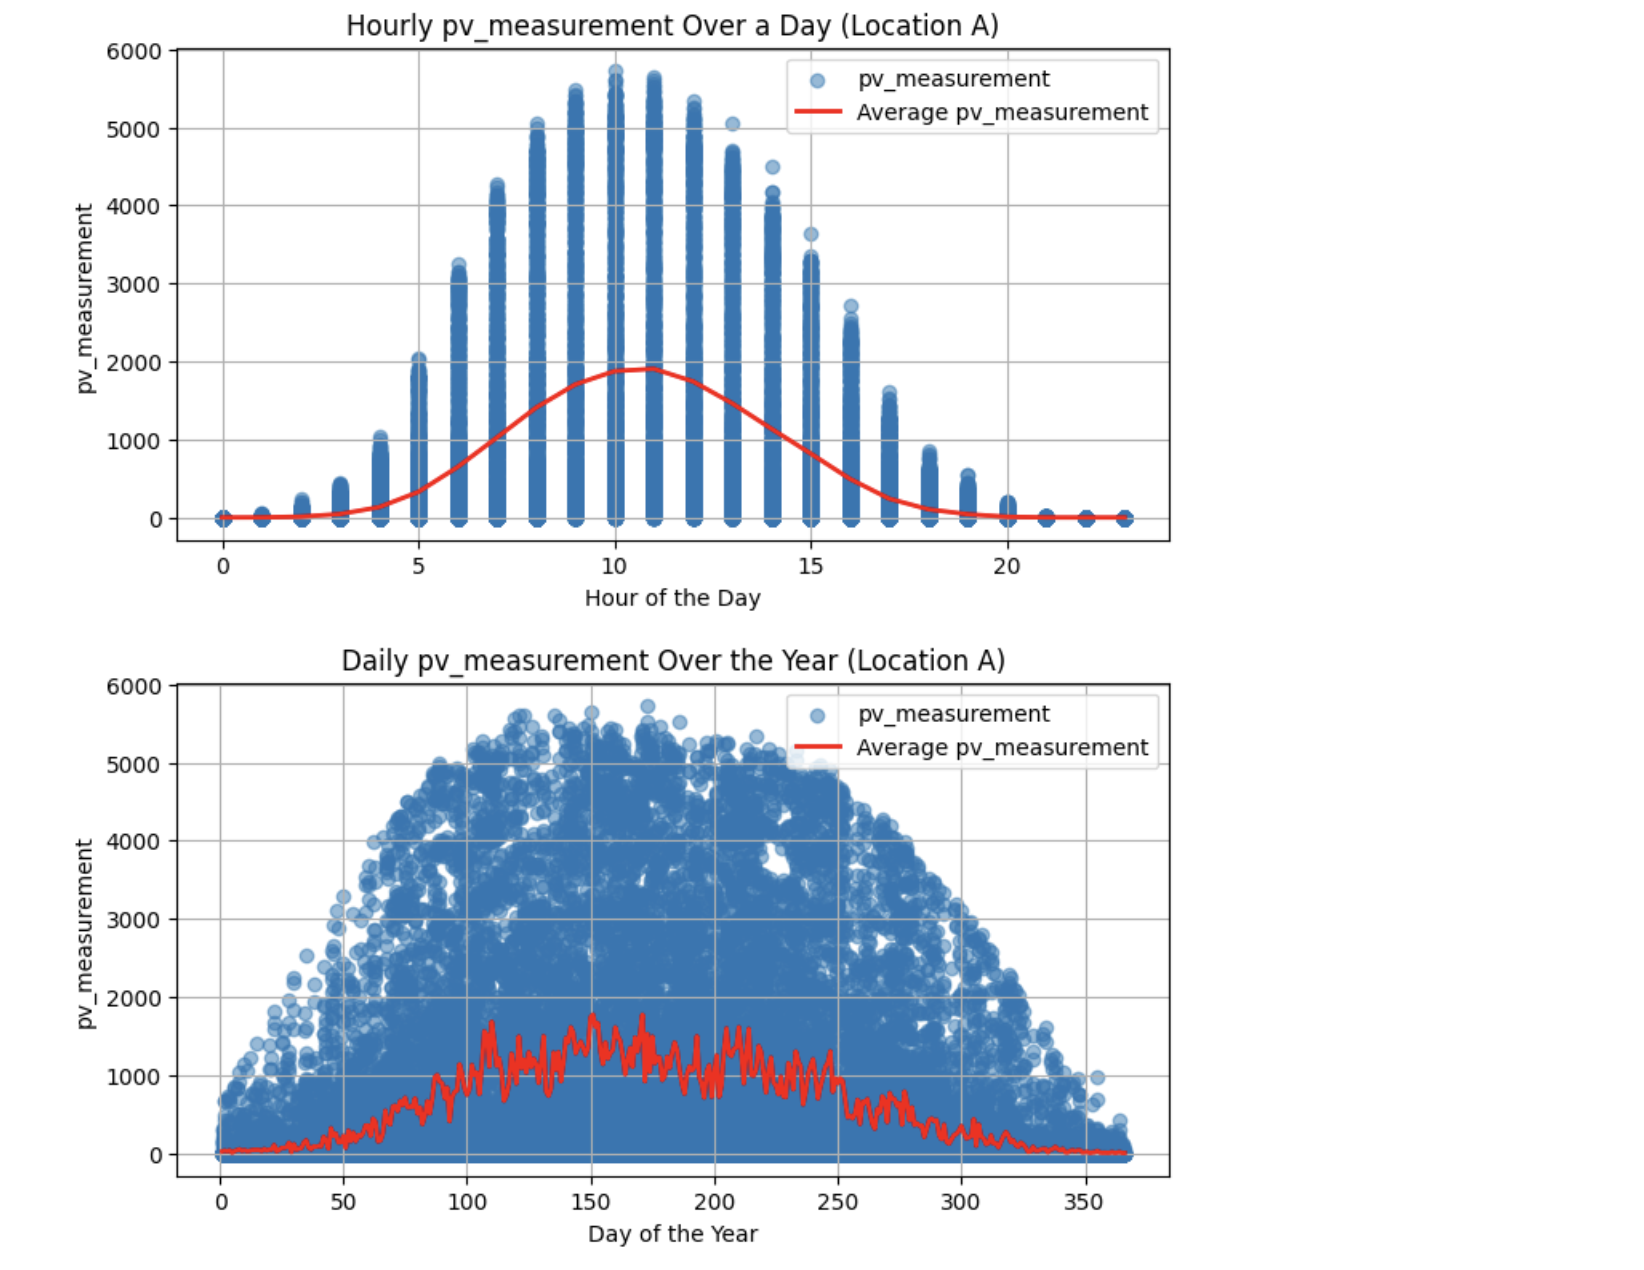

As showed by the image above we have a somehwat noraml distribution over the day, that however gets slightly skewed over the day of the year.

In [ ]:
scatter_over_hours(train_targets_B, 'Location B')
scatter_over_days(train_targets_B, 'Location B')


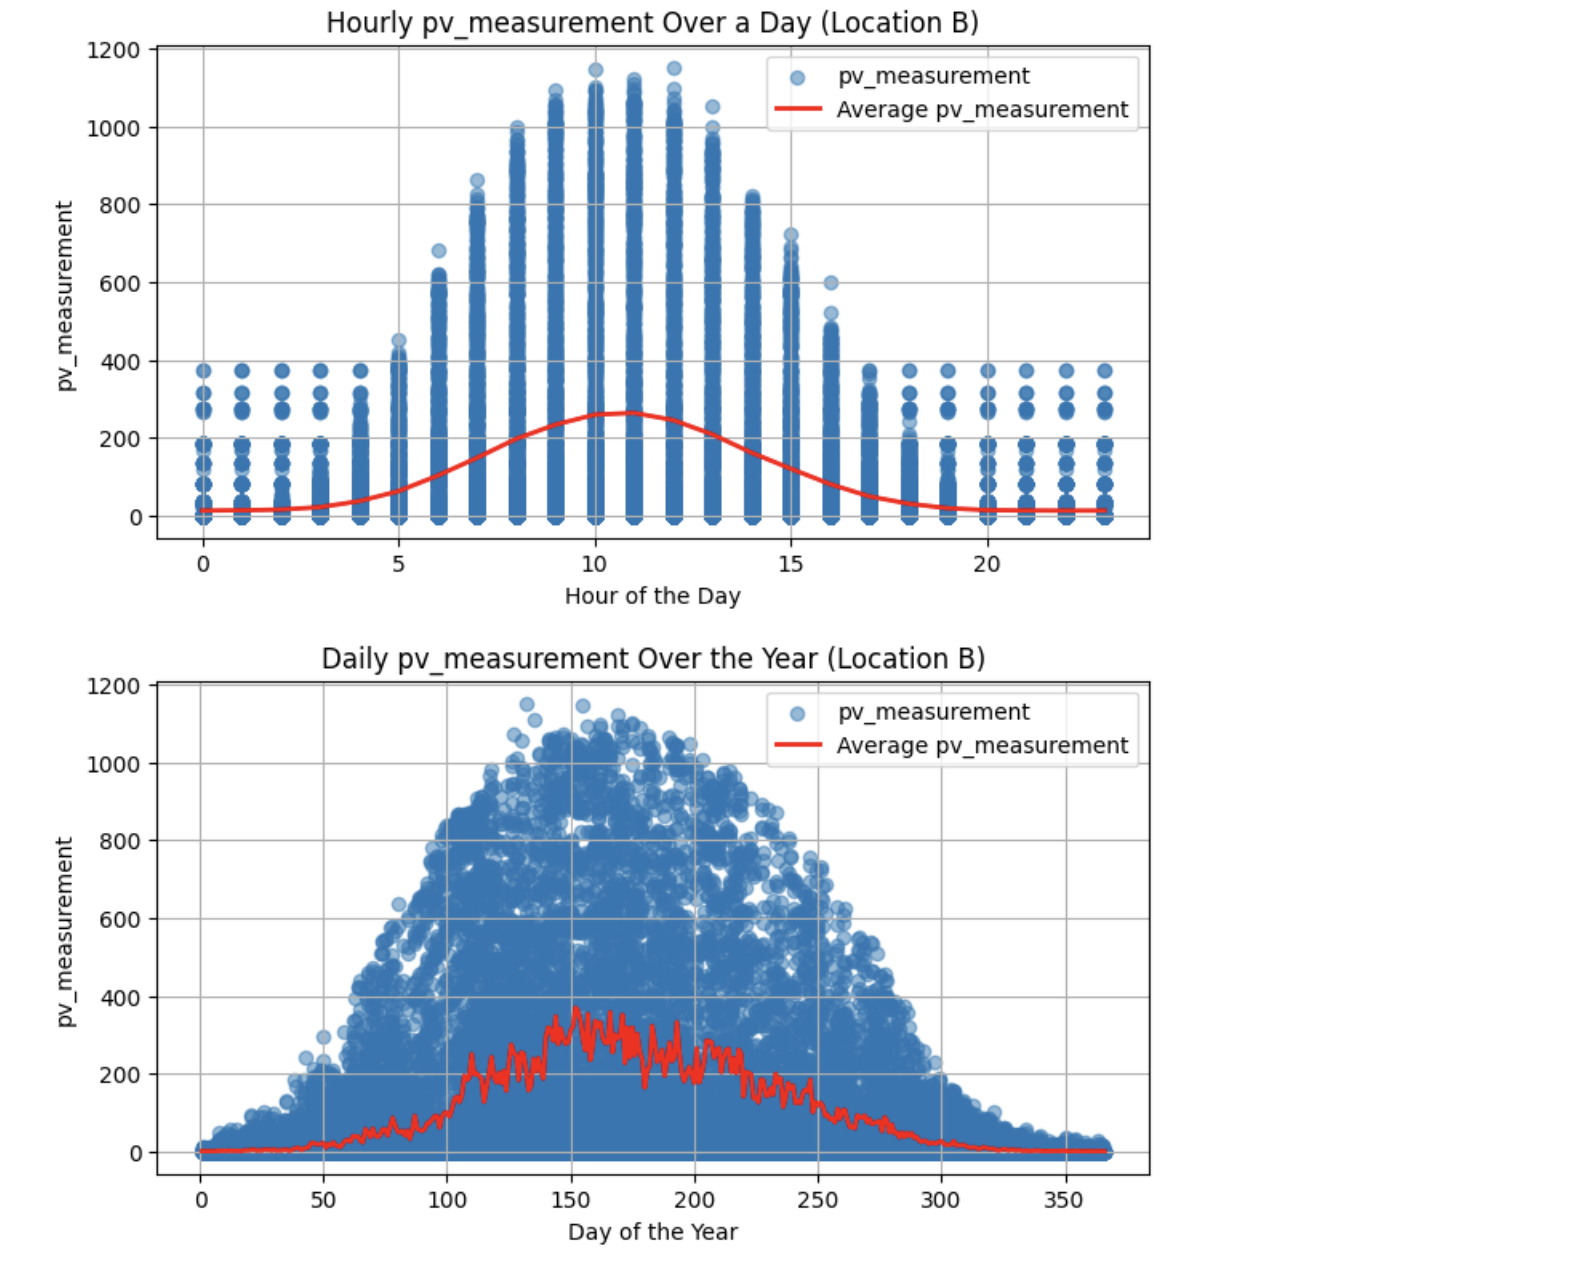

We notice some differences immediately from Location A and Location B. Although the skewing is not quite as hard in the Location B, the hourly pv measures over the day are actually not as normal as Location A.

In [ ]:

scatter_over_hours(train_targets_C, 'Location C')
scatter_over_days(train_targets_C, 'Location C')

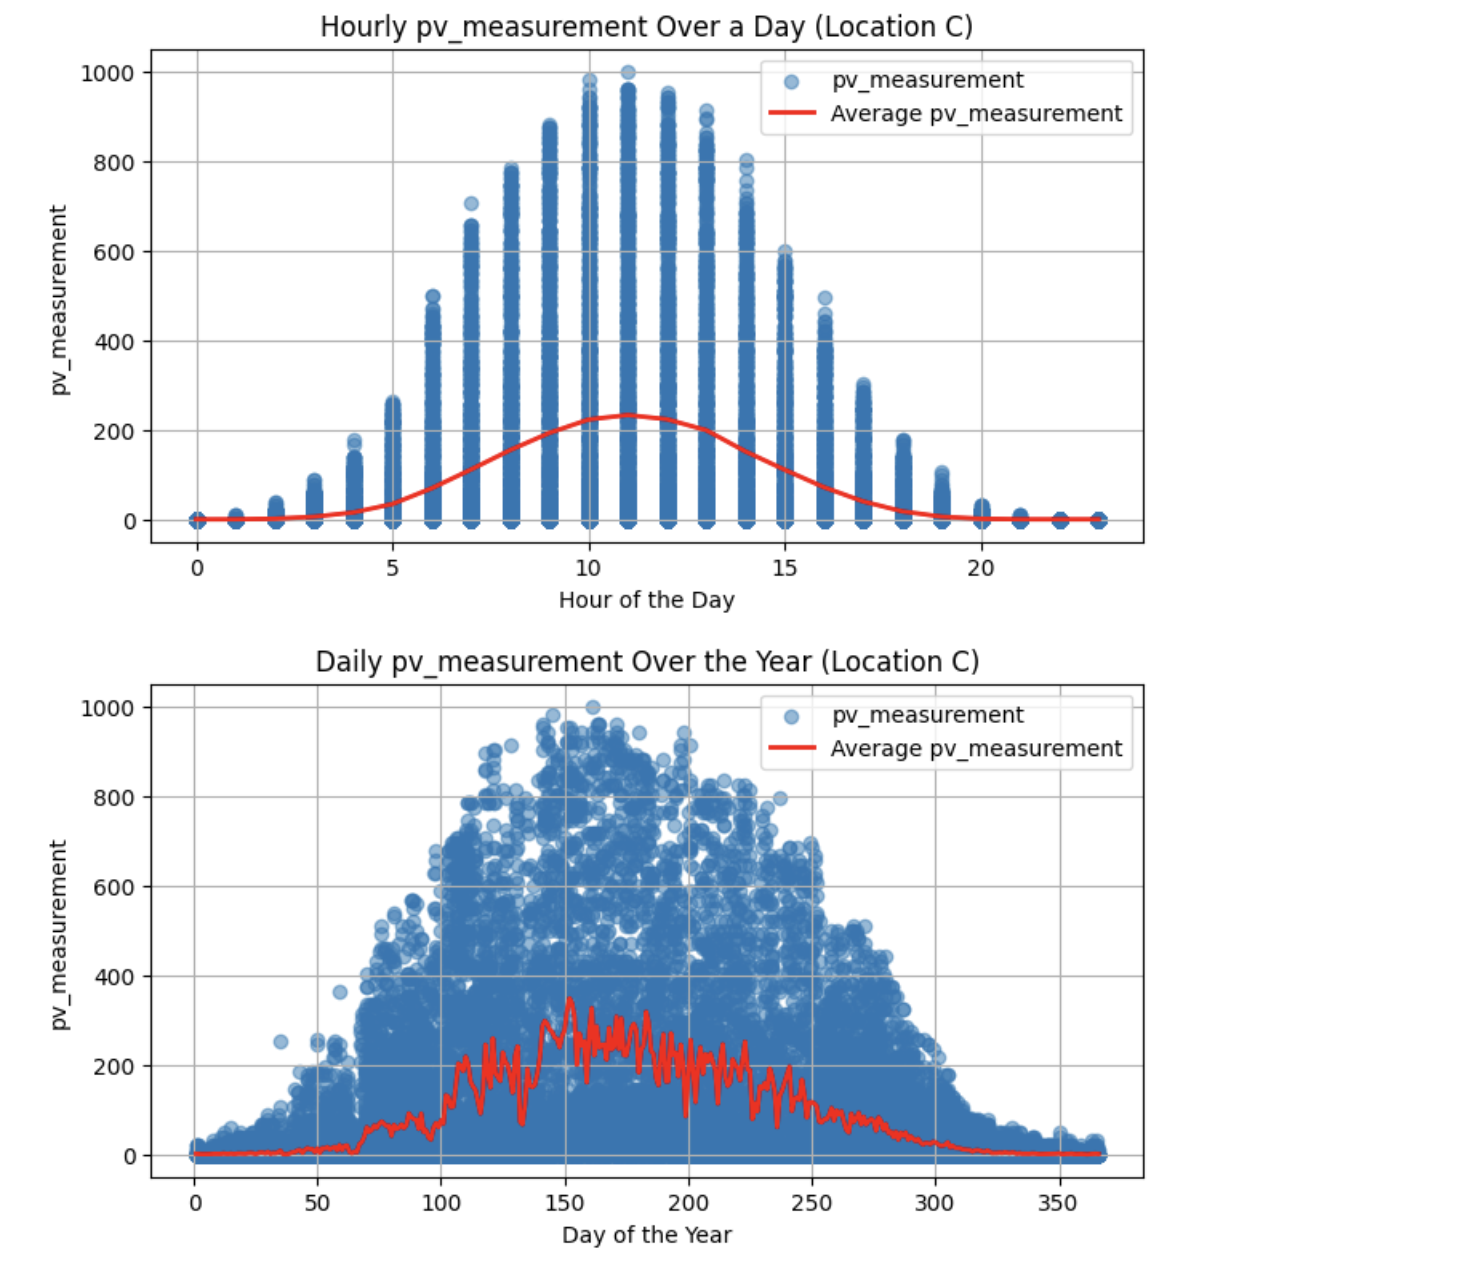

Location C, however, seems quite more similar to Location A.

The function `plot_multiple_pv_measurement_statistics` visually summarizes key statistical metrics across multiple datasets. When conducting exploratory data analysis (EDA), this function can provide insights into the data quality and distribution characteristics of a particular variable of interest across different subsets or groups within the data.

When the function is applied to `train_targets_A`, `train_targets_B`, and `train_targets_C`, each representing data from different locations or conditions (A, B, and C), it yields a comparative view of the following statistical aspects:

- **NaN Count**: The count of NaN values is a direct measure of missing data within the `pv_measurement` column for each dataset. H

- **Zero Count**: The zero count serves as an indicator of how often the variable of interest records a value of zero, which in certain contexts could represent non-occurrences, default states, or placeholder values. 

- **Mean Value**: The mean provides a central tendency measure which is useful for gauging the average level of the `pv_measurement` variable across the datasets. 


In [ ]:

def plot_multiple_pv_measurement_statistics(dfs, titles, column_name='pv_measurement'):
    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Adjust the size as needed

    for i, (df, title) in enumerate(zip(dfs, titles)):
        # Calculate the number of NaNs, zeros, and the mean in the pv_measurement column
        nan_count = df[column_name].isna().sum()
        zero_count = (df[column_name] == 0).sum()
        mean_value = df[column_name].mean()

        # Set the title for each subplot
        axs[i].set_title(title, fontsize=14)

        # Display the statistics in each subplot
        stats_text = (f"NaN Count: {nan_count}\n"
                      f"Zero Count: {zero_count}\n"
                      f"Mean Value: {mean_value:.2f}")

        axs[i].text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center')
        axs[i].axis('off')  # Hide the axes

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have three DataFrames: df_A, df_B, and df_C
# And corresponding titles for each
dfs = [train_targets_A, train_targets_B, train_targets_C]
titles = ['Statistics for A', 'Statistics for B', 'Statistics for C']
plot_multiple_pv_measurement_statistics(dfs, titles)

# once again adding the screenshot below just in case

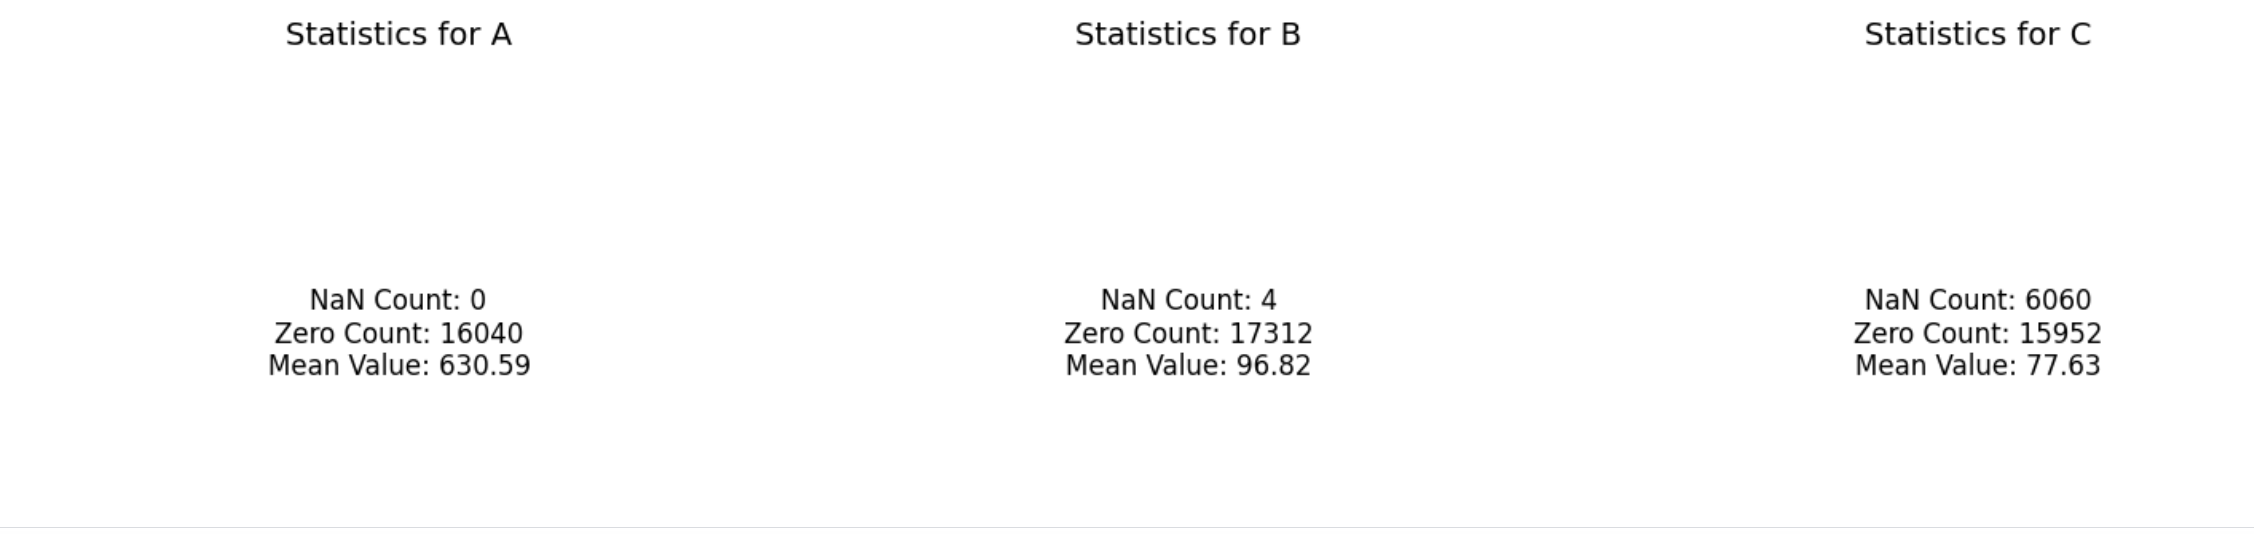

Through this analysis we can denote, how much higher energy production appears to be in Location A. Moreover, Location C seems to be the most problematic: it has an incredibly low pv_measurement on average, and quite high NaN count.

Regarding the high presence of NaN values, we did consider re-assigning it to a median or an average value, however that always dropped the performance of our model. As a consequence we prefer dropping them all together.

In [ ]:

# Drop missing values in pv_measurement
train_targets_A.dropna(subset=['pv_measurement'], inplace=True)
train_targets_B.dropna(subset=['pv_measurement'], inplace=True)
train_targets_C.dropna(subset=['pv_measurement'], inplace=True)

### Feature Importance and correlation investigation

In [ ]:
X_train = pd.concat([X_train_observed_total, X_train_estimated_total], axis=0)
X_train = X_train.drop(columns=['date_calc'])

# Merge dataframes based on the time column
merged_df = pd.merge(X_train, train_targets_total, left_on=['date_forecast'], right_on=['time'], how='inner')
merged_df = merged_df.drop(columns=['time'])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming merged_df is your DataFrame
merged_df = merged_df.dropna()

X_data = merged_df.iloc[:, 1:-1]  # All columns except the last one
y_data = merged_df.iloc[:, -1]   # Only the last column

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_data)

coefficients = lin_reg.coef_
features = X_data.columns

# Sorting the features based on absolute coefficient values
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Increase figure size and adjust layout
plt.figure(figsize=(15, 8))
plt.bar(features[sorted_indices], coefficients[sorted_indices])
plt.xticks(rotation=90)  # Rotate labels to 90 degrees
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.tight_layout()  # Adjust the layout
plt.show()

# once again attaching the image for simplicity

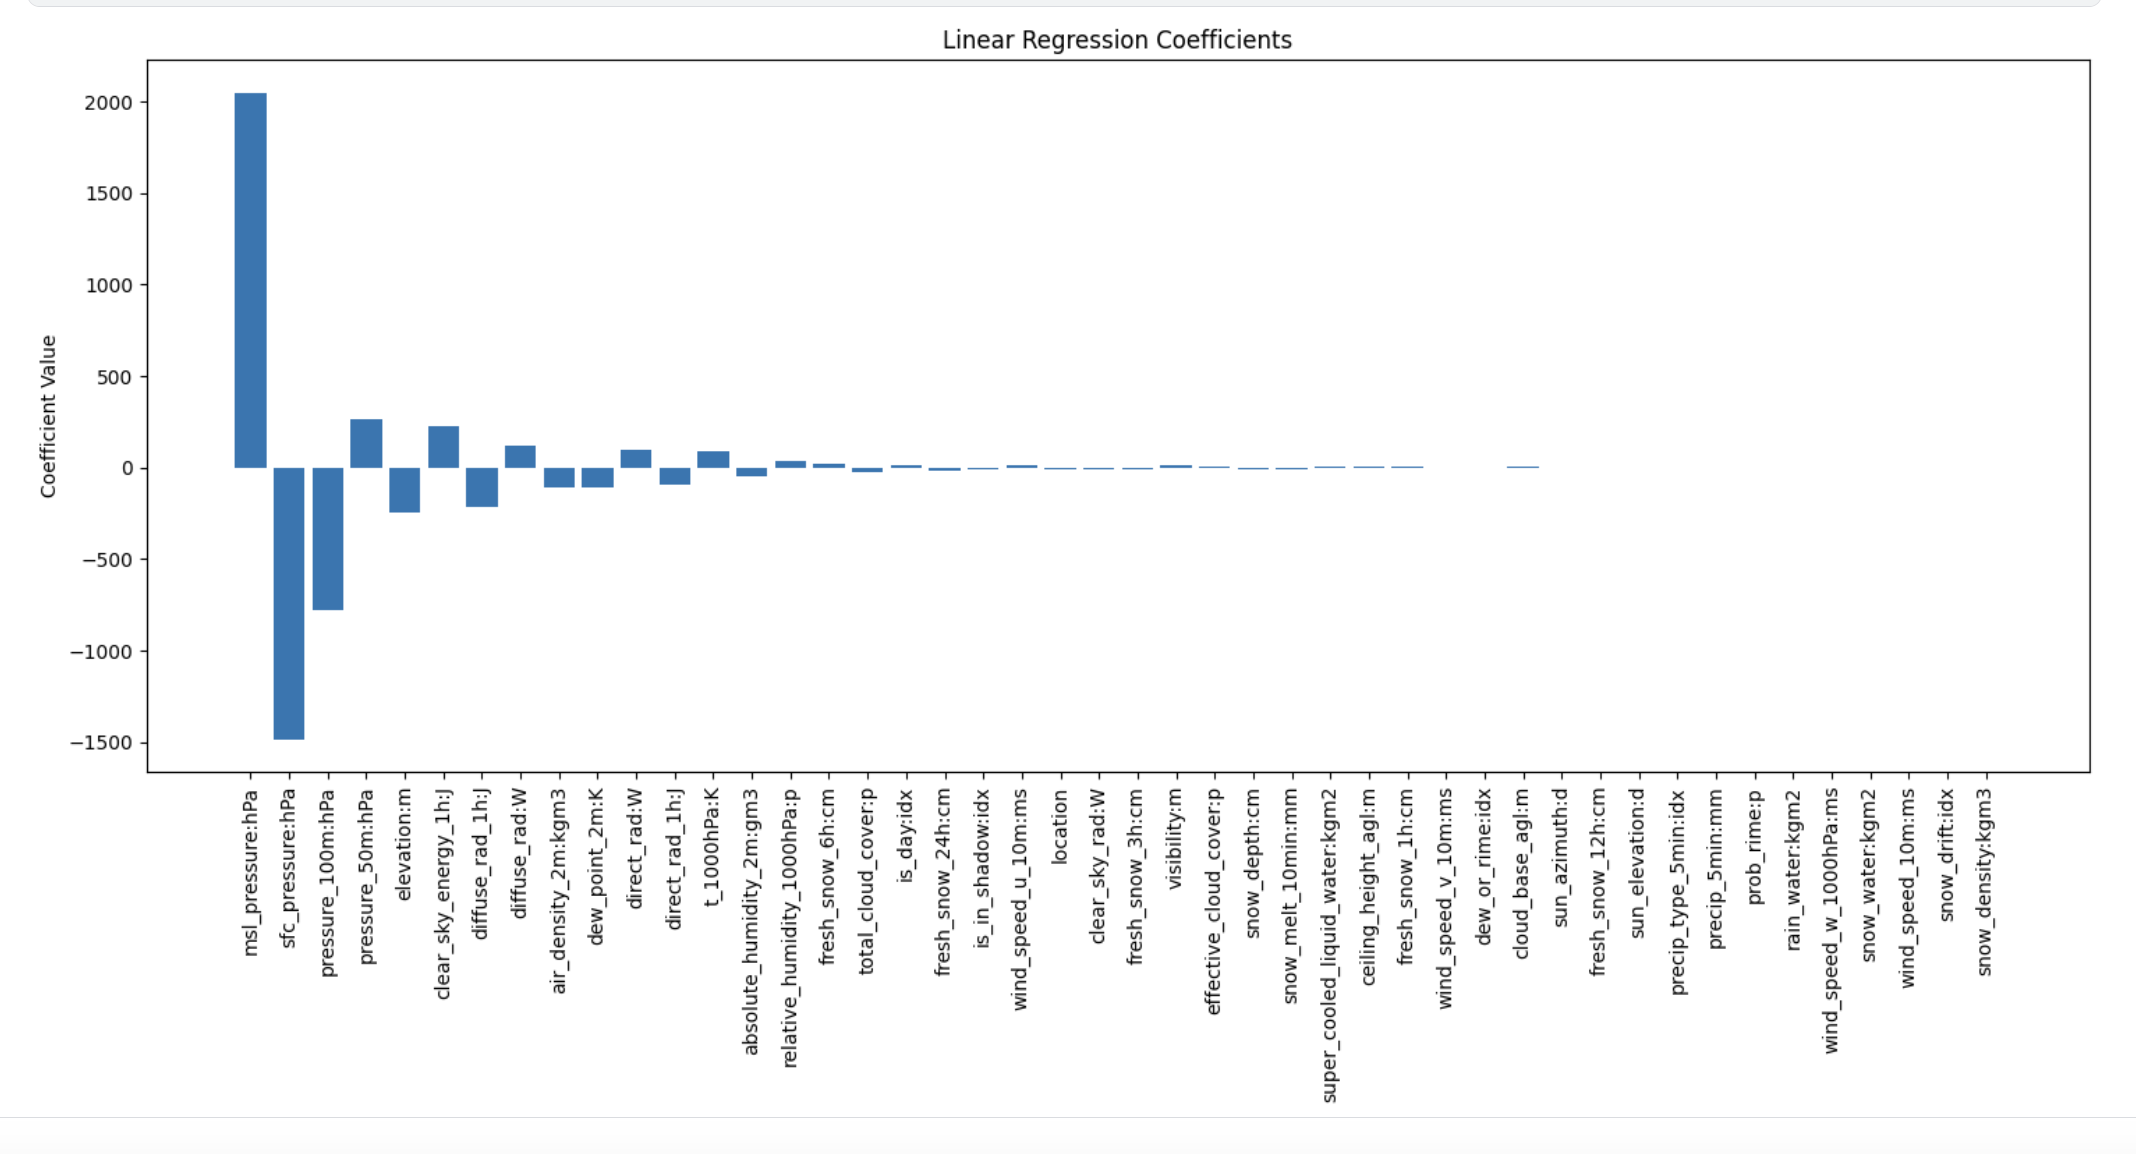

Here we conducted a quick image related investigation regarding Linear Regression. We will come back to this idea later on.

In [ ]:
import seaborn as sns

selected_df = merged_df[['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d', 'pv_measurement','air_density_2m:kgm3', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'snow_melt_10min:mm', 'wind_speed_w_1000hPa:ms']]
correlation_matrix = selected_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Random Forest Regression
model = RandomForestRegressor()
model.fit(X_data, y_data)
# Plotting feature importance
importances = model.feature_importances_
features = X_data.columns
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Feature importance of the standardized features

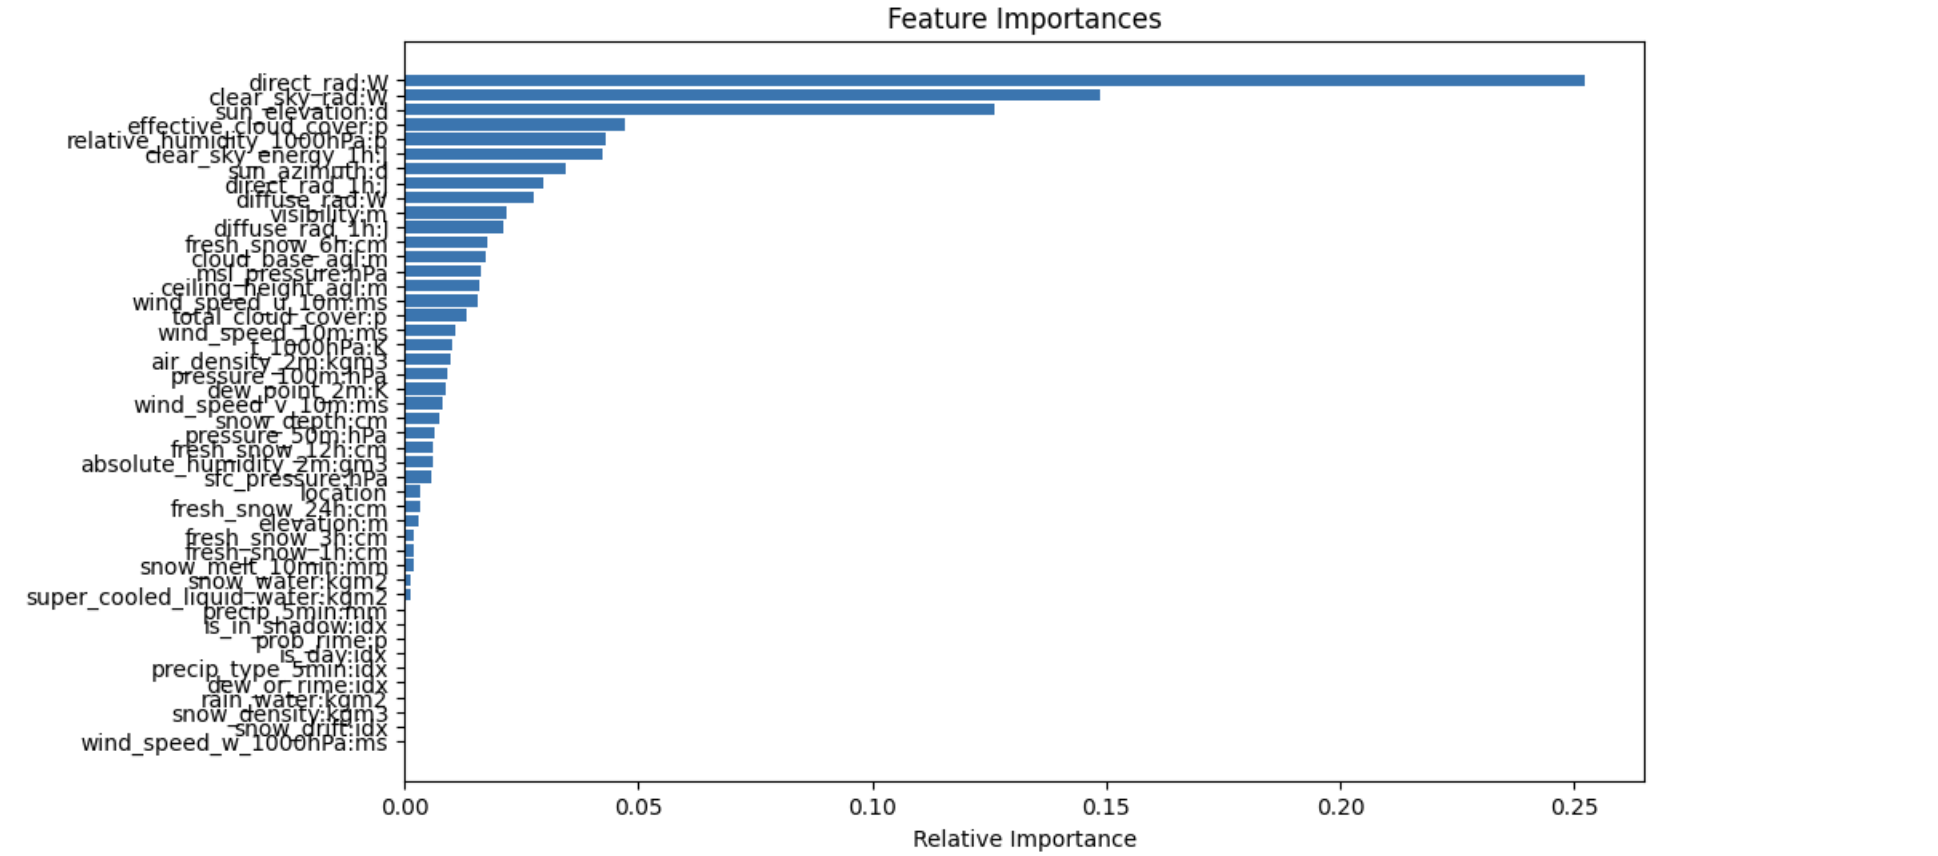

The correlation maps confirms the intuition.

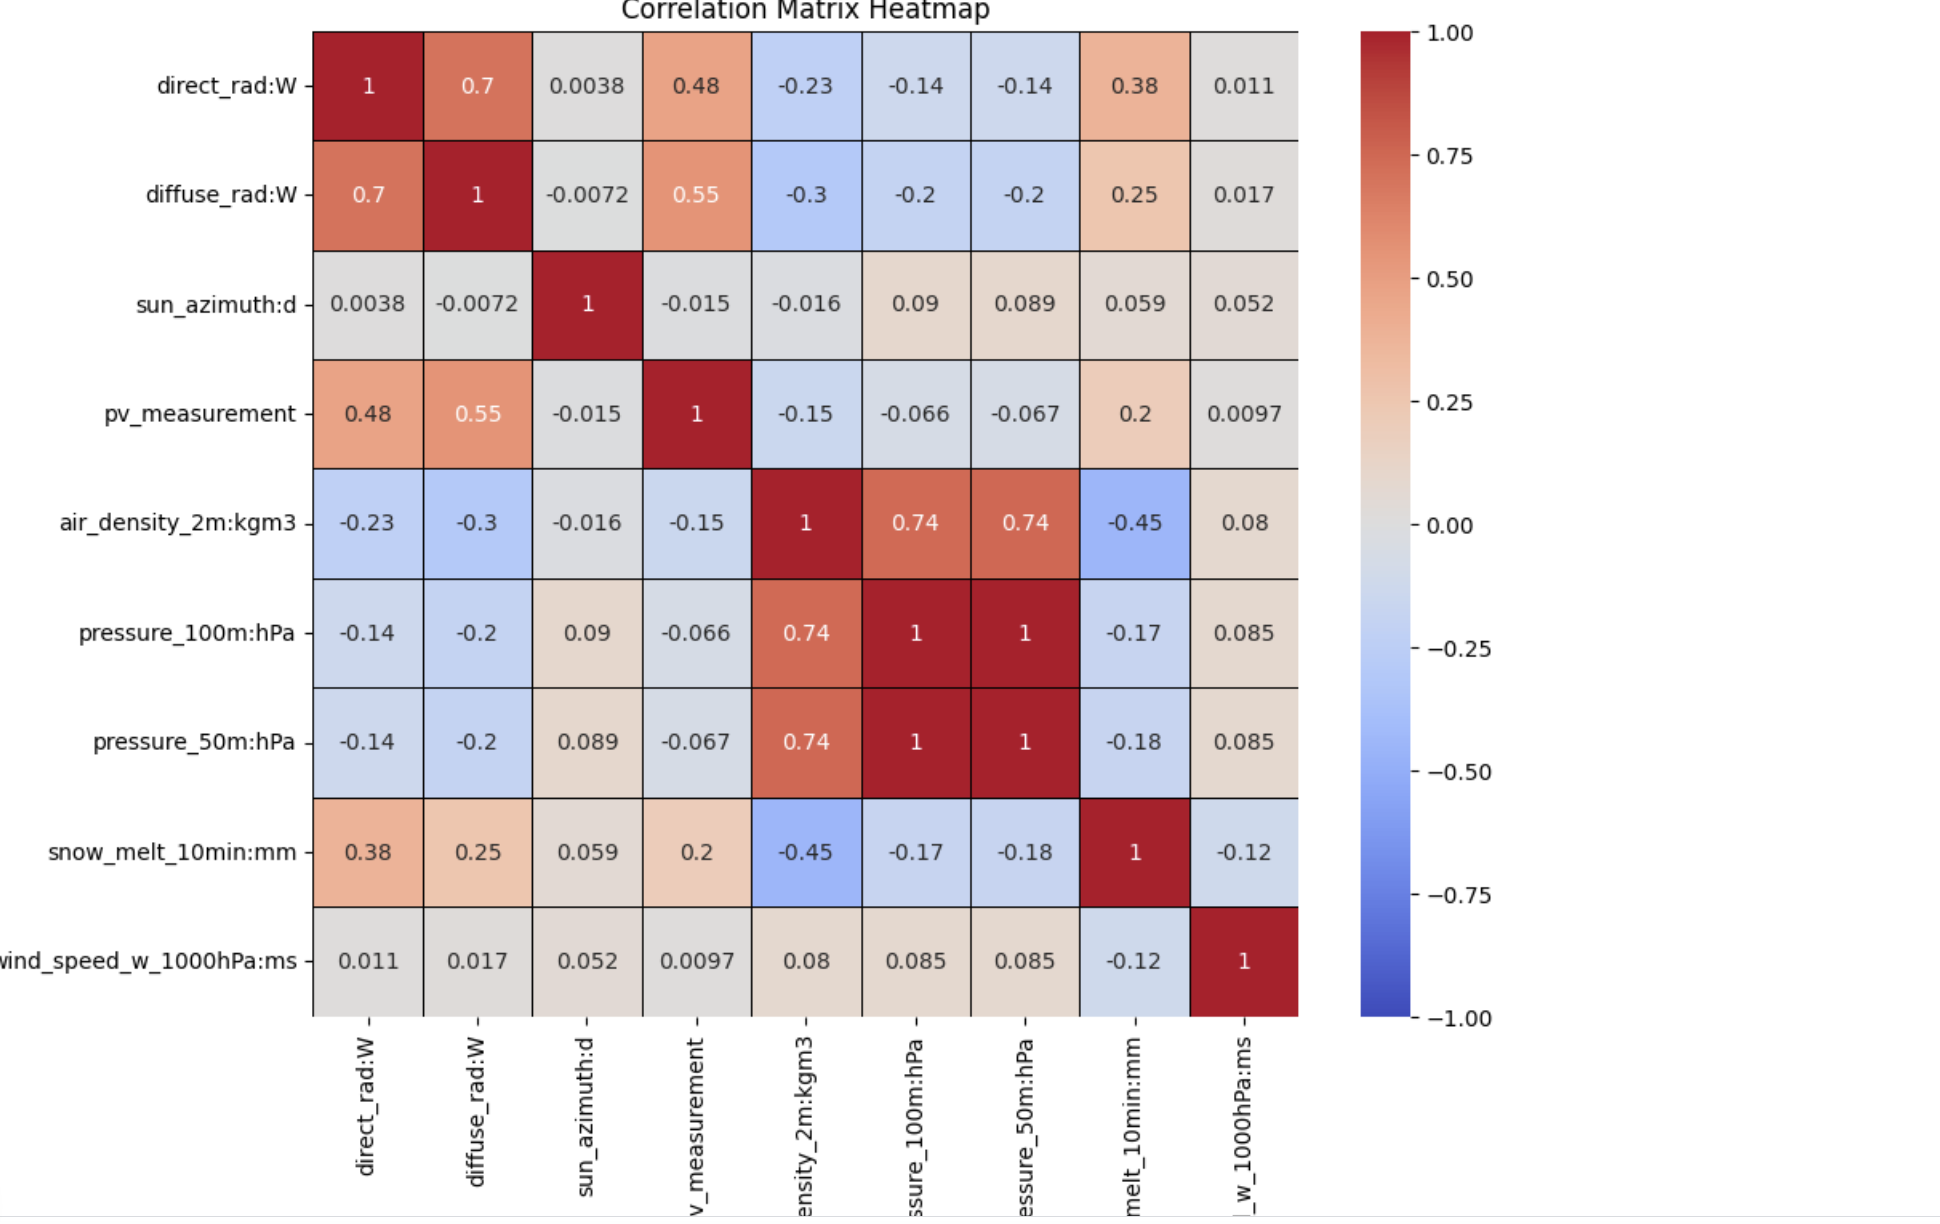

As expected the direct radiation appears to be the most important features, which leads us to believe we should work on enhancing it. The clear sky radiation, sun elevation and cloud cover also seem to contribute to energy productino.

In [ ]:
df = merged_df

# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df['date_forecast'], df['clear_sky_energy_1h:J'])
plt.xlabel('Date Forecast')
plt.ylabel('Clear Sky Energy 1h (J)')
plt.title('Time Series of Clear Sky Energy 1h')
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['air_density_2m:kgm3'], kde=True)
plt.title('Distribution of Air Density at 2m')
plt.show()

# Scatter Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='direct_rad:W', y='sun_elevation:d', data=df)
plt.title('Direct Radiation vs Sun Elevation')
plt.show()

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['visibility:m'])
plt.title('Box Plot of Visibility')
plt.show()

# Bar Chart for categorical data
dew_rime_counts = df['dew_or_rime:idx'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=dew_rime_counts.index, y=dew_rime_counts.values)
plt.title('Frequency of Dew or Rime Indices')
plt.show()

In the above graphs we define some visualization in order to ensure the level of intuitivity of the data, to begin with we analysed the time series distribution of clear sky energy on hourly rates, then considered the distribution of air density, plotted the sun radiation vs the sun elevation, visbility and dew or rime indexes. It all seems to follow the expected patterns.

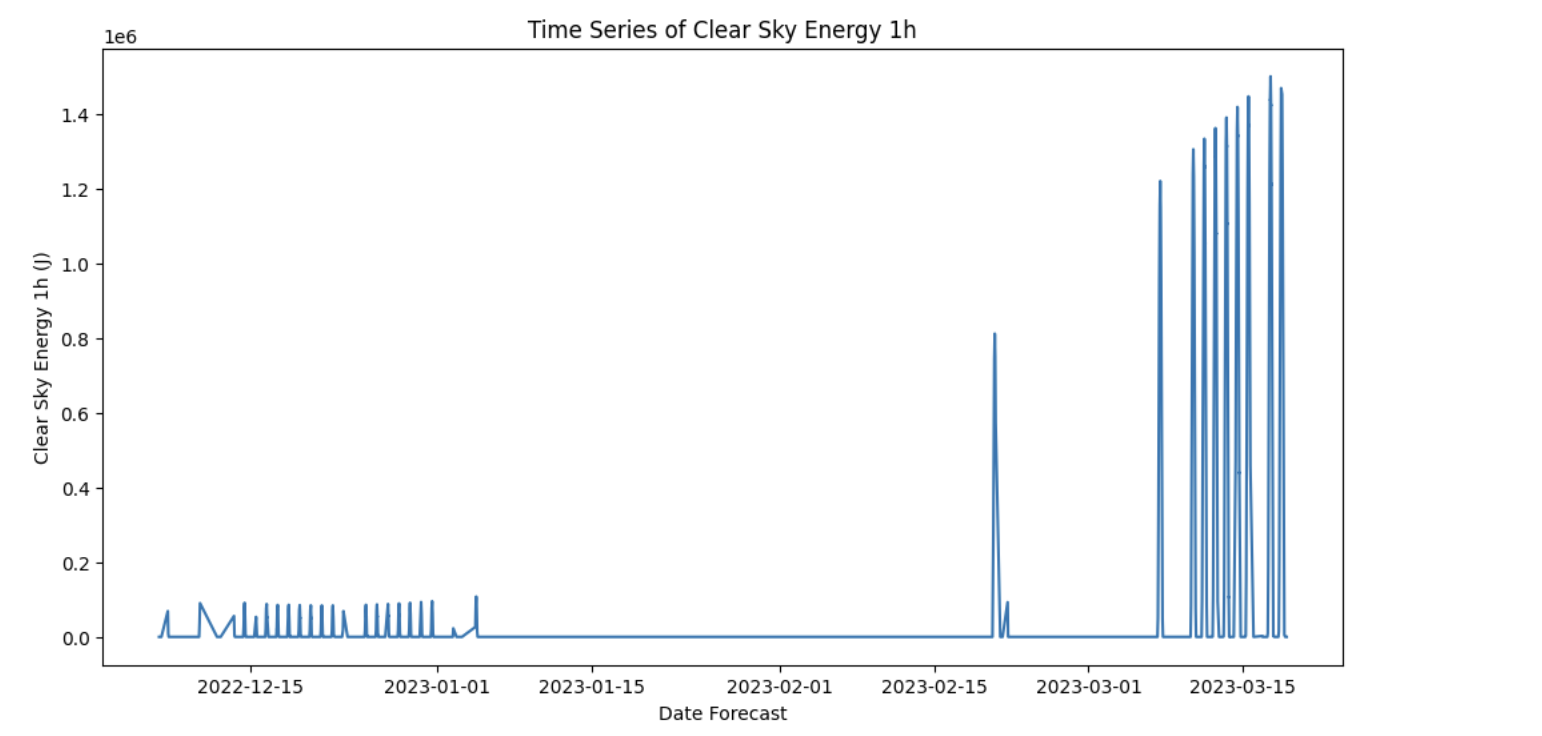
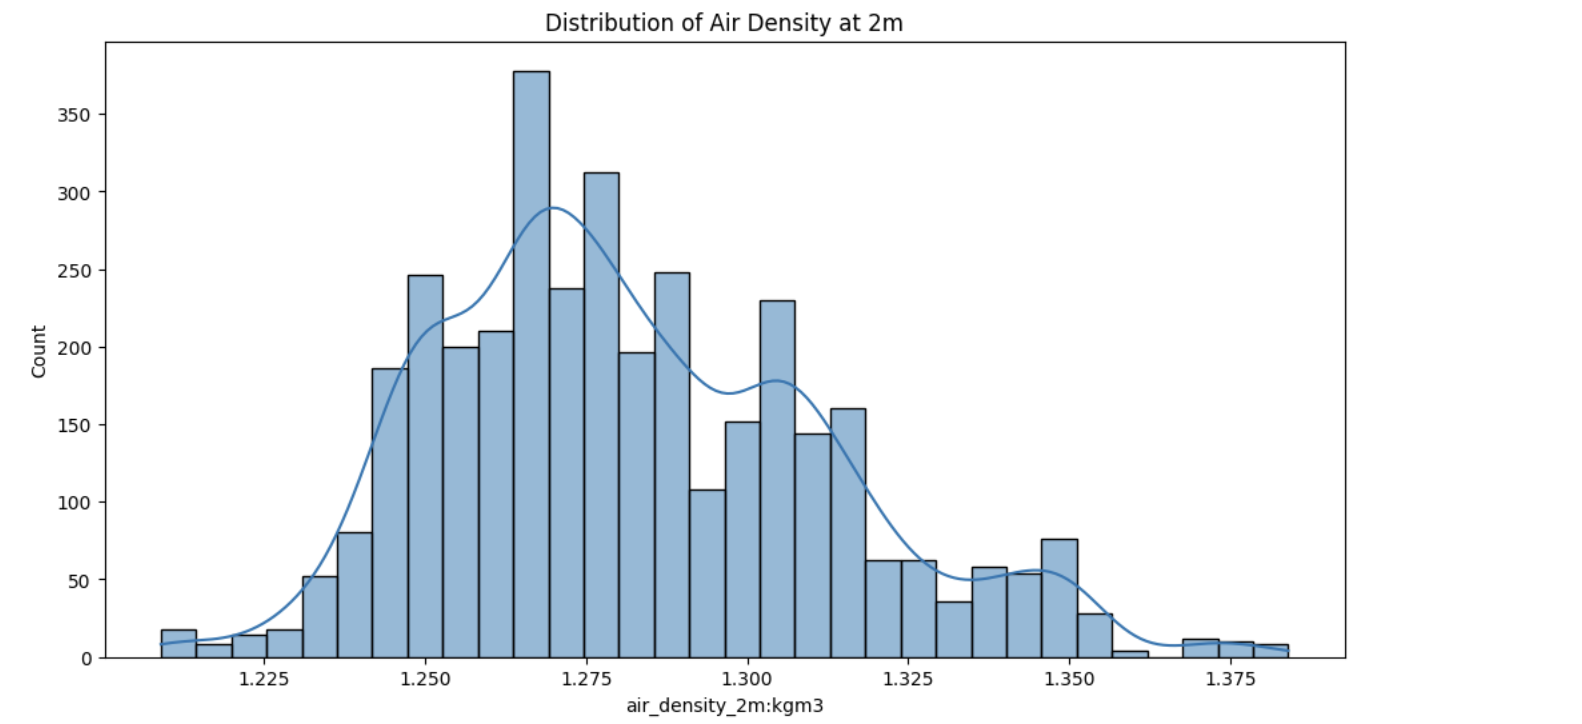
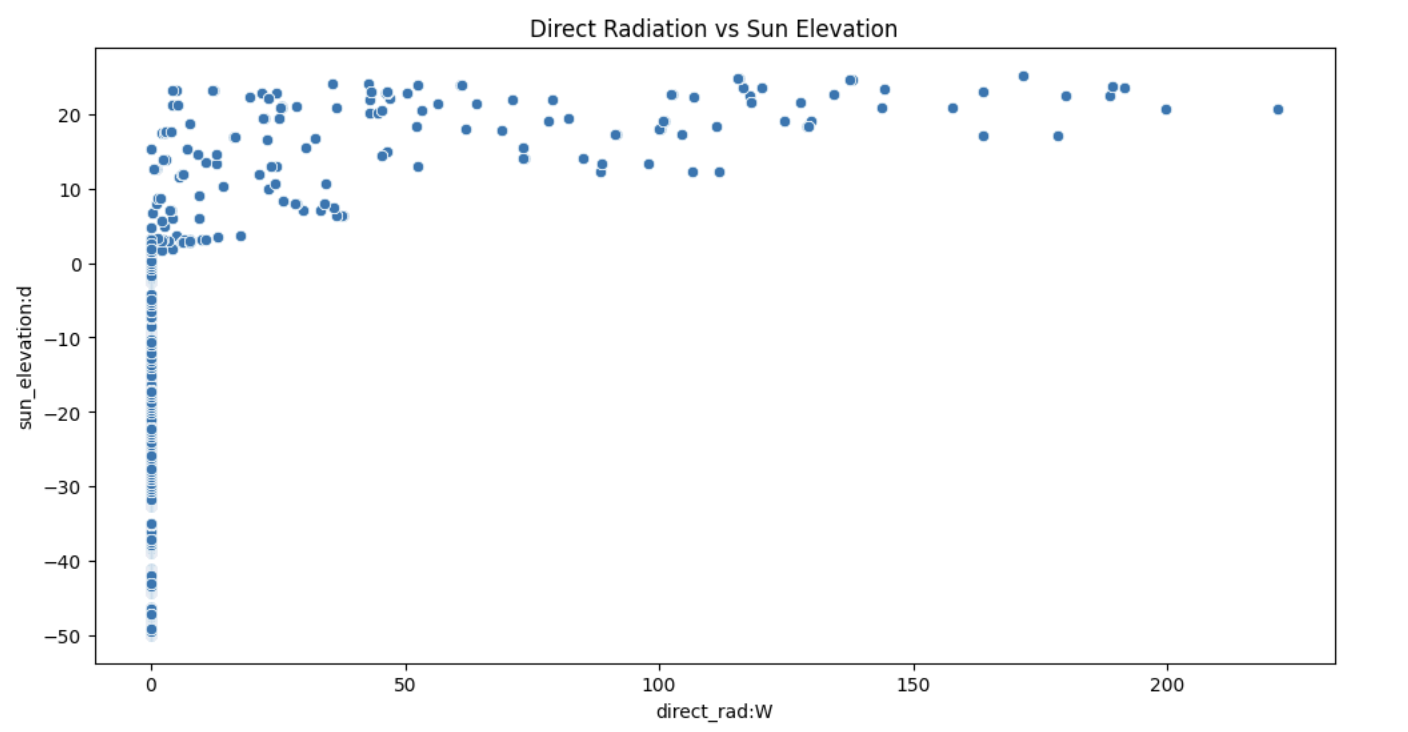
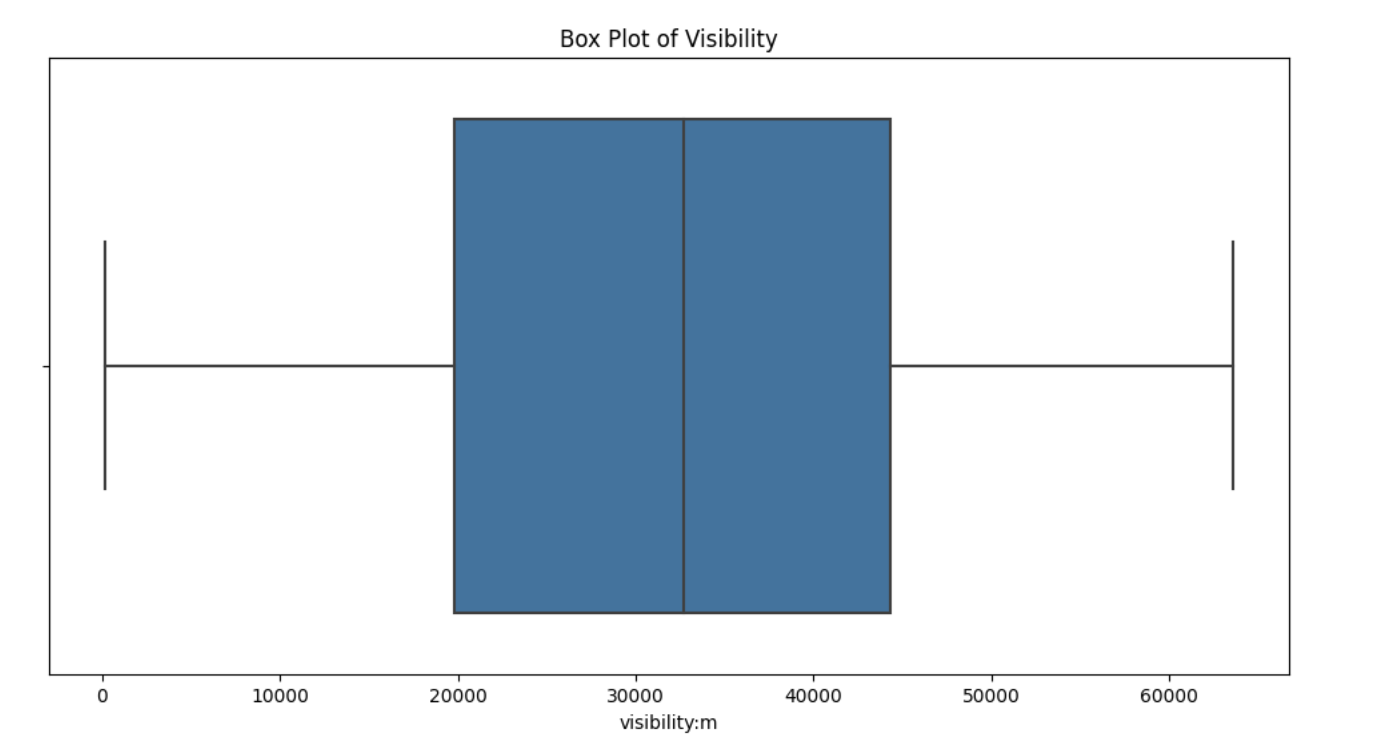
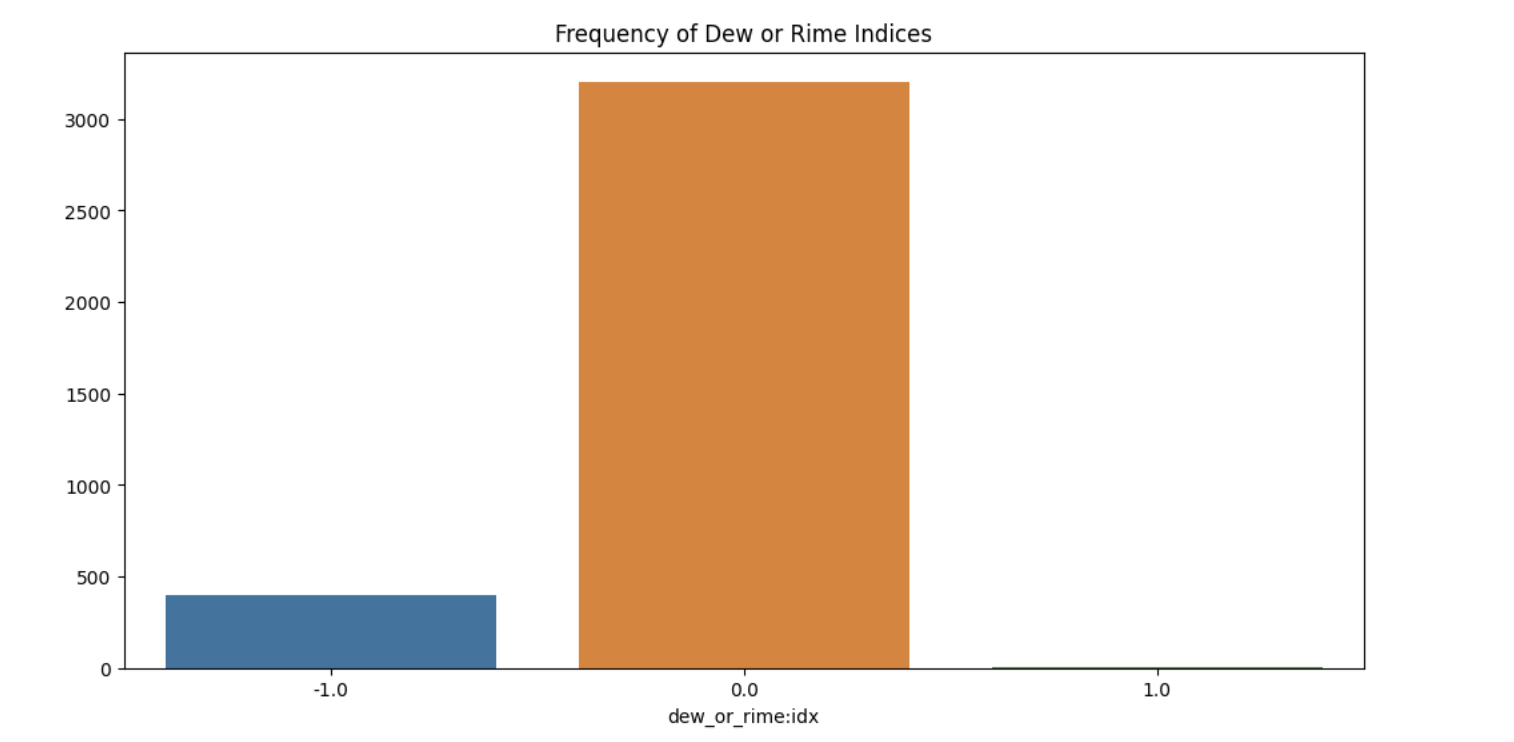

<a id="section3"></a>

# Attempted models with Costumised Feature Engineering and model interpretation

<a id="subsection.1"></a>

## RNN Predictor with one location and feature engineering ( outliers removal, filtering of most relevant features by pure logic)

The dataset in this undergoes preprocessing where a custom function remove_outliers is utilized to cleanse the data of anomalies, employing either z-score or Interquartile Range (IQR) methods based on a specified threshold. We believed this step could beneficial in ensuring unneccessary or "noise" like points were eliminated.

We conducted some logical feature selection: we assumed that the most important features were going to be directly defined by those connected to radiation values such as 'direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d'. Direct and diffuse radiation are known to significantly impact PV efficiency, while the sun's azimuth provides information about the sun's position in the sky, which can influence the amount of solar radiation received by the PV panels.


In order to conclude the model data scaling is performed using StandardScaler, a technique that normalizes features by removing the mean and scaling to unit variance. 


Epoch 1/50
161/161 [==============================] - 1s 3ms/step - loss: 14.5779 - val_loss: 12.0310
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 13.9809 - val_loss: 11.5930
Epoch 3/50
161/161 [==============================] - 0s 2ms/step - loss: 13.4730 - val_loss: 11.0849
Epoch 4/50
161/161 [==============================] - 0s 2ms/step - loss: 13.0589 - val_loss: 10.5174
Epoch 5/50
161/161 [==============================] - 0s 2ms/step - loss: 12.7791 - val_loss: 10.3444
Epoch 6/50
161/161 [==============================] - 0s 2ms/step - loss: 12.5133 - val_loss: 10.0205
Epoch 7/50
161/161 [==============================] - 1s 5ms/step - loss: 12.4027 - val_loss: 9.7741
Epoch 8/50
161/161 [==============================] - 0s 2ms/step - loss: 12.1245 - val_loss: 9.7890
Epoch 9/50
161/161 [==============================] - 0s 2ms/step - loss: 12.0848 - val_loss: 9.6040
Epoch 10/50
161/161 [==============================] - 0s 2ms/step - loss: 12.0346 - 

c:\Users\Utente\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(1284, 1)


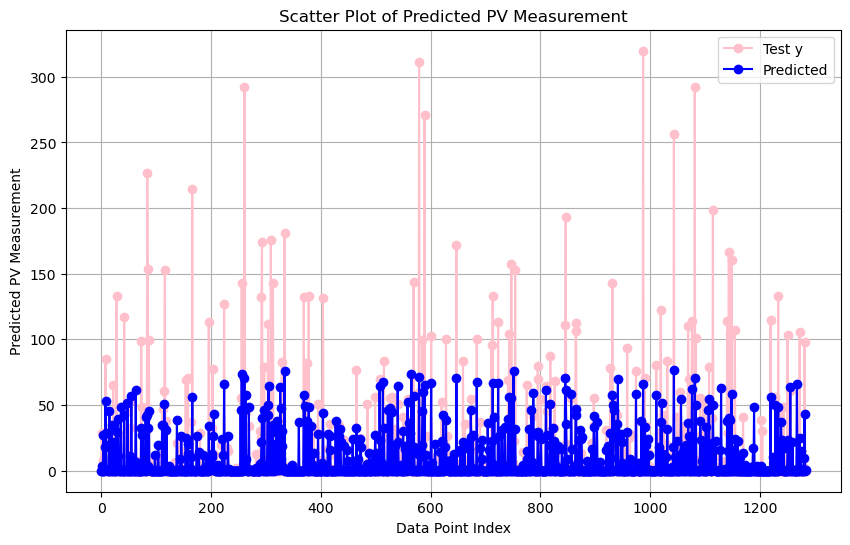

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define a function to remove outliers
def remove_outliers(data, columns, threshold=2, method='z-score'):
    if method == 'z-score':
        z_scores = np.abs((data[columns] - data[columns].mean()) / data[columns].std())
        filtered_data = data[(z_scores < threshold).all(axis=1)]
    elif method == 'IQR':
        Q1 = data[columns].quantile(0.25)
        Q3 = data[columns].quantile(0.75)
        IQR = Q3 - Q1
        filtered_data = data[~((data[columns] < (Q1 - 1.5 * IQR)) | (data[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    else:
        raise ValueError("Method not recognized. Please use 'z-score' or 'IQR'.")
    
    return filtered_data


# Location B
train_targets = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet('data/B/X_test_estimated.parquet')

# Combine training data
X_train = pd.concat([X_train_observed, X_train_estimated], axis=0)
X_train = X_train.drop(columns=['date_calc'])

# Process testing data
X_test_df = X_test_estimated.drop(columns=['date_calc'])

# Merge dataframes based on the time column
merged_df = pd.merge(X_train, train_targets, left_on='date_forecast', right_on='time', how='inner')
merged_df = merged_df.drop(columns=['time'])

# List of columns to consider
columns_to_check = ['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d', 'pv_measurement']
filtered_df = remove_outliers(merged_df, columns_to_check)

# Prepare the data
selected_X = filtered_df[['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d']]
selected_y = filtered_df[['pv_measurement']]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y, test_size=test_size, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create overlapping sequences
sequence_length = 5

X_train_seqs, y_train_seqs = [], []

for i in range(len(X_train_scaled) - sequence_length + 1):
    X_train_seqs.append(X_train_scaled[i:i+sequence_length])
    y_train_seqs.append(y_train.iloc[i+sequence_length-1])

X_train_seqs = np.array(X_train_seqs)
y_train_seqs = np.array(y_train_seqs)

# Split test data into sequences
X_test_seqs, y_test_seqs = [], []

for i in range(len(X_test) - sequence_length + 1):
    X_test_seqs.append(X_test_scaled[i:i+sequence_length])
    y_test_seqs.append(y_test.iloc[i+sequence_length-1])

X_test_seqs = np.array(X_test_seqs)
y_test_seqs = np.array(y_test_seqs)

# Build the model
model = keras.Sequential([
    layers.SimpleRNN(32, activation='tanh', input_shape=(sequence_length, X_train_seqs.shape[2])),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
initial_learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Define callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(X_train_seqs, y_train_seqs, epochs=50, batch_size=32, validation_data=(X_test_seqs, y_test_seqs),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
mae = model.evaluate(X_test_seqs, y_test_seqs)
print(f"Mean Absolute Error (MAE): {mae}")

# Save the model
model.save('final_model.h5')

y_pred = model.predict(X_test_seqs)
print(y_pred.shape)

# Create a scatter plot for the predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_seqs)),y_test_seqs, c='pink', marker='o', label='Test y')
plt.plot(range(len(y_pred)), y_pred, c='blue', marker='o', label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted PV Measurement')
plt.title('Scatter Plot of Predicted PV Measurement')
plt.legend()
plt.grid(True)

As shown the attempted was not very successful, as it was heavily underestimating the data, leading us to believe we were underfitting.

<a id="subsection3.2"></a>

## RNN predictor (merged locations) and Feature Engineering (same as above, with label encoding of the lcoation and stricter IQR)

Outlier handling in this version is defined to be more aggressive than before, as the interquartile range (IQR) calculated between the 15th and 85th percentiles is used as a threshold. 

The selection of 'direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d', and 'location' as predictors is based on literature expressing the importnce of considering the sun's position and intensiveness when predicting.

The inclusion of a location feature also made it necessary to use label encoding to transform this categorical data into a numerical format suitable for the neural network. This preprocessing step is critical since neural networks require numerical input. Following this, the selected features undergo standardization, ensuring that each feature contributes proportionately to the model's learning process, which is particularly beneficial for gradient-based optimization methods like Adam.


       direct_rad:W  diffuse_rad:W  sun_azimuth:d location
16979     50.599998      31.900000     193.242004        C
2713       0.000000      12.300000     161.970001        A
18382      0.000000      11.400000     187.169998        C
8591       0.000000       0.000000     326.937988        A
15915      0.000000     123.599998     156.042999        B
Epoch 1/50
161/161 [==============================] - 1s 3ms/step - loss: 14.5772 - val_loss: 12.0845
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 14.0606 - val_loss: 11.7333
Epoch 3/50
161/161 [==============================] - 0s 2ms/step - loss: 13.6134 - val_loss: 11.3035
Epoch 4/50
161/161 [==============================] - 0s 2ms/step - loss: 13.2577 - val_loss: 10.9641
Epoch 5/50
161/161 [==============================] - 0s 2ms/step - loss: 12.7483 - val_loss: 10.4222
Epoch 6/50
161/161 [==============================] - 0s 2ms/step - loss: 12.3288 - val_loss: 10.1095
Epoch 7/50
161/161 [==============

c:\Users\Utente\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 921us/step
(1284, 1)


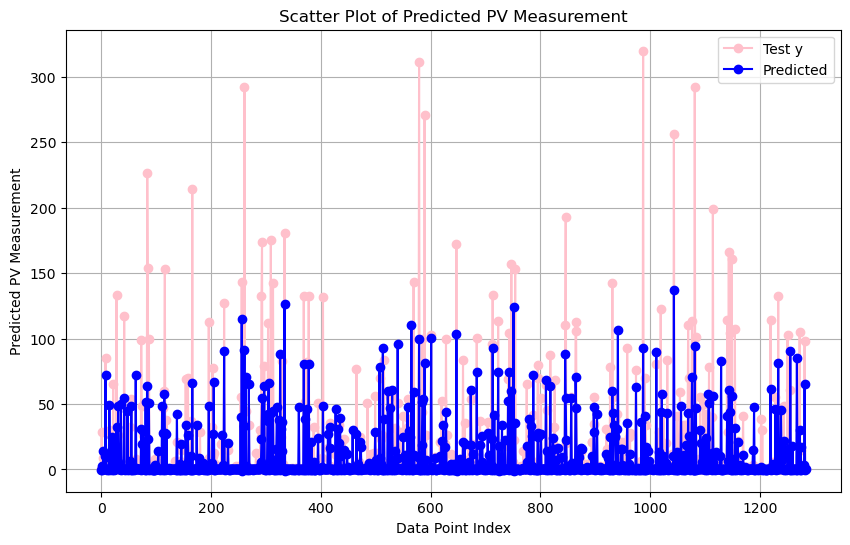

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define a function to remove outliers
def remove_outliers(data, columns, threshold=2, method='IQR'):
    if method == 'z-score':
        z_scores = np.abs((data[columns] - data[columns].mean()) / data[columns].std())
        filtered_data = data[(z_scores < threshold).all(axis=1)]
    elif method == 'IQR':
        Q1 = data[columns].quantile(0.15)
        Q3 = data[columns].quantile(0.85)
        IQR = Q3 - Q1
        filtered_data = data[~((data[columns] < (Q1 - 1.5 * IQR)) | (data[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    else:
        raise ValueError("Method not recognized. Please use 'z-score' or 'IQR'.")
    
    return filtered_data

def create_sequences(X_train_scaled, y_train, sequence_length):
    X_train_seqs = []
    y_train_seqs = []

    for i in range(len(X_train_scaled) - sequence_length + 1):
        X_train_seqs.append(X_train_scaled[i:i+sequence_length])
        y_train_seqs.append(y_train.iloc[i+sequence_length-1])

    return X_train_seqs, y_train_seqs


# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 'A'
X_train_estimated_A['location'] = 'A'
X_train_observed_A['location'] = 'A'
train_targets_A['location'] = 'A'

X_test_estimated_B['location'] = 'B'
X_train_estimated_B['location'] = 'B'
X_train_observed_B['location'] = 'B'
train_targets_B['location'] = 'B'

X_test_estimated_C['location'] = 'C'
X_train_estimated_C['location'] = 'C'
X_train_observed_C['location'] = 'C'
train_targets_C['location'] = 'C'

# Concatenate the datasets for X_test_estimated
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])
train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Combine training data
X_train = pd.concat([X_train_observed, X_train_estimated], axis=0)
X_train = X_train.drop(columns=['date_calc'])

# Merge dataframes based on the time column
merged_df = pd.merge(X_train, train_targets, left_on=['date_forecast', 'location'], right_on=['time', 'location'], how='inner')
merged_df = merged_df.drop(columns=['time'])

# Drop rows with NaN values in the 'location' column
merged_df = merged_df.dropna(subset=['location'])

# List of columns to consider
columns_to_check = ['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d', 'pv_measurement']
filtered_df = remove_outliers(merged_df, columns_to_check)

# Prepare the data
selected_X = filtered_df[['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d', 'location']]
selected_y = filtered_df[['pv_measurement']]

test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y, test_size=test_size, random_state=42)

print(X_train.head())

# Encode 'location' as categorical
label_encoder = LabelEncoder()
X_train['location'] = label_encoder.fit_transform(X_train['location'])
X_test['location'] = label_encoder.transform(X_test['location'])

# Assuming X_train is your DataFrame
selected_columns = ['direct_rad:W', 'diffuse_rad:W', 'sun_azimuth:d']

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the selected columns
X_train[selected_columns] = scaler.fit_transform(X_train[selected_columns])
X_test[selected_columns] = scaler.fit_transform(X_test[selected_columns])

X_train_scaled=X_train
X_test_scaled=X_test

# Create overlapping sequences
sequence_length = 5

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)

X_train_seqs = np.array(X_train_seqs)
y_train_seqs = np.array(y_train_seqs)

# Split test data into sequences
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)

X_test_seqs = np.array(X_test_seqs)
y_test_seqs = np.array(y_test_seqs)

# Build the model
model = keras.Sequential([
    layers.SimpleRNN(32, activation='relu', input_shape=(sequence_length, X_train_seqs.shape[2])),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
initial_learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Define callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(X_train_seqs, y_train_seqs, epochs=50, batch_size=32, validation_data=(X_test_seqs, y_test_seqs),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
mae = model.evaluate(X_test_seqs, y_test_seqs)
print(f"Mean Absolute Error (MAE): {mae}")

# Save the model
model.save('final_model.h5')

y_pred = model.predict(X_test_seqs)
print(y_pred.shape)

# Create a scatter plot for the predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_seqs)),y_test_seqs, c='pink', marker='o', label='Test y')
plt.plot(range(len(y_pred)), y_pred, c='blue', marker='o', label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted PV Measurement')
plt.title('Scatter Plot of Predicted PV Measurement')
plt.legend()
plt.grid(True)

Once again, we have slightly bettered the final evaluation but we are still heavily underfitting.


<a id="subsection3.3"></a>

## First attempt at LightGBM with corresponding Feature Engineering ( Enconding of the location variable, concatenation of the training set, removal of flat stretches, observance of intuitive ideas: seasonal influence on Energy production, feature importance, removal of NaN and outliers)




<bound method NDFrame.head of                      time  pv_measurement  location
0     2019-06-02 22:00:00            0.00         0
1     2019-06-02 23:00:00            0.00         0
2     2019-06-03 00:00:00            0.00         0
3     2019-06-03 01:00:00            0.00         0
4     2019-06-03 02:00:00           19.36         0
...                   ...             ...       ...
32150 2023-04-30 19:00:00           50.96         2
32151 2023-04-30 20:00:00            2.94         2
32152 2023-04-30 21:00:00            0.00         2
32153 2023-04-30 22:00:00           -0.00         2
32154 2023-04-30 23:00:00           -0.00         2

[99088 rows x 3 columns]>


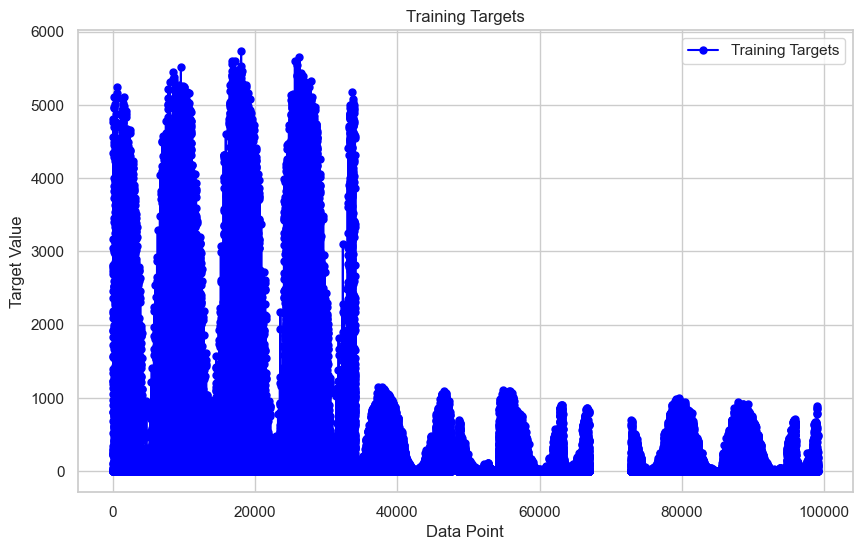

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\2982869660.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_targets_cleaned_var['pv_measurement'].iloc[flat_indices] = np.nan


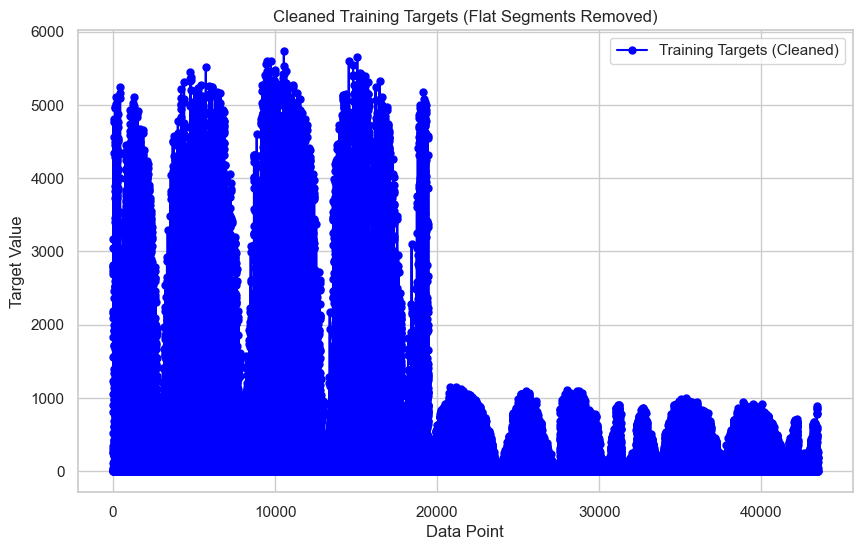

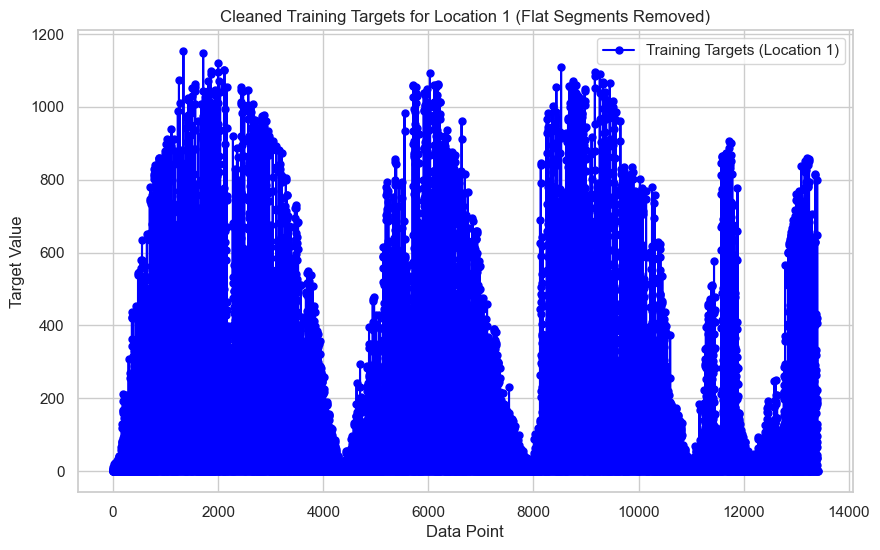

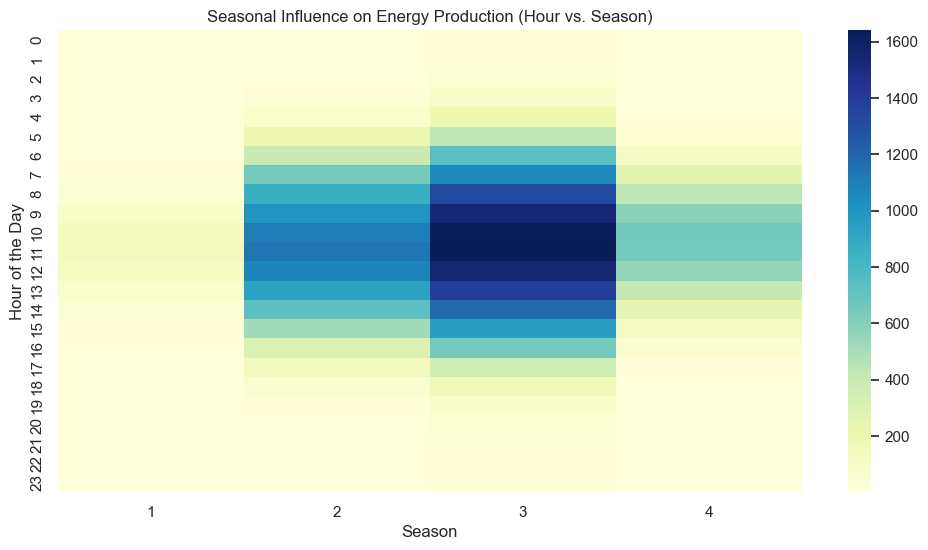

(26364, 43)
<bound method NDFrame.head of          date_forecast_00  absolute_humidity_2m:gm3_00  \
0     2022-10-28 22:00:00                          8.4   
1     2022-10-28 23:00:00                          8.2   
2     2022-10-29 00:00:00                          8.2   
3     2022-10-29 01:00:00                          8.1   
4     2022-10-29 02:00:00                          8.3   
...                   ...                          ...   
26359 2023-04-30 19:00:00                          4.4   
26360 2023-04-30 20:00:00                          4.4   
26361 2023-04-30 21:00:00                          4.4   
26362 2023-04-30 22:00:00                          4.4   
26363 2023-04-30 23:00:00                          4.4   

       air_density_2m:kgm3_00  clear_sky_energy_1h:J_00  clear_sky_rad:W_00  \
0                       1.233                  0.000000                 0.0   
1                       1.233                  0.000000                 0.0   
2                       

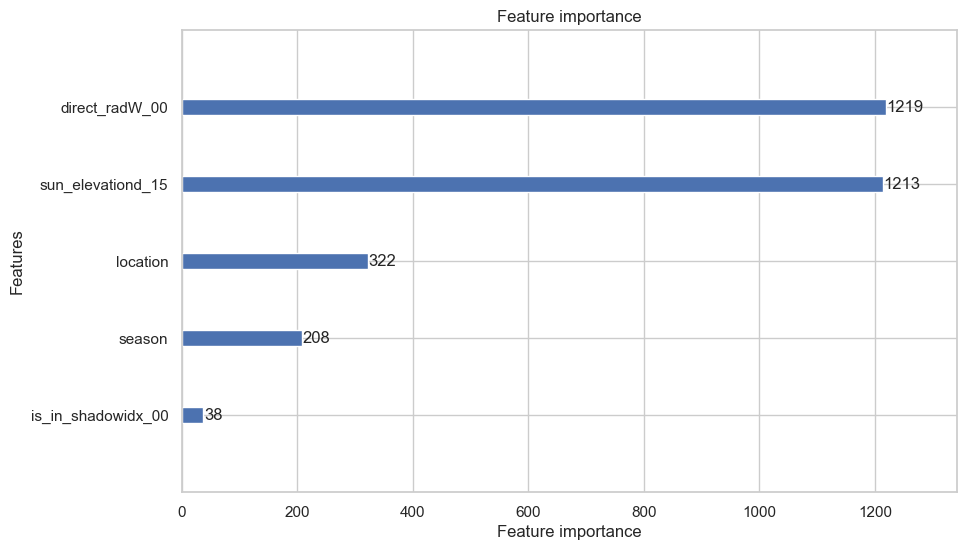

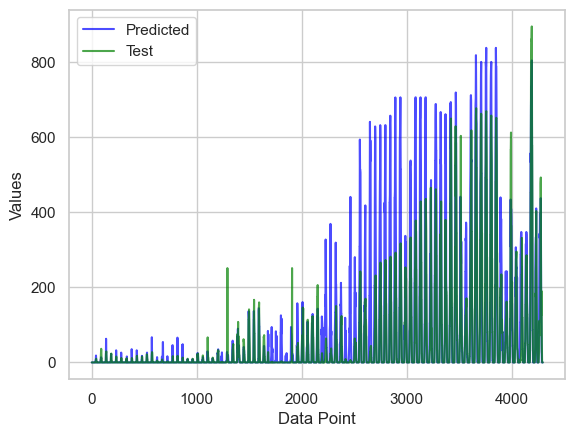

In [57]:
# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 0
X_train_estimated_A['location'] = 0
X_train_observed_A['location'] = 0
train_targets_A['location'] = 0

X_test_estimated_B['location'] = 1
X_train_estimated_B['location'] = 1
X_train_observed_B['location'] = 1
train_targets_B['location'] = 1

X_test_estimated_C['location'] = 2
X_train_estimated_C['location'] = 2
X_train_observed_C['location'] = 2
train_targets_C['location'] = 2

# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])

train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

print(train_targets.head)


Our first step involves plotting the target values to get a clear visual representation of the data. This step is crucial for identifying patterns and anomalies in the initial dataset. The next step focuses on cleaning the data by removing missing values and outliers. Outliers are detected using z-scores, a statistical measure that helps to identify and exclude data points that are significantly different from the rest. This helps in maintaining the integrity of the dataset.

Subsequently, the code attempts to identify and remove flat segments in the data, where consecutive readings do not change. These flat segments could mislead the model into thinking that no change is the norm, which is not ideal when modeling environmental data that naturally exhibits fluctuations.

The data is then organized by location, allowing for a tailored analysis for each area. This is essential as solar energy generation is heavily influenced by local weather conditions.

Time data is converted into more useful features. The 'time' column is transformed into datetime format, enabling the extraction of hours and months, which are then used to derive features such as 'season' and 'central_hours'. These new features are expected to capture seasonal and daily cycles in the data, which are important for predicting PV output.

Finally, the dataset is streamlined by removing irrelevant or sparse features. This step ensures that the model is trained only on features that are likely to be predictive of PV output.

In [ ]:

# Generate x values for the plot (e.g., index or time steps)
x_values = np.arange(len(train_targets))

# Create a line plot
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.plot(x_values, train_targets['pv_measurement'], label='Training Targets', color='blue', marker='o', markersize=5)
plt.title('Training Targets')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
  
# Remove NaN Values
train_targets_cleaned = train_targets.dropna(subset=['pv_measurement'])

# Calculate the z-scores for each data point
z_scores = np.abs(stats.zscore(train_targets['pv_measurement']))

# Set a threshold for z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold as needed

# Create a mask to identify outliers
outlier_mask = z_scores > z_score_threshold

# Filter the DataFrame to remove outliers
filtered_train_targets = train_targets[~outlier_mask]

# Define an appropriate threshold for detecting flat segments
threshold = 0.0001  

# Calculate differences between consecutive values
diff = np.diff(train_targets_cleaned['pv_measurement'])

# Find indices of flat segments based on the threshold
flat_indices = np.where(np.abs(diff) <= threshold)[0]

# Create a cleaned copy of the DataFrame
train_targets_cleaned_var = train_targets_cleaned.copy()

# Remove flat segments using indexing
train_targets_cleaned_var['pv_measurement'].iloc[flat_indices] = np.nan

# Remove NaN Values
train_targets_cleaned_var.dropna(subset=['pv_measurement'], inplace=True)

# Create a Line Plot of the Cleaned 'pv_measurement' Column
x_values = range(len(train_targets_cleaned_var))
plt.figure(figsize=(10, 6))
plt.plot(x_values, train_targets_cleaned_var['pv_measurement'], label='Training Targets (Cleaned)', color='blue', marker='o', markersize=5)
plt.title('Cleaned Training Targets (Flat Segments Removed)')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

# Filter 'train_targets' Based on the 'location' Feature
train_targets_location_1 = train_targets_cleaned_var[train_targets_cleaned_var['location'] == 1]

# Create a Line Plot of the 'pv_measurement' Column for Location 1
x_values = range(len(train_targets_location_1))
plt.figure(figsize=(10, 6))
plt.plot(x_values, train_targets_location_1['pv_measurement'], label='Training Targets (Location 1)', color='blue', marker='o', markersize=5)
plt.title('Cleaned Training Targets for Location 1 (Flat Segments Removed)')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

train_targets = train_targets_cleaned

# Convert 'time' column to datetime and set it as the index
train_targets['time'] = pd.to_datetime(train_targets['time'])
train_targets.set_index('time', inplace=True)

# Extract the hour and month/season from the index
train_targets['hour'] = train_targets.index.hour
train_targets['month'] = train_targets.index.month

# Seasonal factor: divide the year into seasons (e.g., 4 for spring, summer, fall, winter)
# Adjust this as per your definition of seasons
train_targets['season'] = (train_targets['month'] % 12 + 3) // 3

# Create a pivot table to analyze the data by hour and season
pivot_table = train_targets.pivot_table(index='hour', columns='season', values='pv_measurement', aggfunc='mean')

# Create a heatmap to visualize the seasonality
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', cbar=True)
plt.title("Seasonal Influence on Energy Production (Hour vs. Season)")
plt.xlabel("Season")
plt.ylabel("Hour of the Day")
plt.show()


# Create new features
train_targets['central_hours'] = (train_targets['hour'] >= 10) & (train_targets['hour'] <= 14)

# Seasonal factor: divide the year into seasons (e.g., 4 for spring, summer, fall, winter)
# Adjust this as per your definition of seasons
train_targets['season'] = (train_targets['month'] % 12 + 3) // 3

# These new features will have binary values (True/False) based on the conditions
# central_hours: True if the hour is between 10 and 14, False otherwise
# high_seasons: True if the season is 2 or 3, False otherwise

# Convert these features to binary (0 or 1) if needed
train_targets['central_hours'] = train_targets['central_hours'].astype(int)
train_targets['season'] = train_targets['season'].astype(int)

X_train = pd.concat([X_train_estimated, X_train_observed])

# Drop date_calculation
X_train = X_train.drop(columns=['date_calc'])

# Drop features with a significant number of missing values
X_train = X_train.drop(['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'], axis=1)

# Drop snow features (forecast is hourly)
X_train = X_train.drop(columns=['fresh_snow_12h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm'])
X_train['precipitation_type'] = X_train['precip_type_5min:idx'].map({0: 0, 1: 1, 2: 2})

# Drop the altitude feature: it is strictly correlated with the location feature
X_train = X_train.drop(columns=['elevation:m'])
X_train = X_train.drop(columns = ['wind_speed_w_1000hPa:ms'])

# Assuming X_train is your DataFrame
# Extract hour, minute, day, and month as separate columns
X_train['hour'] = X_train['date_forecast'].dt.hour
X_train['minute'] = X_train['date_forecast'].dt.minute
X_train['day'] = X_train['date_forecast'].dt.day
X_train['month'] = X_train['date_forecast'].dt.month

# Initialize four empty DataFrames for each minute value
df_00 = X_train[X_train['minute'] == 0].copy()
df_15 = X_train[X_train['minute'] == 15].copy()
df_30 = X_train[X_train['minute'] == 30].copy()
df_45 = X_train[X_train['minute'] == 45].copy()

# Reset index for each of the minute DataFrames
df_00.reset_index(drop=True, inplace=True)
df_15.reset_index(drop=True, inplace=True)
df_30.reset_index(drop=True, inplace=True)
df_45.reset_index(drop=True, inplace=True)

# Add suffix to column names in each df_min
df_00 = df_00.add_suffix("_00")
df_15 = df_15.add_suffix("_15")
df_30 = df_30.add_suffix("_30")
df_45 = df_45.add_suffix("_45")

print(df_45.shape)

# Concatenate the DataFrames horizontally (along columns)
result = pd.concat([df_00, df_15, df_30, df_45], axis=1)
result.rename(columns={'day_00': 'day', 'minute_00': 'minute', 'hour_00': 'hour', 'month_00': 'month', 'location_00': 'location'}, inplace=True)
result = result.drop(columns = ['day', 'month'])
result = result.drop(columns = ['date_forecast_15', 'date_forecast_30', 'date_forecast_45', 'minute_15', 'minute_30', 'minute_45'])
result = result.drop(columns = ['day_15', 'day_30', 'day_45', 'hour_15', 'hour_30', 'hour_45', 'month_15', 'month_30', 'month_45'])
result = result.drop(columns = ['location_15', 'location_30', 'location_45'])

print(result.head)

result.info()

# Merge based on 'time', 'date_forecast', and 'location' columns
merged_df = pd.merge(result, train_targets, left_on=['date_forecast_00', 'location'], right_on=['time', 'location'], how='inner')


# Set 'date_forecast' as the index
merged_df.set_index('date_forecast_00', inplace=True)
print(merged_df.head)
print(merged_df.shape)

print(merged_df.shape)

# Rename columns for LightGBM compatibility
merged_df = merged_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
merged_df = merged_df.dropna()

print(merged_df.shape)

selected_columns = ['location', 'sun_elevationd_15', 'direct_radW_00', 'season', 'is_dayidx_15', 'is_in_shadowidx_00']

# Define the features (X) and target (y)
X = merged_df.drop(columns=['pv_measurement'])
X = merged_df[selected_columns]
y = merged_df['pv_measurement']

# Split the data into training and testing sets
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(X_train.shape)

# Assuming you have your data in X and y, and X_test and y_test for testing
# Define the time split point (e.g., 80% of the data for training, 20% for testing)
split_time = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, y_train = X[:split_time], y[:split_time]
X_test, y_test = X[split_time:], y[split_time:]

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)

# Define hyperparameters and create the LightGBM model
params = {
    "objective": "regression_l1",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "n_estimators": 100,
    "random_state": 42
}

# Function to evaluate the model using cross-validation with MAE
def evaluate_model(X, y, params):
    model = lgb.LGBMRegressor(**params)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')  
    return -scores

mae_scores = evaluate_model(X, y, params)
print("Cross-Validation MAE scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

# Train the final model on the entire training dataset
lgb_regressor = lgb.LGBMRegressor(**params)
lgb_regressor.fit(X_train, y_train)

# Make predictions on the testing dataset
y_pred = lgb_regressor.predict(X_test)

# Evaluate the model using MAE on the testing dataset
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) on the testing dataset:", mae)

# Plot feature importance
lgb.plot_importance(lgb_regressor, figsize=(10, 6))
plt.show()

# Create an array of indices (x-values) for the data points
x_values = range(len(y_test))

# Plot the predicted values as a line with slight transparency
plt.plot(x_values, y_pred, label='Predicted', color='blue', alpha=0.7)

# Plot the test values as a line with slight transparency
plt.plot(x_values, y_test, label='Test', color='green', alpha=0.7)

# Add labels and a legend
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


<a id="subsection3.4"></a>

## Short notebook 2: LightGBM predictor with dedicated Feature Engineering (elimination of feature that do not logically appear useful, adding of resampling for the hour, date feature adding, observation of correlation pairs to individuate autocorrelation, hyperparameters from hypertuning)

The `preprocess_and_merge_data` function is designed to prepare and combine various datasets for photovoltaic (PV) power prediction. It starts by converting the time-related columns across all datasets to datetime objects for uniformity. Then, it resamples observed, estimated, and test data to an hourly frequency, using the mean as the aggregator and excluding rows where all values are missing.

Next, the function removes non-feature columns such as 'is_day:idx', 'snow_density:kgm3', and 'elevation:m' from the observed, estimated, and test datasets, as these are not used in the prediction model. It also narrows down the data to the months of April to August.

A significant step involves merging the observed and estimated weather data and then combining this with the target PV output values, ensuring alignment on the same time frames. The data is further refined by eliminating entries where the PV measurement is zero, which might indicate nighttime or system errors.

The code identifies and removes constant stretches in the data, where the PV output does not change over time, as these could affect the predictive quality of the model.

The `find_strong_correlation_pairs` function calculates a correlation matrix of the data and reports pairs of features with a correlation above a certain threshold. High correlation might indicate redundancy in the features, which can be a basis for feature selection or removal to improve model performance.

The `train_and_evaluate_lgbm` function splits the data into training and testing sets, then proceeds to train a LightGBM model using cross-validation to assess its performance, specifically looking at the mean absolute error (MAE) as a performance metric. The function prints out the cross-validation MAE scores and the average MAE to provide insights into the model's accuracy.

Finally, the function visualizes the predicted PV output against the actual values, using a line plot to compare the model's predictions on the test set against the observed data. 

In [43]:
def preprocess_and_merge_data(observed, estimated, test, targets):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    #print(test_resampled['date_forecast'])

    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
     # Drop the columns not used as features
    columns_to_drop = ['is_day:idx', 'snow_density:kgm3', 'elevation:m']
    test_resampled = test_resampled.drop(columns=columns_to_drop)
    observed_resampled = observed_resampled.drop(columns=columns_to_drop)
    estimated_resampled = estimated_resampled.drop(columns=columns_to_drop)

    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
 
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')


    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    #print(targets.dtypes)
    # Clean up auxiliary columns
    targets_new = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    plot_targets(targets_new, start_date, end_date)
    if observed_resampled.empty:
        print(f"observed_resampled is empty for location ")
    
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast'])

    print(test_resampled.dtypes)
    print(filtered_data.dtypes)
    
    return filtered_data, test_resampled, is_day_feature, targets_new

def find_strong_correlation_pairs(data, threshold=0.95):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Find pairs with strong correlation
    strong_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                strong_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Print pairs with strong correlation
    if strong_correlation_pairs:
        print("Pairs with strong correlation:")
        for pair in strong_correlation_pairs:
            print(f"{pair[0]} and {pair[1]} have a correlation of {correlation_matrix[pair[0]][pair[1]]}")
    else:
        print("No strong correlation pairs found.")
    
    print("\n")
    return strong_correlation_pairs

def train_and_evaluate_lgbm(X_train, y_train, test_size=0.3, random_state=42, num_folds = 5):
    # Split the data into training and testing sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train_split, label=y_train_split)

    # Define hyperparameters
    params = {
        "objective": "regression_l1",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "n_estimators": 100,
        "random_state": random_state
    }

    # Function to evaluate the model using cross-validation with MAE
    def evaluate_model(X, y, params, num_folds):
        model = lgb.LGBMRegressor(**params)
        scores = -cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_absolute_error')
        return scores

    mae_scores = evaluate_model(X_train_split, y_train_split, params, num_folds)
    print("Cross-Validation MAE scores:", mae_scores)
    print("Mean MAE:", np.mean(mae_scores))

    # Train the final model on the entire training dataset
    lgb_regressor = lgb.LGBMRegressor(**params)
    lgb_regressor.fit(X_train_split, y_train_split)

    # Make predictions on the testing dataset
    y_pred = lgb_regressor.predict(X_test_split)

    # Evaluate the model using MAE on the testing dataset
    mae = mean_absolute_error(y_test_split, y_pred)
    print("Mean Absolute Error (MAE) on the testing dataset:", mae)

    # Create an array of indices (x-values) for the data points
    x_values = range(len(y_test_split))

    # Plot the predicted values as a line with slight transparency
    plt.plot(x_values, y_pred, label='Predicted', color='blue', alpha=0.7)

    # Plot the test values as a line with slight transparency
    plt.plot(x_values, y_test_split, label='Test', color='green', alpha=0.7)

    # Add labels and a legend
    plt.xlabel('Data Point')
    plt.ylabel('Values')
    plt.legend()

    # Show the plot
    plt.show()

    return lgb_regressor



The `preprocess_and_merge_data` function cleans and combines several data sources to prepare for solar power prediction. It starts by converting all time columns to datetime format for consistency. Then, it aggregates data to hourly intervals, ignoring rows where all data points are missing.

The function drops irrelevant columns, then filters the observed and estimated datasets for specific months, likely to correspond with higher solar production periods. These datasets are merged to create a comprehensive weather dataset, which is then combined with the target solar power output, ensuring that the data corresponds to the same time period.

The merged dataset is further refined by removing data points where the solar power reading is zero—presumably times when there is no solar production, such as at night or during system errors. The data is also cleaned to remove periods of constant readings, which might indicate sensor malfunctions or other periods of inactivity that could skew the predictive model.

The `find_strong_correlation_pairs` function is a utility to identify pairs of features in the dataset that are strongly correlated beyond a specified threshold. Strong correlations can suggest redundancy, which might necessitate feature reduction to improve model efficiency.

The `train_and_evaluate_lgbm` function splits the data into training and test sets and trains a LightGBM regression model. It uses cross-validation to gauge the model's performance, specifically looking at the Mean Absolute Error (MAE) as an accuracy metric. After training, it makes predictions on the test set, calculates the MAE, and plots predicted versus actual values for visual comparison, which helps in assessing the model's prediction accuracy.

Finally, the LightGBM model is returned, which can then be used for further predictions or analysis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576 entries, 0 to 17575
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_calc                       17576 non-null  datetime64[ns]
 1   date_forecast                   17576 non-null  datetime64[ns]
 2   absolute_humidity_2m:gm3        17576 non-null  float32       
 3   air_density_2m:kgm3             17576 non-null  float32       
 4   ceiling_height_agl:m            13657 non-null  float32       
 5   clear_sky_energy_1h:J           17576 non-null  float32       
 6   clear_sky_rad:W                 17576 non-null  float32       
 7   cloud_base_agl:m                15482 non-null  float32       
 8   dew_or_rime:idx                 17576 non-null  float32       
 9   dew_point_2m:K                  17576 non-null  float32       
 10  diffuse_rad:W                   17576 non-null  float32       
 11  di

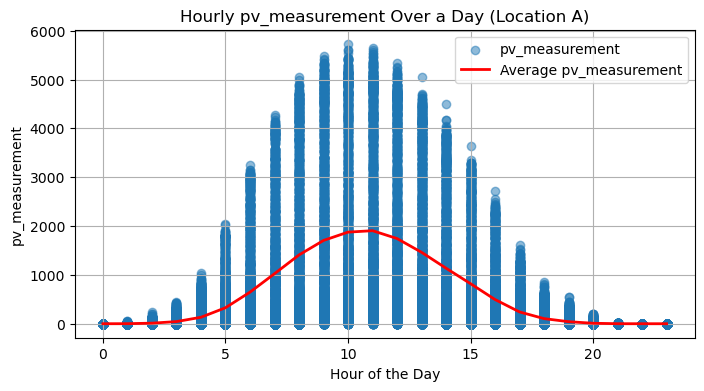

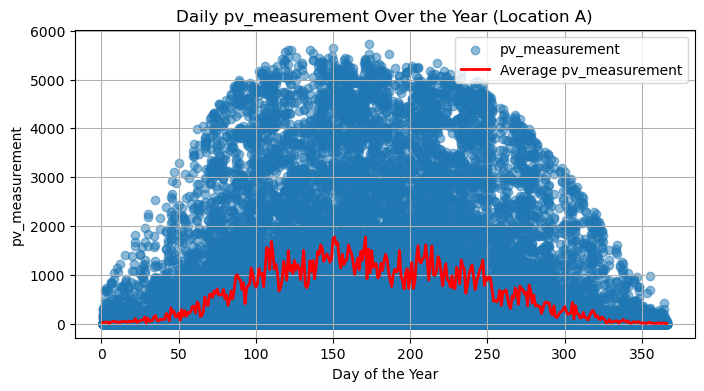

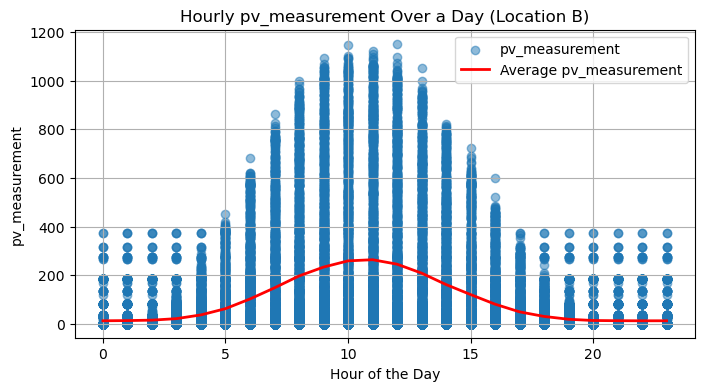

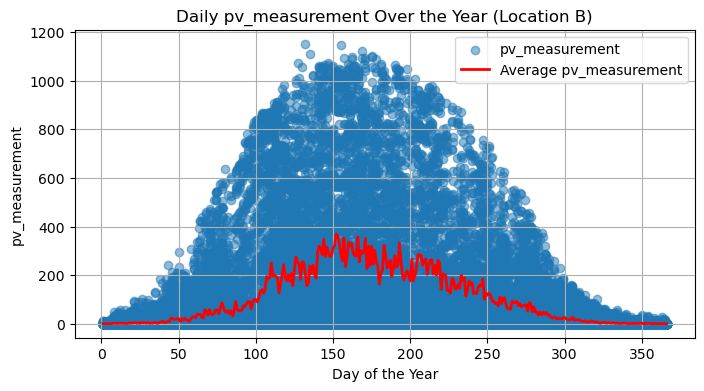

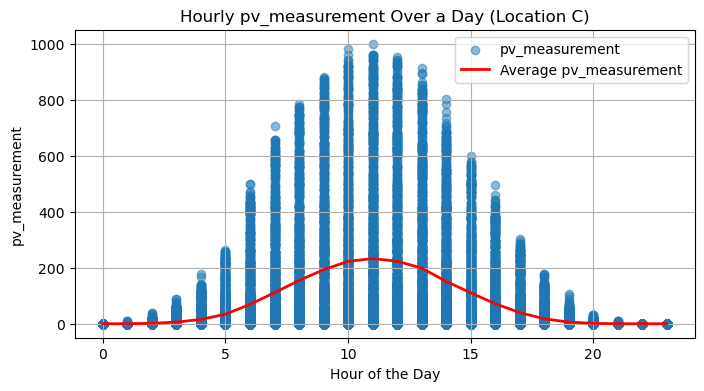

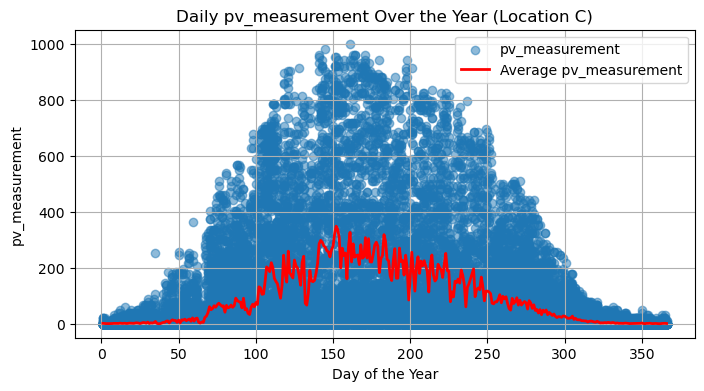

Number of missing values in pv_measurement for location A: 0
Number of missing values in pv_measurement for location B: 4
Number of missing values in pv_measurement for location C: 6060


C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

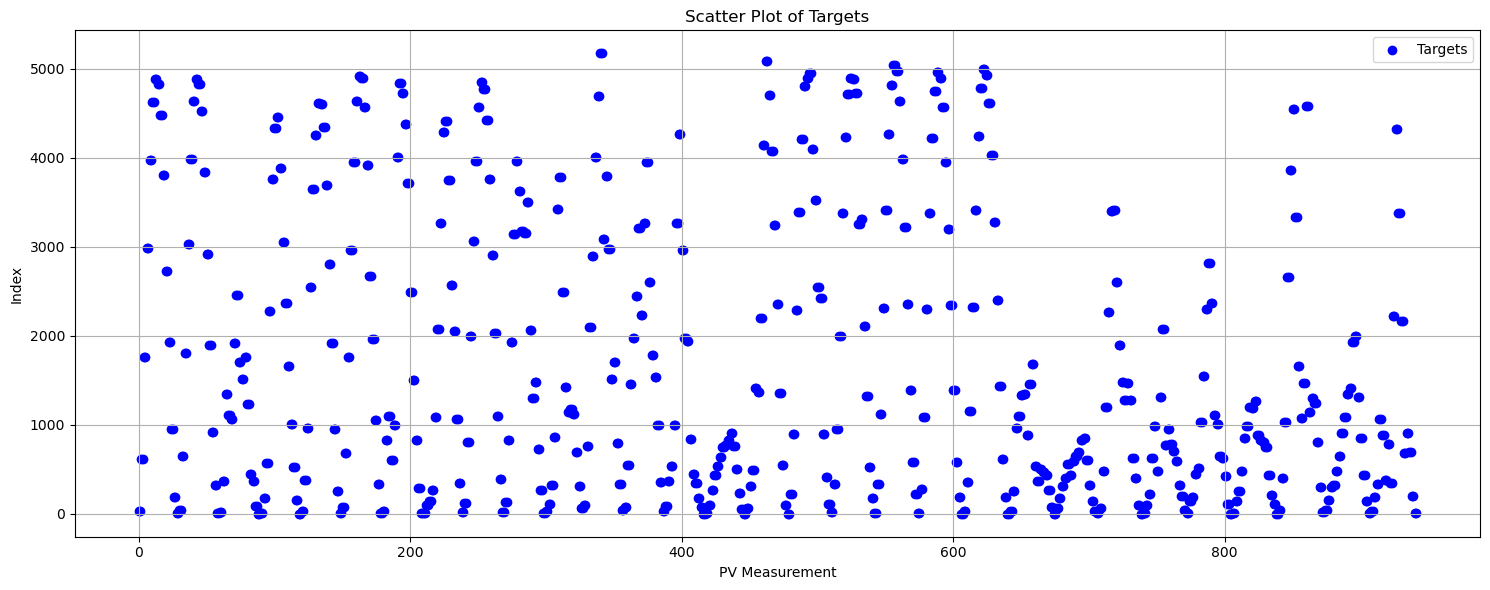

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

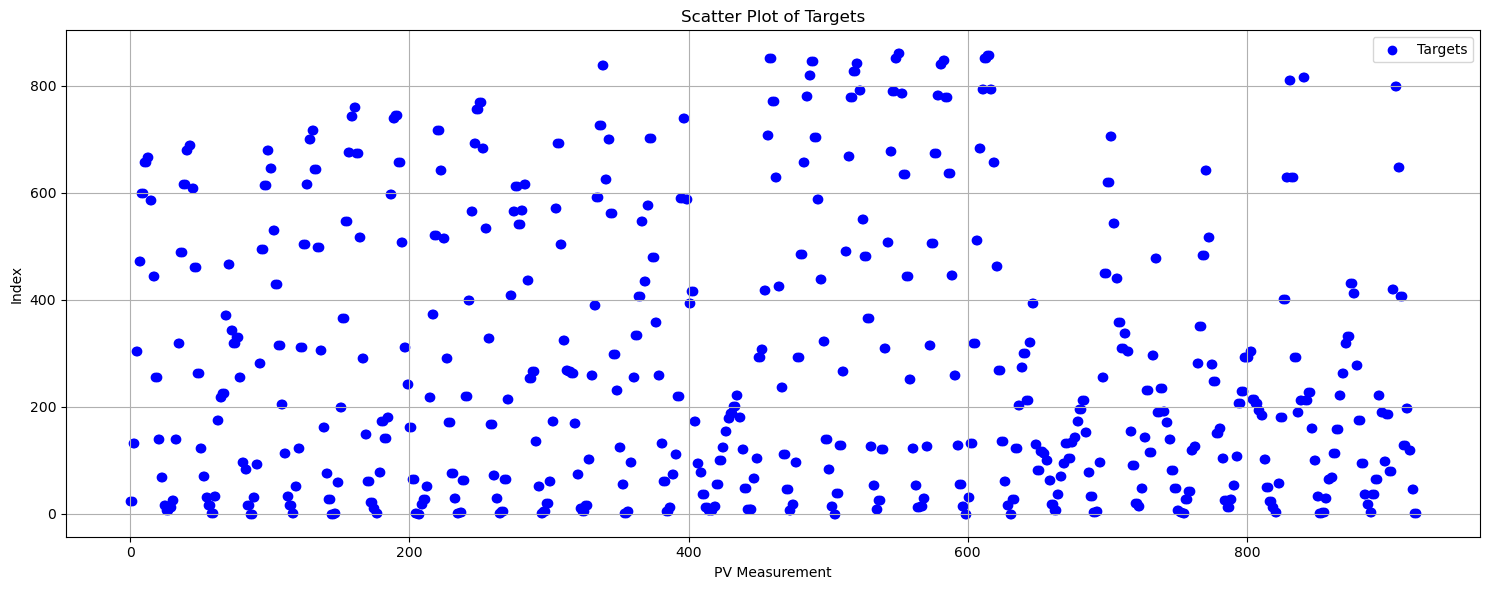

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

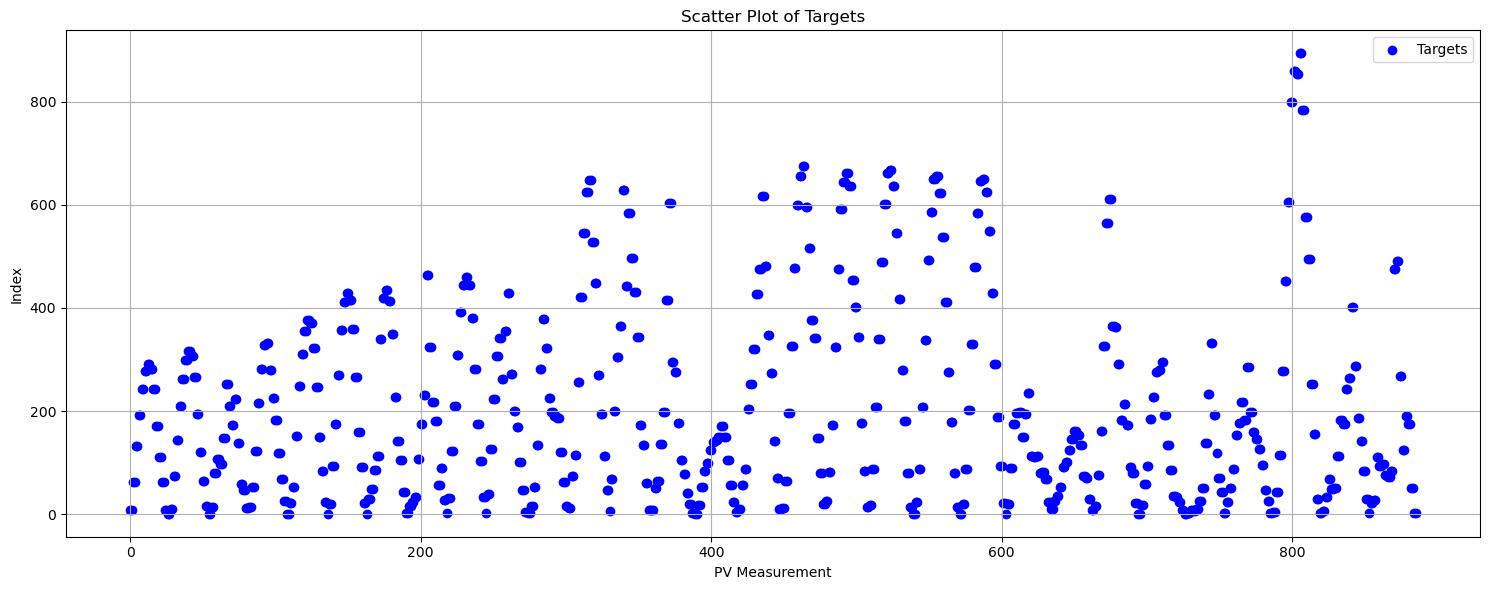

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:75: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Pairs with strong correlation:
hour and sun_azimuth:d have a correlation of 0.9987836047705941
absolute_humidity_2m:gm3 and dew_point_2m:K have a correlation of 0.9874780922354811
clear_sky_rad:W and sun_elevation:d have a correlation of 0.9879421769806291
dew_or_rime:idx and prob_rime:p have a correlation of -1.0000000000000002
direct_rad:W and direct_rad_1h:J have a correlation of 0.9836792365926257
msl_pressure:hPa and pressure_100m:hPa have a correlation of 0.9998695628816684
msl_pressure:hPa and pressure_50m:hPa have a correlation of 0.9999210605683476
msl_pressure:hPa and sfc_pressure:hPa have a correlation of 0.9999156768480704
pressure_100m:hPa and pressure_50m:hPa have a correlation of 0.9999702768513623
pressure_100m:hPa and sfc_pressure:hPa have a correlation of 0.9998877598808524
pressure_50m:hPa and sfc_pressure:hPa have a correlation of 0.9999711513805721



Columns with select_feature=False (location A):

                                variance  select_feature
location_

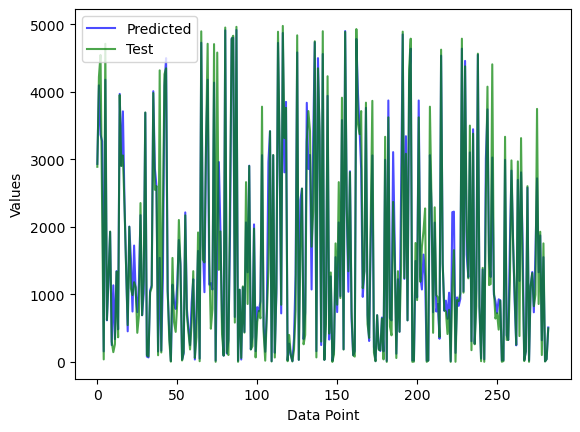

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 28
[LightGBM] [Info] Start training from score 214.763428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

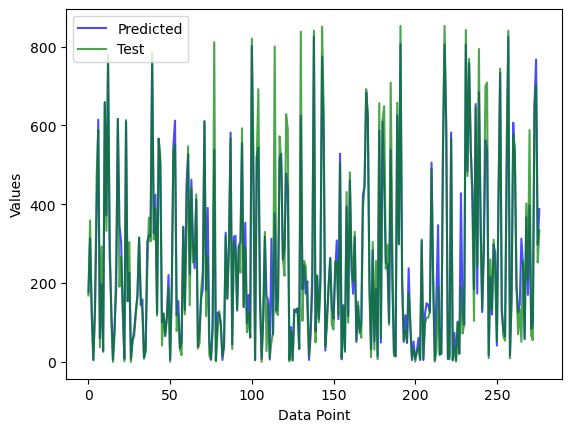

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3444
[LightGBM] [Info] Number of data points in the train set: 496, number of used features: 28
[LightGBM] [Info] Start training from score 161.209991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

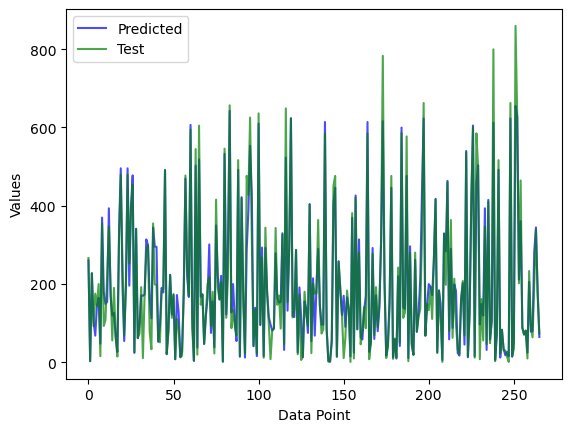

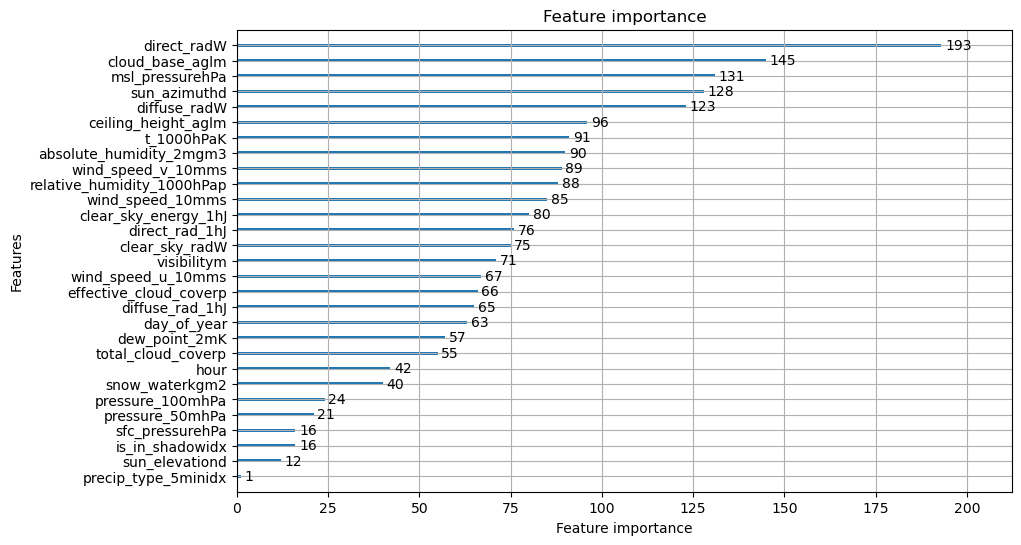

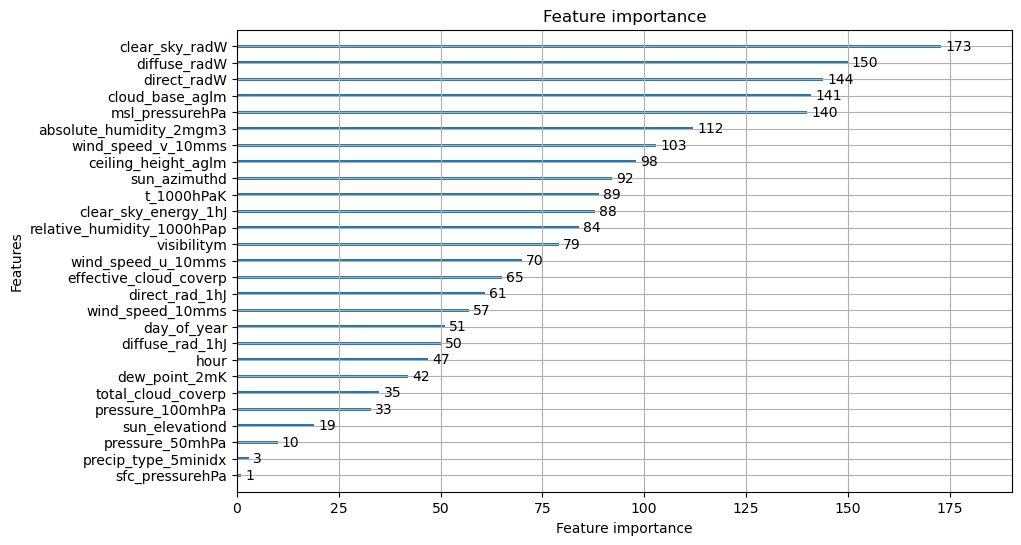

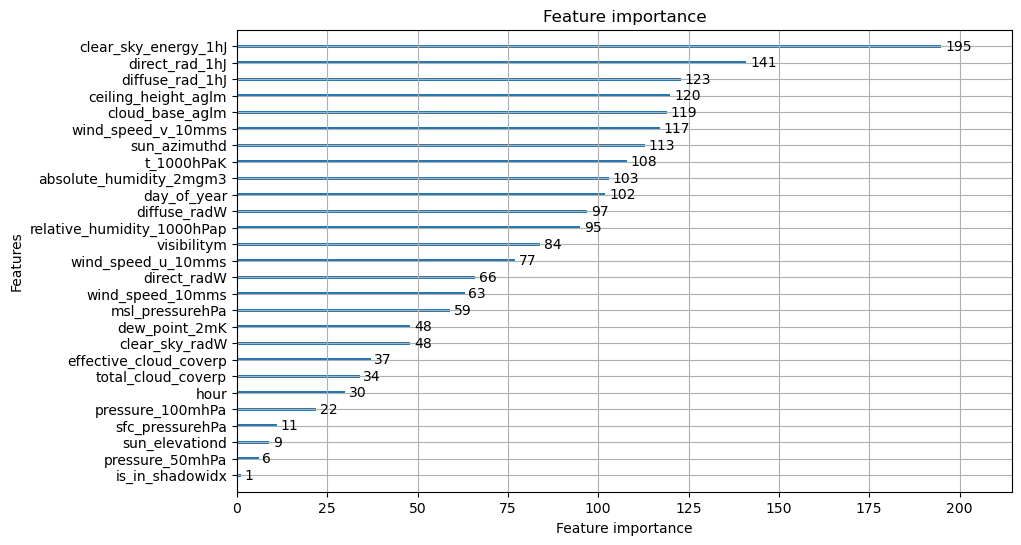

In [44]:
# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 0
X_train_estimated_A['location'] = 0
X_train_observed_A['location'] = 0
train_targets_A['location'] = 0

X_test_estimated_B['location'] = 1
X_train_estimated_B['location'] = 1
X_train_observed_B['location'] = 1
train_targets_B['location'] = 1

X_test_estimated_C['location'] = 2
X_train_estimated_C['location'] = 2
X_train_observed_C['location'] = 2
train_targets_C['location'] = 2

# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])

train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Print info about training data and targets
X_train_observed_A.info()
train_targets_A.info()

X_train_observed_B.info()
train_targets_B.info()

X_train_observed_C.info()
train_targets_C.info()

# Scatterplots over hours and day for each location
scatter_over_hours(train_targets_A, 'Location A')
scatter_over_days(train_targets_A, 'Location A')

scatter_over_hours(train_targets_B, 'Location B')
scatter_over_days(train_targets_B, 'Location B')

scatter_over_hours(train_targets_C, 'Location C')
scatter_over_days(train_targets_C, 'Location C')

# Check for missing values in pv_measurement
missing_values_A = train_targets_A['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location A: {missing_values_A}')

missing_values_B = train_targets_B['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location B: {missing_values_B}')

missing_values_C = train_targets_C['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location C: {missing_values_C}')

# Drop missing values in pv_measurement
train_targets_A.dropna(subset=['pv_measurement'], inplace=True)
train_targets_B.dropna(subset=['pv_measurement'], inplace=True)
train_targets_C.dropna(subset=['pv_measurement'], inplace=True)

merged_data_A, test_resampled_A, is_day_feature_A, targets_ny_A = preprocess_and_merge_data(X_train_observed_A, X_train_estimated_A, X_test_estimated_A, train_targets_A)
merged_data_B, test_resampled_B, is_day_feature_B, targets_ny_B = preprocess_and_merge_data(X_train_observed_B, X_train_estimated_B, X_test_estimated_B, train_targets_B)
merged_data_C, test_resampled_C, is_day_feature_C, targets_ny_C = preprocess_and_merge_data(X_train_observed_C, X_train_estimated_C, X_test_estimated_C, train_targets_C)

# Scatter target value against features to look for patterns 
'''plot_scatter_subplots(merged_data_A, targets_ny_A)
plot_scatter_subplots(merged_data_B, targets_ny_B)
plot_scatter_subplots(merged_data_C, targets_ny_C)'''

# Find pairs with strong correlation for each location
find_strong_correlation_pairs(merged_data_A, threshold=0.98)
find_strong_correlation_pairs(merged_data_B, threshold=0.98)
find_strong_correlation_pairs(merged_data_C, threshold=0.98)

#Ideally drop the columns with too high correlation to avoid multicolinearity
merged_data_A = merged_data_A.drop(columns=[])
merged_data_B = merged_data_B.drop(columns=[])
merged_data_C = merged_data_C.drop(columns=[])

test_A = test_resampled_A.drop(columns=[])
test_B = test_resampled_B.drop(columns=[])
test_C = test_resampled_C.drop(columns=[])

# Drop dtime columns
merged_data_A=merged_data_A = merged_data_A.select_dtypes(exclude=['datetime'])
merged_data_B=merged_data_B.select_dtypes(exclude=['datetime'])
merged_data_C=merged_data_C.select_dtypes(exclude=['datetime'])

test_resampled_A=test_resampled_A.select_dtypes(exclude=['datetime'])
test_resampled_B=test_resampled_B.select_dtypes(exclude=['datetime'])
test_resampled_C=test_resampled_C.select_dtypes(exclude=['datetime'])


#Check for constant features that can be dropped
vt = VarianceThreshold(threshold = 0.025)
vt.fit(merged_data_A)

variance_df = pd.DataFrame({'variance':vt.variances_, 'select_feature':vt.get_support()}, index=merged_data_A.columns)
merged_data_A_subset = merged_data_A.iloc[:,vt.get_support()]

print('\nColumns with select_feature=False (location A):\n')
print(variance_df[variance_df['select_feature'] == False])

vt = VarianceThreshold(threshold = 0.05)
vt.fit(merged_data_B)

variance_df = pd.DataFrame({'variance':vt.variances_, 'select_feature':vt.get_support()}, index=merged_data_A.columns)
merged_data_B_subset = merged_data_B.iloc[:,vt.get_support()]

print('\nColumns with select_feature=False (location B):\n')
print(variance_df[variance_df['select_feature'] == False])

vt = VarianceThreshold(threshold = 0.05)
vt.fit(merged_data_C)

variance_df = pd.DataFrame({'variance': vt.variances_, 'select_feature': vt.get_support()}, index=merged_data_A.columns)
merged_data_C_subset = merged_data_C.iloc[:, vt.get_support()]

print('\nColumns with select_feature=False (location C):\n')
print(variance_df[variance_df['select_feature'] == False])

# Rename columns for LightGBM compatibility
merged_data_A_subset = merged_data_A_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Rename columns for LightGBM compatibility
merged_data_B_subset = merged_data_B_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Rename columns for LightGBM compatibility
merged_data_C_subset = merged_data_C_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Define the features (X) and target (y)
X_train_A_lgbm = merged_data_A_subset
y_train_A = targets_ny_A['pv_measurement']

X_train_B_lgbm = merged_data_B_subset
y_train_B = targets_ny_B['pv_measurement']

X_train_C_lgbm = merged_data_C_subset
y_train_C = targets_ny_C['pv_measurement']

# Build and train LightGBM
trained_model_A = train_and_evaluate_lgbm(X_train_A_lgbm, y_train_A, num_folds = 5)
trained_model_B = train_and_evaluate_lgbm(X_train_B_lgbm, y_train_B, num_folds = 5)
trained_model_C = train_and_evaluate_lgbm(X_train_C_lgbm, y_train_C, num_folds = 5)

# Plot feature importance
lgb.plot_importance(trained_model_A, figsize=(10, 6))
plt.show()

# Plot feature importance
lgb.plot_importance(trained_model_B, figsize=(10, 6))
plt.show()

# Plot feature importance
lgb.plot_importance(trained_model_C, figsize=(10, 6))
plt.show()

<a id="subsection3.5"></a>

## Catboost Predictor for each location and dedicated Feature Engineering ( observation of scatter over days and hours, location feature definition, eliminating NaN)

After defining the training function, our code proceeds with the following steps for solar power prediction analysis across three different locations (A, B, C):

- Scatterplots are generated to visualize the relationship between time and solar power measurements for each location.
- The script checks for missing values in the `pv_measurement` column and removes any rows with missing data.
- The `preprocess_and_merge_data` function is called for each location's data to clean and prepare the data for model training.
- Time features are added to the datasets using a function `add_time_features_cat` (not provided in the snippet).
- Finally, the `train_and_evaluate_catboost` function is called to train and evaluate the CatBoost model for each location's dataset.

The models trained for each location (`model_CatBoost_A`, `model_CatBoost_B`, `model_CatBoost_C`) can then be used for predicting solar power generation based on the observed and estimated conditions for their respective locations. The outputs of the function include the trained model and a plot showing the predicted vs. actual values, which can be useful for assessing model performance visually.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576 entries, 0 to 17575
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_calc                       17576 non-null  datetime64[ns]
 1   date_forecast                   17576 non-null  datetime64[ns]
 2   absolute_humidity_2m:gm3        17576 non-null  float32       
 3   air_density_2m:kgm3             17576 non-null  float32       
 4   ceiling_height_agl:m            13657 non-null  float32       
 5   clear_sky_energy_1h:J           17576 non-null  float32       
 6   clear_sky_rad:W                 17576 non-null  float32       
 7   cloud_base_agl:m                15482 non-null  float32       
 8   dew_or_rime:idx                 17576 non-null  float32       
 9   dew_point_2m:K                  17576 non-null  float32       
 10  diffuse_rad:W                   17576 non-null  float32       
 11  di

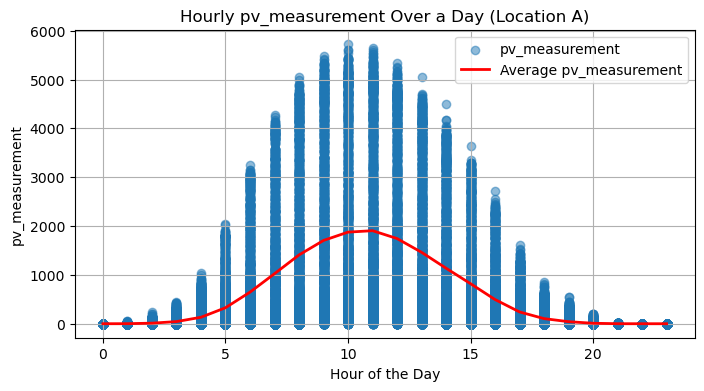

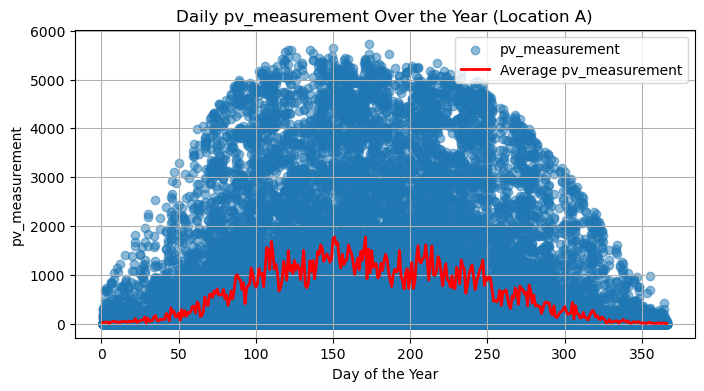

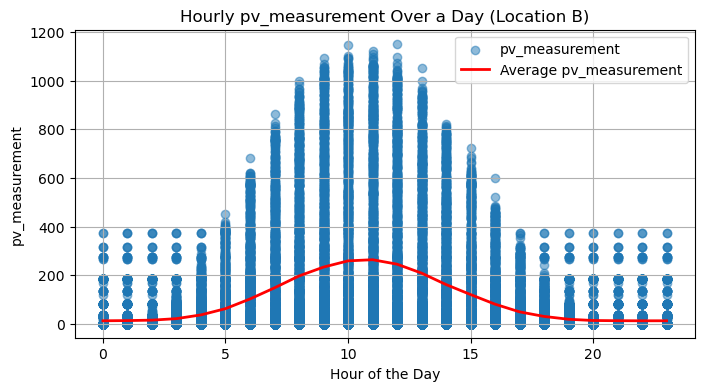

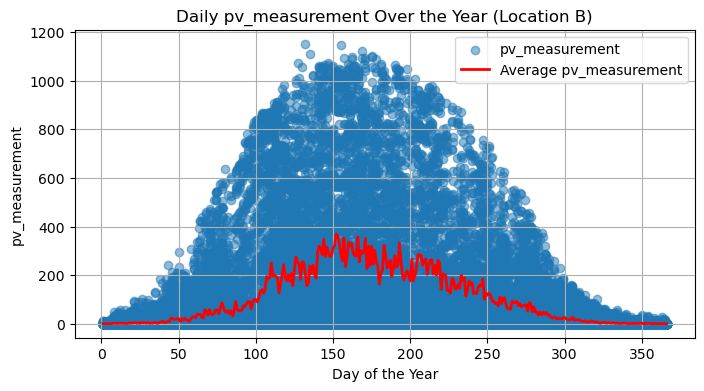

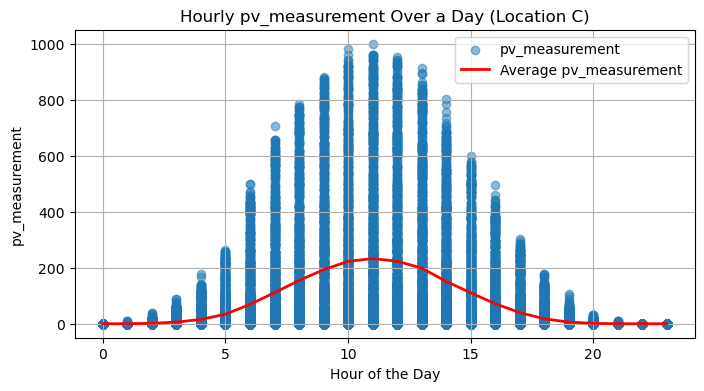

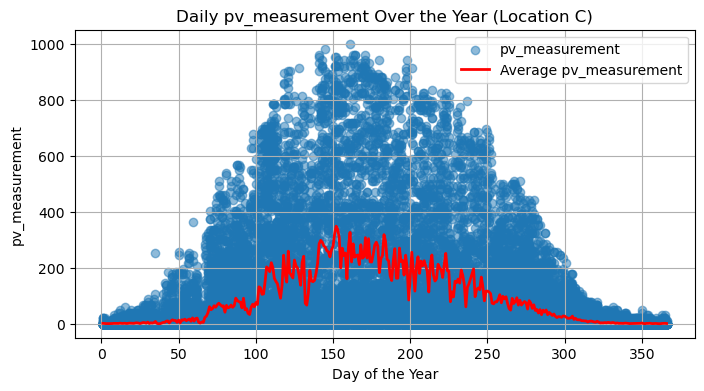

Number of missing values in pv_measurement for location A: 0
Number of missing values in pv_measurement for location B: 4
Number of missing values in pv_measurement for location C: 6060


C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

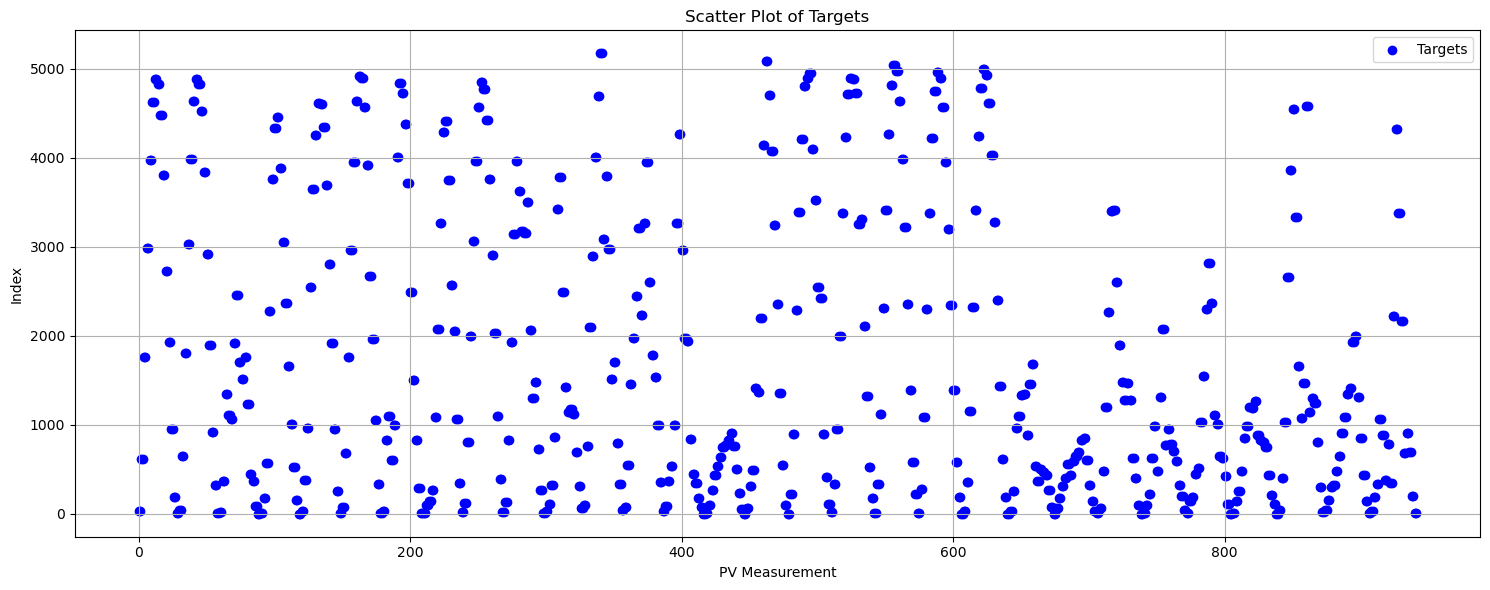

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

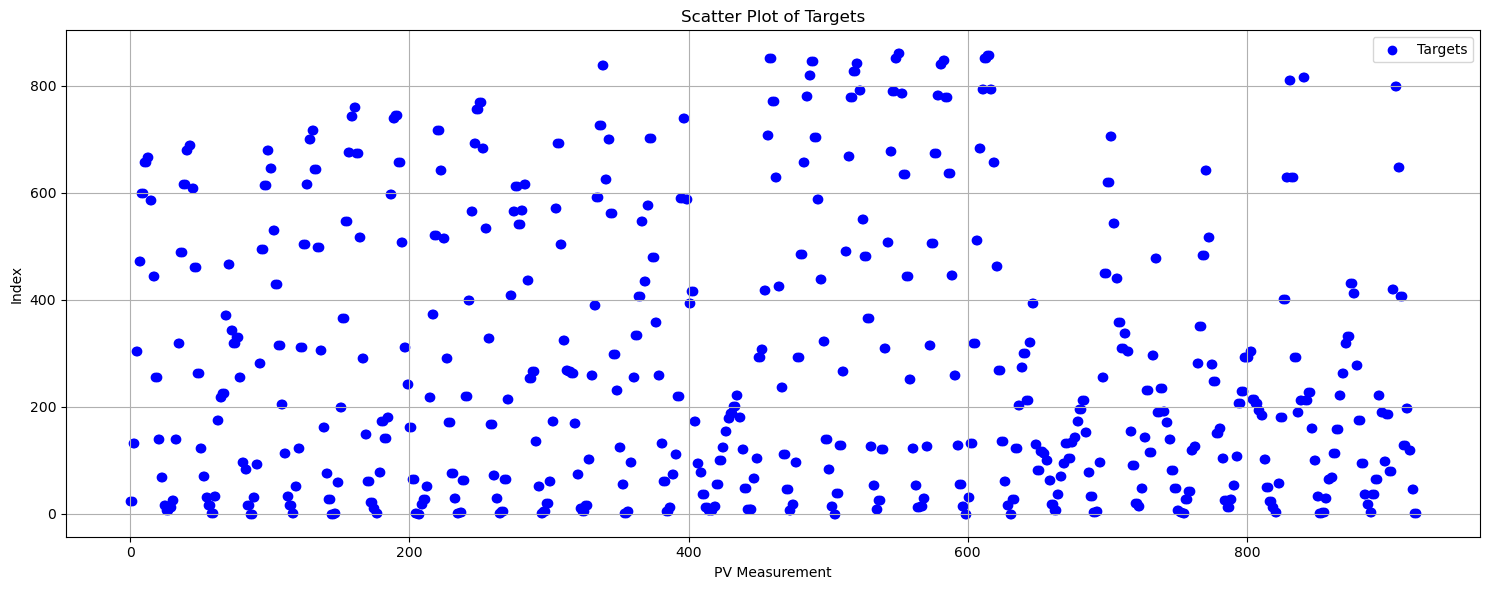

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\3167003858.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

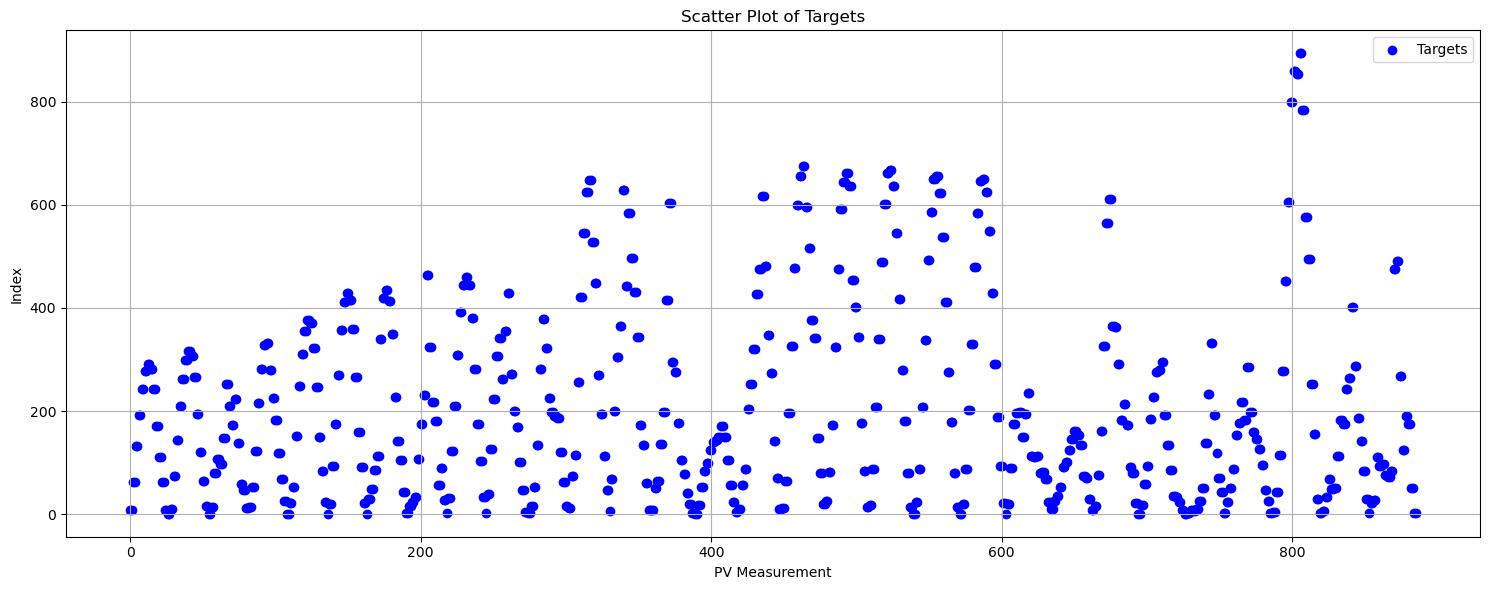

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

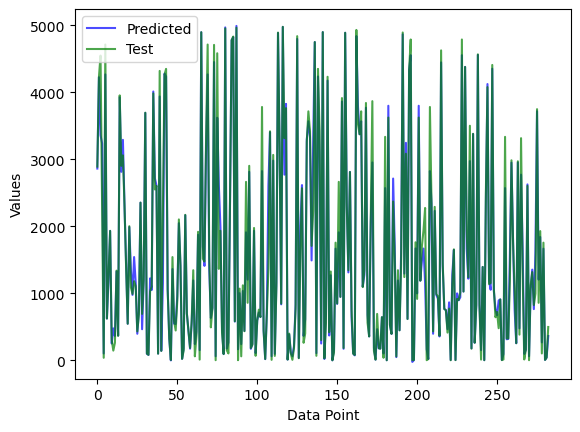

0:	learn: 195.2039412	total: 3.07ms	remaining: 3.07s
200:	learn: 17.1925797	total: 360ms	remaining: 1.43s
400:	learn: 9.6068571	total: 682ms	remaining: 1.02s
600:	learn: 6.6081634	total: 1.04s	remaining: 689ms
800:	learn: 4.9240972	total: 1.37s	remaining: 341ms
999:	learn: 3.4533413	total: 1.71s	remaining: 0us
Mean Absolute Error (MAE) on the testing dataset: 19.34111749582201


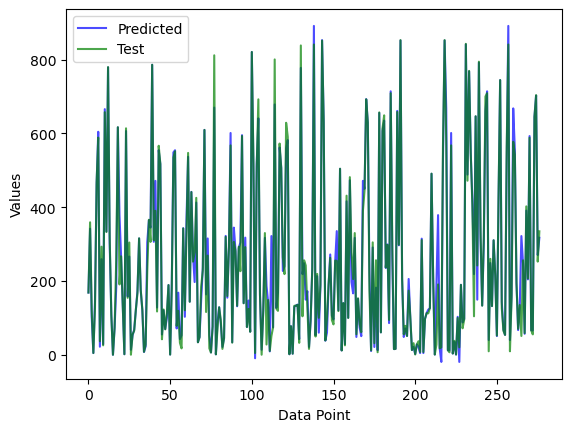

0:	learn: 138.1161409	total: 2.52ms	remaining: 2.52s
200:	learn: 8.5620962	total: 370ms	remaining: 1.47s
400:	learn: 4.7150297	total: 708ms	remaining: 1.06s
600:	learn: 3.1784071	total: 1.08s	remaining: 715ms
800:	learn: 2.2918325	total: 1.42s	remaining: 352ms
999:	learn: 1.8030051	total: 1.77s	remaining: 0us
Mean Absolute Error (MAE) on the testing dataset: 13.05990426971373


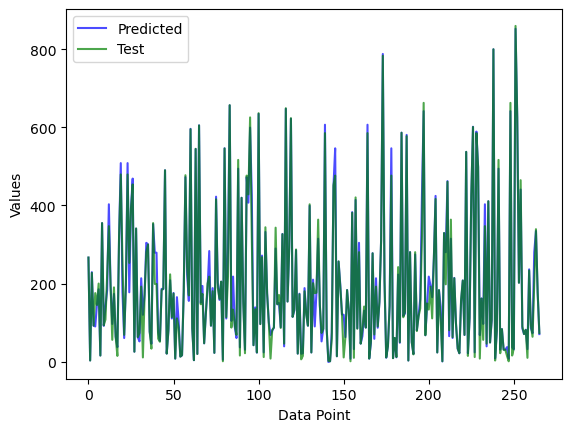

In [46]:
def train_and_evaluate_catboost(X_train, y_train, test_size=0.3, random_state=42, num_folds=5):
    # Split the data into training and testing sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

    # Create a CatBoost Pool for training
    train_pool = Pool(X_train_split, label=y_train_split)

    # Define hyperparameters
    params = {
        "loss_function": "MAE",
        "learning_rate": 0.1,
        "verbose": 200,
    }

    # Initialize and train the CatBoost model
    model = CatBoostRegressor(**params)
    model.fit(train_pool)

    # Make predictions on the testing dataset
    y_pred = model.predict(X_test_split)
    
    # Evaluate the model using MAE on the testing dataset
    mae = mean_absolute_error(y_test_split, y_pred)
    print("Mean Absolute Error (MAE) on the testing dataset:", mae)

    # Create an array of indices (x-values) for the data points
    x_values = range(len(y_test_split))

    # Plot the predicted values as a line with slight transparency
    plt.plot(x_values, y_pred, label='Predicted', color='blue', alpha=0.7)

    # Plot the test values as a line with slight transparency
    plt.plot(x_values, y_test_split, label='Test', color='green', alpha=0.7)

    # Add labels and a legend
    plt.xlabel('Data Point')
    plt.ylabel('Values')
    plt.legend()

    # Show the plot
    plt.show()

    return model

# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 0
X_train_estimated_A['location'] = 0
X_train_observed_A['location'] = 0
train_targets_A['location'] = 0

X_test_estimated_B['location'] = 1
X_train_estimated_B['location'] = 1
X_train_observed_B['location'] = 1
train_targets_B['location'] = 1

X_test_estimated_C['location'] = 2
X_train_estimated_C['location'] = 2
X_train_observed_C['location'] = 2
train_targets_C['location'] = 2

# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])

train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Print info about training data and targets
X_train_observed_A.info()
train_targets_A.info()

X_train_observed_B.info()
train_targets_B.info()

X_train_observed_C.info()
train_targets_C.info()

# Scatterplots over hours and day for each location
scatter_over_hours(train_targets_A, 'Location A')
scatter_over_days(train_targets_A, 'Location A')

scatter_over_hours(train_targets_B, 'Location B')
scatter_over_days(train_targets_B, 'Location B')

scatter_over_hours(train_targets_C, 'Location C')
scatter_over_days(train_targets_C, 'Location C')

# Check for missing values in pv_measurement
missing_values_A = train_targets_A['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location A: {missing_values_A}')

missing_values_B = train_targets_B['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location B: {missing_values_B}')

missing_values_C = train_targets_C['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location C: {missing_values_C}')

# Drop missing values in pv_measurement
train_targets_A.dropna(subset=['pv_measurement'], inplace=True)
train_targets_B.dropna(subset=['pv_measurement'], inplace=True)
train_targets_C.dropna(subset=['pv_measurement'], inplace=True)

merged_data_A, test_resampled_A, is_day_feature_A, targets_ny_A = preprocess_and_merge_data(X_train_observed_A, X_train_estimated_A, X_test_estimated_A, train_targets_A)
merged_data_B, test_resampled_B, is_day_feature_B, targets_ny_B = preprocess_and_merge_data(X_train_observed_B, X_train_estimated_B, X_test_estimated_B, train_targets_B)
merged_data_C, test_resampled_C, is_day_feature_C, targets_ny_C = preprocess_and_merge_data(X_train_observed_C, X_train_estimated_C, X_test_estimated_C, train_targets_C)


X_train_A_cat = add_time_features_cat(merged_data_A, 'date_forecast')
X_train_B_cat = add_time_features_cat(merged_data_B, 'date_forecast')
X_train_C_cat = add_time_features_cat(merged_data_C, 'date_forecast')

model_CatBoost_A = train_and_evaluate_catboost(X_train_A_cat, targets_ny_A['pv_measurement'])
model_CatBoost_B = train_and_evaluate_catboost(X_train_B_cat, targets_ny_B['pv_measurement'])
model_CatBoost_C = train_and_evaluate_catboost(X_train_C_cat, targets_ny_C['pv_measurement'])

<a id="subsection3.6"></a>

## Linear regression and some basic Feature Engineering ( observation of 'direct_rad:W', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'direct_rad_1h:J', 'sun_elevation:d' as linear features and cleaning of NaNs)

The code reads solar energy and weather data, filters out unnecessary information, and focuses on the most relevant months for solar production. It cleans the data, removing entries without power measurements or with constant readings, and merges different data sources. After merging, it analyzes which weather factors correlate strongly with solar energy output.

It trains a linear regression model using these features and evaluates its accuracy with Mean Squared Error (MSE) and R-squared metrics. The reasoning behind such model can be found in the scatterplots below: they show a clear tendency from some features to act like linearly predictable variables. Finally, it plots the model's predictions against actual data to visualize its performance.

C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\1749535070.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\1749535070.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_18672\1749535070.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default

Mean Squared Error: 755696.1387868399
R-squared: 0.6283913896791222


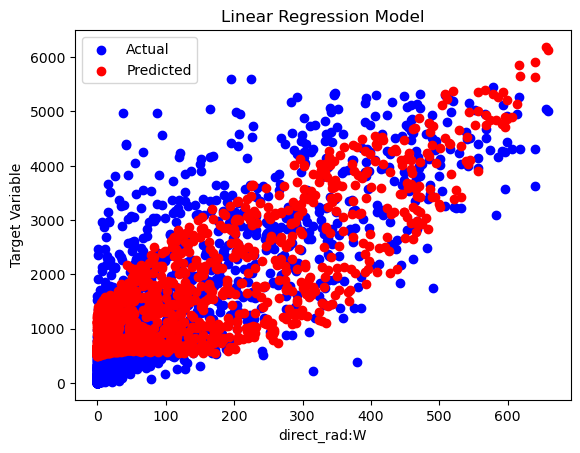

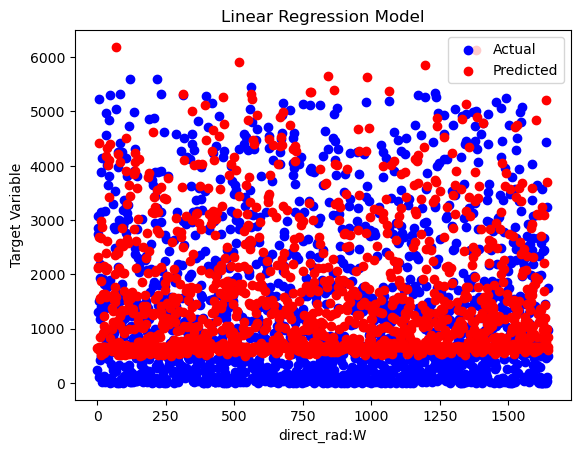

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Read and upload data
def read_weather_data(location):
    train_targets = pd.read_parquet(f'data/{location}/train_targets.parquet')
    X_train_observed = pd.read_parquet(f'data/{location}/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(f'data/{location}/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(f'data/{location}/X_test_estimated.parquet')
    
    return train_targets, X_train_observed, X_train_estimated, X_test_estimated

# Preprocess
def preprocessing(targets, observed, estimated, test):
    
    # Convert date columns to datetime
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().reset_index()

    # Extract 'is_day:idx' feature
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]

    # Drop constant and unwanted columns
    # FIX THIS 
    columns_to_drop = ['is_day:idx', 'snow_density:kgm3', 'elevation:m']
    test_resampled = test_resampled.drop(columns=columns_to_drop )
    observed_resampled = observed_resampled.drop(columns=columns_to_drop)
    estimated_resampled = estimated_resampled.drop(columns=columns_to_drop )

    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]

    # Remove rows with infinite values and NaN
    observed_resampled = observed_resampled.replace([np.inf, -np.inf], np.nan).dropna()
    test_resampled = test_resampled.replace([np.inf, -np.inf], np.nan).dropna()
    targets = targets.replace([np.inf, -np.inf], np.nan).dropna()

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, pd.concat([observed_resampled, estimated_resampled]), how='inner', left_on='time', right_on='date_forecast').dropna()

    # Remove rows with pv_measurement equal to 0
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Remove constant segments (most relevant in location B)
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()
                                              
    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Clean up auxiliary columns
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
                                           
    # Drop non-feature columns and define targets
    targets_ny = filtered_data[['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test_resampled = test_resampled.drop(columns=['date_forecast'])
    

    return filtered_data, test_resampled, is_day_feature, targets_ny


def analyze_feature_correlation(X, target, save_plots=False):
    p_values = []

    for column in X.columns:
        r, p = stats.pearsonr(X[column], target)
        p_values.append((column, r, p))

        # Create scatter plots
        plt.figure(figsize=(8, 6))
        plt.scatter(X[column], target, label=column)
        plt.xlabel(column)
        plt.ylabel('PV Measurement')
        plt.title(f'Scatter Plot of PV Measurement vs. {column}')
        plt.legend()
        plt.grid(True)

        if save_plots:
            plt.savefig(f'scatter_plot_{column}.png')
        else:
            plt.show()

    # Convert the results to a Pandas DataFrame for easier analysis and sorting
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'Correlation', 'P-Value'])

    # Sort the features by p-value in ascending order
    p_values_df = p_values_df.sort_values(by='P-Value')

    # Print or analyze the p-values for each feature
    return p_values_df

# Import data

locations = ['A', 'B', 'C']
data_by_location = {}

for location in locations:
    data_by_location[location] = read_weather_data(location)

filtered_data = {}
test_resampled = {}
is_day_feature = {}
targets_ny = {}

# Preprocess the data for each location
for location in locations:
    train_targets, X_train_observed, X_train_estimated, X_test_estimated = data_by_location[location]
    
    filtered_data[location], test_resampled[location], is_day_feature[location], targets_ny[location] = preprocessing(
        train_targets, X_train_observed, X_train_estimated, X_test_estimated
    )
    

for location in locations:
    nan_check = filtered_data[location].isna().any()
    filtered_data[location].dropna()
    targets_ny[location]['pv_measurement'].dropna()

    # Display columns with NaN values, if any
    nan_columns = nan_check[nan_check].index
    if len(nan_columns) > 0:
        print(f"Columns with NaN values in filtered_data for Location {location}:")
        print(nan_columns)
    


# Extract the feature and target variable
X = filtered_data['A'][['direct_rad:W', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'direct_rad_1h:J', 'sun_elevation:d']]
y = targets_ny['A']['pv_measurement']

# Define the degree of the polynomial
degree = 3 

# Create polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R-squared for evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot with the actual and predicted values
plt.scatter(X_test[:, 1], y_test, color='blue', label='Actual')
plt.scatter(X_test[:, 1], y_pred, color='red', label='Predicted')
plt.xlabel('direct_rad:W')
plt.ylabel('Target Variable')
plt.title('Linear Regression Model')
plt.legend()
plt.show()


plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred,  color='red', label='Predicted')
plt.xlabel('direct_rad:W')
plt.ylabel('Target Variable')
plt.title('Linear Regression Model')
plt.legend()
plt.show()


<a id="subsection3.6"></a>

## Random Forest predictor and Feature Importance

The code segment includes a step for selecting features using a Random Forest Regressor. Here's a plain-language explanation:

Imagine you're trying to figure out what affects how much electricity a solar panel system makes. You have a lot of information, like the weather, the time of day, and where the sun is in the sky. But not all of this information is equally helpful.

To find out which pieces of information (features) are really important, the code uses a tool called a Random Forest. This tool looks at all the data and decides which factors are the best at predicting the solar panel's electricity output. It's like finding the most influential ingredients in a complex recipe.

Once the most important features are identified, the code uses these features to fine-tune the predictions. It's like refining the recipe to make sure it turns out great every time. The code also uses a technique called Grid Search to try out different settings for the Random Forest, making sure it's set up in the best possible way.

In the end, the code checks how well the predictions match the actual electricity output. If the match is good, it means the model is doing a great job of capturing what really matters for solar power production.

DF size before cleaning NaN
1092500
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               5988
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   3446
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
prec

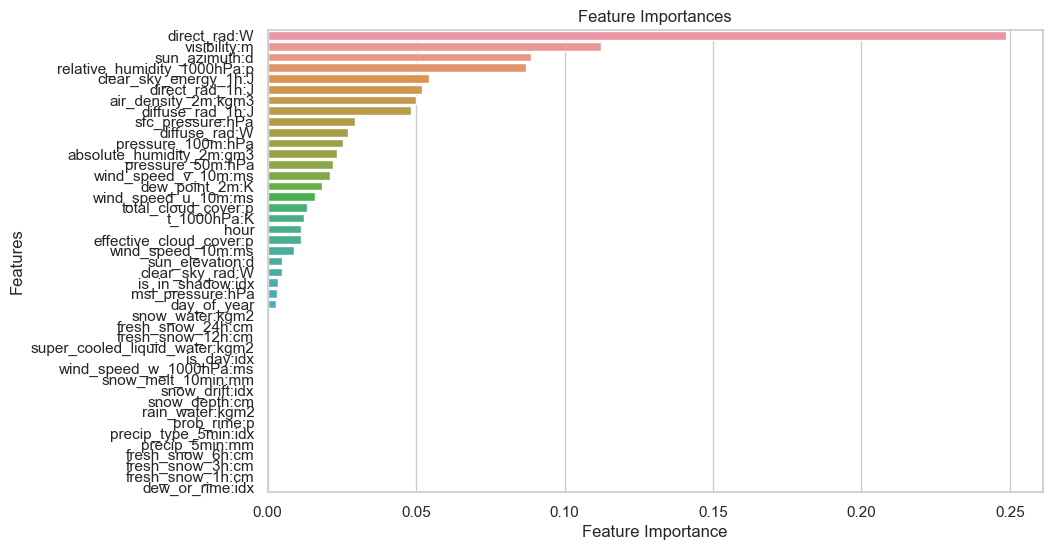

['direct_rad:W', 'sun_azimuth:d', 'is_day:idx', 'is_in_shadow:idx']
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Mean Squared Error: 6500.132541758572
Mean Absolute Error: 35.92684370715217
R-squared (R2) Score: 0.4969235391564988
R-squared: 49.69%


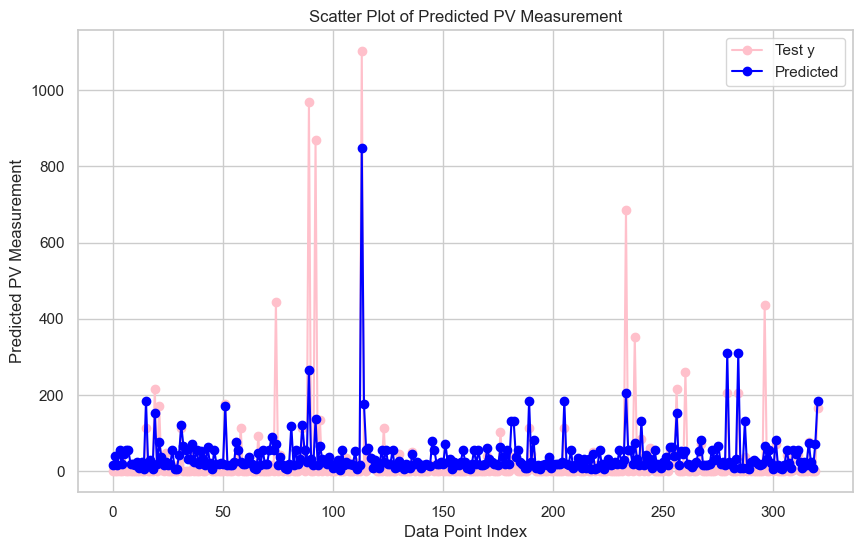

In [53]:
from sklearn.ensemble import RandomForestRegressor


# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])
train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Combine training data
X_train = pd.concat([X_train_observed, X_train_estimated], axis=0)
X_train = X_train.drop(columns=['date_calc'])

# Merge dataframes based on the time column
merged_df = pd.merge(X_train, train_targets, left_on=['date_forecast', 'location'], right_on=['time', 'location'], how='inner')
merged_df = merged_df.drop(columns=['time'])

print('DF size before cleaning NaN')
print(merged_df.size)

# Checking null values
print(merged_df.isna().sum())

# Drop rows with too many NaN values 
merged_df = merged_df.drop(columns=['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'] )

# Drop columns of constants 
for column in merged_df.columns:
    unique_counts = merged_df[column].nunique()
    print(f"The '{column}' column has {unique_counts} unique values.")
    
  
num_df = merged_df.drop(columns=['date_forecast', 'location', 'pv_measurement', 'elevation:m'])

# Descriptive statistics
print(num_df.describe())

import matplotlib.pyplot as plt

# BoxPlots 
# fig, axs = plt.subplots(len(num_df.columns), 1, dpi=95, figsize=(10, 100))

outlier_counts = {}  # A dictionary to store outlier counts for each column

for col in num_df.columns:
    # Calculate the 10th and 90th percentiles
    q10 = num_df[col].quantile(0.1)
    q90 = num_df[col].quantile(0.9)
    
    # Find the data points that are outside the 10th-90th percentile range
    outliers = num_df[(num_df[col] < q10) | (num_df[col] > q90)][col]
    
    # Count the number of outliers
    outlier_count = len(outliers)
    
    # Store the outlier count in the dictionary
    outlier_counts[col] = outlier_count

# Print the outlier counts for each column
for col, count in outlier_counts.items():
    print(f"Number of outliers in {col}: {count}")
    
# Remove the outliers
filtered_df = num_df.copy()  # Create a copy of the original DataFrame

for col in num_df.columns:
    # Calculate the 10th and 90th percentiles
    q10 = num_df[col].quantile(0.1)
    q90 = num_df[col].quantile(0.9)
    
    filtered_df = filtered_df[(filtered_df[col] >= q10) & (filtered_df[col] <= q90)]

filtered_df_X = filtered_df
df = pd.merge(filtered_df_X, merged_df)
df_PROVA = df.drop(['date_forecast','location', 'elevation:m'], axis=1)

print(df_PROVA.head())

# Step 2: Split data into X (features) and y (target variable)
X = df_PROVA.drop(['pv_measurement'], axis=1)
y = df_PROVA['pv_measurement']

# Step 3: Choose a machine learning model
model = RandomForestRegressor()

# Step 4: Train the model
model.fit(X, y)

# Step 5: Get feature importances
feature_importances = model.feature_importances_

# Step 6: Rank features
feature_importance_ranking = sorted(zip(feature_importances, X.columns), reverse=True)

# Step 7: Visualize the results
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=[f[0] for f in feature_importance_ranking], y=[f[1] for f in feature_importance_ranking])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

# Select the top four most relevant features
columns_to_check = [f[1] for f in feature_importance_ranking[:3]]
columns_to_check = ['direct_rad:W', 'sun_azimuth:d', 'is_day:idx', 'is_in_shadow:idx']
print(columns_to_check)

# Prepare the data
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X[columns_to_check], y, test_size=test_size, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the selected columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Convert the Pandas DataFrame to a NumPy array and flatten it
y_train = np.ravel(y_train)

# Define the hyperparameters and their possible values for the Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],      # Adjust the number of estimators
    'max_depth': [None, 10, 20, 30],   # Adjust the maximum depth of trees
    'min_samples_split': [2, 5, 10]    # Adjust the minimum samples required to split a node
}

# Create a Grid Search instance
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the Grid Search to your data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Random Forest Regressor with the best hyperparameters
best_rf_regressor = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
best_rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2) Score:", r2)

# Create a scatter plot for the predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)),y_test, c='pink', marker='o', label='Test y')
plt.plot(range(len(y_pred)), y_pred, c='blue', marker='o', label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted PV Measurement')
plt.title('Scatter Plot of Predicted PV Measurement')
plt.legend()
plt.grid(True)

# Calculate R-squared (coefficient of determination) as a percentage
r2 = r2_score(y_test, y_pred)
percentage_r2 = r2 * 100

print(f"R-squared: {percentage_r2:.2f}%")



<a id="subsection3.7"></a>

## Random forest but with RFE feature selection, removal of NaNs 

Here the steps taken towards this solution

1. **Feature Engineering**: Each dataset is augmented with a new 'location' feature to distinguish between the data from different locations. The datasets are then concatenated to create a combined dataset for analysis, ensuring that the model we develop is generalizable across all three locations.

2. **Data Cleaning**: The combined dataset undergoes several preprocessing steps:
   - Removal of columns with non-varying data or excessive missing values, as these are unlikely to be useful for prediction.
   - Identification and removal of outliers, which are data points that deviate significantly from the rest of the dataset and could skew the model's performance.

3. **Feature Selection**: We use Recursive Feature Elimination (RFE) with a Random Forest Regressor. RFE works by recursively fitting the model and removing the least important features until the specified number of features is reached. This process is key in identifying which weather features are most predictive of solar panel output.

4. **Data Splitting**: The cleaned and processed dataset is split into training and testing sets. This split is essential for evaluating the model's performance on unseen data, ensuring that our predictions will be reliable when applied in real-world scenarios.

5. **Model Training and Evaluation**: A Random Forest Regressor is trained on the selected features. Random forests are an ensemble learning method that fits multiple decision trees on various sub-samples of the dataset and uses averaging to improve predictive accuracy and control overfitting.
   
6. **Hyperparameter Tuning**: The model's hyperparameters are optimized using Grid Search, which systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.


DF size before cleaning NaN
1048800
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               5988
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   3446
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
prec

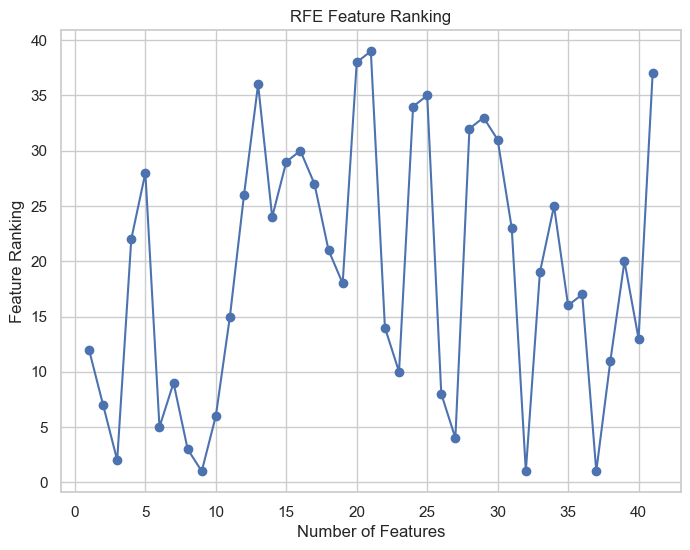

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 'A'
X_train_estimated_A['location'] = 'A'
X_train_observed_A['location'] = 'A'
train_targets_A['location'] = 'A'

X_test_estimated_B['location'] = 'B'
X_train_estimated_B['location'] = 'B'
X_train_observed_B['location'] = 'B'
train_targets_B['location'] = 'B'

X_test_estimated_C['location'] = 'C'
X_train_estimated_C['location'] = 'C'
X_train_observed_C['location'] = 'C'
train_targets_C['location'] = 'C'

# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])
train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Combine training data
X_train = pd.concat([X_train_observed, X_train_estimated], axis=0)
X_train = X_train.drop(columns=['date_calc'])

# Merge dataframes based on the time column
merged_df = pd.merge(X_train, train_targets, left_on=['date_forecast', 'location'], right_on=['time', 'location'], how='inner')
merged_df = merged_df.drop(columns=['time'])

print('DF size before cleaning NaN')
print(merged_df.size)

# Checking null values
print(merged_df.isna().sum())

# Drop rows with too many NaN values 
merged_df = merged_df.drop(columns=['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'] )   
num_df = merged_df.drop(columns=['date_forecast', 'location', 'pv_measurement', 'elevation:m'])

# Descriptive statistics
print(num_df.describe())

import matplotlib.pyplot as plt

# Remove the outliers
filtered_df = num_df.copy()  # Create a copy of the original DataFrame

for col in num_df.columns:
    # Calculate the 10th and 90th percentiles
    q10 = num_df[col].quantile(0.1)
    q90 = num_df[col].quantile(0.9)
    
    filtered_df = filtered_df[(filtered_df[col] >= q10) & (filtered_df[col] <= q90)]

filtered_df_X = filtered_df
df = pd.merge(filtered_df_X, merged_df)
df_PROVA = df.drop(['date_forecast','location', 'elevation:m'], axis=1)

print(df_PROVA.head())

# Step 2: Split data into X (features) and y (target variable)
X = df_PROVA.drop(['pv_measurement'], axis=1)
y = df_PROVA['pv_measurement']

# Split data into training and testing sets
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Feature Selection with RFE
num_features_to_select = 3  # Select the desired number of features
rfe = RFE(estimator=rf_regressor, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Fit the model with RFE-selected features
rf_regressor.fit(X_train_rfe, y_train)

# Get the ranking of features
feature_ranking = rfe.ranking_

# Visualize feature ranking
plt.figure(figsize=(8, 6))
plt.title("RFE Feature Ranking")
plt.xlabel("Number of Features")
plt.ylabel("Feature Ranking")
plt.plot(range(1, len(feature_ranking) + 1), feature_ranking, marker='o')
plt.grid(True)
plt.show()



<a id="subsection3.8"></a>

## Short notebook 1: best result, catboost+extra features to better represent energy potential +flaml best model choice, flattened 

Here's a detailed breakdown of the process:

1. **Time Functions**: These functions enrich the dataset with time-based features. For instance, they extract the hour, day of the week, month, and year from the timestamp, which are crucial for capturing seasonal and daily patterns in solar energy production. Trigonometric transformations of time features are used to capture cyclical nature in the data.

2. **Feature Engineering**: New features are created to better represent the energy potential, like the sum of direct and diffuse radiation and the ratio of observed to clear sky radiation. These engineered features are likely to provide the models with informative predictors that directly correlate with solar power output.

3. **Correlation Analysis**: The script identifies pairs of features with strong correlation, which could lead to multicollinearity problems in machine learning models. By removing one of the features in each highly correlated pair, the model's ability to generalize can be improved.

4. **Outlier Cleaning**: The code cleans outliers based on the z-score, which standardizes the data points and identifies those that are several standard deviations away from the mean. Removing these points helps in preventing the model from learning from noise.

5. **Data Preprocessing**: This involves multiple steps:
   - Converting timestamps to the correct format.
   - Resampling the data to a consistent time interval, which is important for time series forecasting.
   - Cleaning and merging different datasets for a comprehensive training dataset.
   - Adding a 'time_dummy' variable to distinguish between different times of the day.
   - Creating an 'is_estimated' flag to mark estimated data points.

6. **Data Cleaning**: Further cleaning involves removing periods of constant production, which likely indicate sensor errors or downtimes, not actual zero production.

7. **Ensemble and Prediction Adjustment**: The final predictions are made by taking a weighted average of predictions from the CatBoost model and the FLAML AutoML models. This ensemble approach is designed to take advantage of the strengths of each individual model. The predictions are then adjusted by multiplying by the 'is_day:idx' feature, ensuring that predictions for nighttime (when solar power generation is not possible) are zero.

8. **Post-Processing and Visualization**:
   - The predictions are clipped at zero to avoid negative power generation values.
   - The final predictions are visualized in a plot to show the predicted solar power generation.
   - A scatter plot is created to visualize the relationship between the predicted values and the direct radiation feature, which is a crucial determinant of solar power output.


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from flaml import AutoML
import xgboost
import pickle

# Add time functions
def add_time_features_std(df, time_column):
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    return df

def add_time_features_cat(df, time_column):
  
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)

    return df

def add_new_features(df):
    df['SumRad'] = df ['direct_rad:W'] + df['diffuse_rad:W']
    df['SumRad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['ClearSkyRatio'] = df['SumRad']/(1+df['clear_sky_rad:W'])
    df['TempDewPoint'] = df['t_1000hPa:K'] - df['dew_point_2m:K']
    
    return df

def find_strong_correlation_pairs(data, threshold=0.95):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Find pairs with strong correlation
    strong_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                strong_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Print pairs with strong correlation
    if strong_correlation_pairs:
        print("Pairs with strong correlation:")
        for pair in strong_correlation_pairs:
            print(f"{pair[0]} and {pair[1]} have a correlation of {correlation_matrix[pair[0]][pair[1]]}")
    else:
        print("No strong correlation pairs found.")
    
    print("\n")
    return strong_correlation_pairs

def clean_outliers_zscore(df, columns, z_threshold):
    cleaned_df = df.copy()
    
    for col in columns:
        z_scores = np.abs((cleaned_df[col] - cleaned_df[col].mean()) / cleaned_df[col].std())
        outliers = z_scores > z_threshold
        cleaned_df.loc[outliers, col] = np.nan  
    
    cleaned_df = cleaned_df.dropna()
    
    return cleaned_df 


# Preprocessing functions

def preprocessing_std(targets, observed, estimated, test):

#Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

#Resample date_calc
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first()

#Convert to pandas dataframe
    date_calc_resampled_ob = date_calc_resampled_ob.to_frame()
    date_calc_resampled_te = date_calc_resampled_te.to_frame()

#Resample dataframes
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
#Merge the obtained results
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)

#Get the 'is_day:idx' feature
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]

#Drop constant columns
    const_columns = ['is_day:idx', 'snow_density:kgm3','elevation:m', 'snow_drift:idx']
    test_resampled = test_resampled.drop(columns =const_columns)
    observed_resampled = observed_resampled.drop(columns = const_columns)
    estimated_resampled = estimated_resampled.drop(columns = const_columns)

#Get starting and ending date
    first_date = targets['time'].min()
    last_date = targets['time'].max()

    print('{firs_date}, {second_date}')

#Add time delta variable 
    estimated_resampled['time_dummy'] = (estimated_resampled['date_forecast'] - estimated_resampled['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed_resampled['time_dummy'] = 0
    test_resampled['time_dummy'] = (test_resampled['date_forecast'] - test_resampled['date_forecast'].dt.normalize()).dt.total_seconds() / 3600

    estimated_resampled['time_delta'] = (estimated_resampled['date_calc'] - estimated_resampled['date_forecast']).dt.total_seconds() / 3600
    observed_resampled['time_delta'] = 0  # since observed data is not forecasting ahead
    test_resampled['time_delta'] = (test_resampled['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600

#Add indicator variable for estimated data
    estimated_resampled['is_estimated'] = 1
    observed_resampled['is_estimated'] = 0
    test_resampled['is_estimated'] = 1

#Concatenate data
    weather_df = pd.concat([observed_resampled, estimated_resampled], axis=0).sort_values(by='date_forecast')
    print(weather_df)

    weather_df = weather_df.reset_index(drop=True)

#Remove outliers
#targets=clean_outliers_zscore(targets, ['pv_measurement'], 5)
#Does not improve score

# Merge with target values
    merged_data = pd.merge(targets, weather_df, how='inner', left_on='time', right_on='date_forecast')
    print(merged_data)
    
# Check if merged_data is empty
    print(merged_data)

# Remove rows where 'pv_measurement' is 0
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

# Remove constant stretches
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()
    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

#Remove too highly correlated columns
    find_strong_correlation_pairs(merged_data, threshold=0.98)
    
    corr_col = ['pressure_50m:hPa', 
    'pressure_100m:hPa', 
    'sfc_pressure:hPa']

    filtered_data = filtered_data.drop(columns=corr_col)
    test_resampled = test_resampled.drop(columns= corr_col)

# Extract relevant columns from filtered_data
    targets_new = filtered_data[['time', 'pv_measurement']]

# Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block', 'time', 'pv_measurement', 'date_calc'])
    test_resampled = test_resampled.drop(columns=['date_calc'])   

# Check if observed_resampled is empty
    print(observed_resampled)

    return filtered_data, test_resampled, is_day_feature, targets_new



def process_location_flaml(X, y, X_test):
   
    # Initialize the AutoML object
    automl = AutoML()

    # Search for the best regression model and hyperparameters
    automl.fit(X_train=X, y_train=y['pv_measurement'], task="regression", time_budget = 60, metric = 'mae', estimator_list=["xgboost", "rf", "lgbm"])
    automl.model.estimator
    
    # Get the best model
    with open("automl.pkl", "wb") as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
           
    # At prediction time
    automl = pickle.load(open('automl.pkl', 'rb'))   
    predictions_auto = automl.predict(X_test)

    return predictions_auto
    


locations = ['A', 'B', 'C']
all_predictions_auto = []
all_predictions_cat = []

for loc in locations:
    train = pd.read_parquet(f'data/{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'data/{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'data/{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'data/{loc}/X_test_estimated.parquet')

    X_train, X_test, is_day_feature, targets = preprocessing_std(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets

    X_train=add_new_features(X_train)
    X_test=add_new_features(X_test)
    
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    targets_lgb = add_time_features_std(targets, 'time')
    X_train_lgb = add_time_features_std(X_train, 'date_forecast')
    X_test_lgb = add_time_features_std(X_test, 'date_forecast')

    targets_cat = add_time_features_cat(targets, 'time')
    X_train_cat = add_time_features_cat(X_train, 'date_forecast')
    X_test_cat = add_time_features_cat(X_test, 'date_forecast')

    X_train_cat['dew_or_rime:idx'] = X_train_cat['dew_or_rime:idx'].astype(int)
    X_train_cat['is_in_shadow:idx'] = X_train_cat['is_in_shadow:idx'].astype(int)

    X_test_cat['dew_or_rime:idx'] = X_test_cat['dew_or_rime:idx'].astype(int)
    X_test_cat['is_in_shadow:idx'] = X_test_cat['is_in_shadow:idx'].astype(int)

   

#Training and predicting using catboost model

    model_cat = CatBoostRegressor(loss_function='MAE', learning_rate=0.1, verbose=200)
    
    param_grid = {
        'depth': [6, 8, 10],               # Tree depth
        'iterations': [100, 200, 300],     # Number of boosting iterations
        'l2_leaf_reg': [1, 3, 5],         # L2 regularization
    }

# Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)

# Fit the GridSearchCV on your training data
    grid_search.fit(X_train_cat, targets_cat['pv_measurement'])

# Print the best hyperparameters and corresponding MAE score
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best MAE score: ", -grid_search.best_score_)

# Get the best model
    best_model_cat = grid_search.best_estimator_ 
    
# Best HP for locations: 
# Best hyperparameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1} for A
# Best hyperparameters:  {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5} for B 
# Best hyperparameters:  {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5} for C

    predictions_cat = best_model_cat.predict(X_test_cat)
    adjusted_final_predictions_cat = predictions_cat * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    X_train_lgb = X_train_lgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_test_lgb = X_test_lgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#Training and predicting auto tuned model (flaml)
    predictions_auto = process_location_flaml(X_train_lgb, y_train, X_test_lgb)
    adjusted_final_predictions_auto = predictions_auto * is_day_feature['is_day:idx']
    adjusted_final_predictions_auto = np.clip(adjusted_final_predictions_auto, 0, None)

    all_predictions_cat.append(adjusted_final_predictions_cat)
    all_predictions_auto.append([adjusted_final_predictions_auto])  



In [ ]:

all_predictions_cat = np.array(all_predictions_cat).flatten()                                                                                                               
all_predictions_auto = np.array(all_predictions_auto).flatten()

all_pred = 0.15*all_predictions_auto  +  0.85*all_predictions_cat
print(all_pred.shape)

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions_cat_main.csv', index=False)

plt.figure(figsize=(8, 6))
plt.plot(range(len(final_predictions)), final_predictions,  c='blue', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left')

plt.show()

# Also tried to give different weights with automatically generated model: results get worse, so drop this:

''' all_predictions_auto = np.array(all_predictions_auto).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()

all_pred = 0.7*all_predictions_auto  +  0.3*all_predictions_cat
print(all_pred.shape)

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions_all_main.csv', index=False)

plt.figure(figsize=(8, 6))
plt.plot(range(len(final_predictions)), final_predictions,  c='blue', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left')

plt.show()

# Extract the 'direct_rad:W' feature from X_test
direct_rad_values = X_test_cat['direct_rad:W']

# Create a scatter plot of predicted values vs. 'direct_rad:W'
plt.figure(figsize=(8, 6))
plt.scatter(direct_rad_values, final_predictions[1:721], c='blue', label='Predicted vs. direct_rad:W')
plt.xlabel('direct_rad:W')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted Values vs. direct_rad:W')
plt.show() '''

